# Enhanced Detection of Specific Attack Types in the NSL-KDD Dataset through Machine Learning Techniques 

-  Student ID: 2118859 - University of Warwick 
- Question: Recognise a specific attack type in the traffic

This code has been developed on Apple M1 Silicon and it is compatible with Python 3.8.5.

## Contents
1. [Introduction](#introduction)
2. [Data Analysis and cleaning](#Dataset_Information)
3. [Data Preprocessing](#Data_Preprocessing)
4. [Feature Scaling](#Feature_Scaling)
5. [Balancing the Datasets](#Managing_imbalance_in_the_datasets)
6. [Feature Selection](#Feature_Selection)
7. [Machine Learning Models](#Machine_Learning_Models)
8. [Building the decision tree and gradient boosting models](#decision_tree_code)
9. [Decision tree and gradient boosting prediction and evaluation](#Decision_tree_and_gradient_boosting_prediction_and_evaluation)
10. [Building the Random Forest model](#Random_Forest_code)
11. [Random Forest prediction and evaluation](#Random_Forest_prediction_and_evaluation)
12. [Building the KNN model](#KNN_code)
13. [KNN prediction and evaluation](#KNN_prediction_and_evaluation)

14. [Overall evaluation](#Overall_evaluation)
15. [Future work](#Future_work)
16. [Conclusion](#Conclusion)
17. [References](#References)

## Introduction

In the realm of cybersecurity, the detection of network intrusions is a critical challenge. Intrusion Detection Systems (IDS) are essential for identifying unauthorised access or anomalies in network traffic. With the advent of sophisticated cyber threats, effective IDS mechanisms are crucial for maintaining the integrity of information systems.

This report aims to analyse the problem of network intrusion detection, focusing on the application of machine learning techniques to the NSL-KDD dataset. The goal is to recognise a specific attack type in the traffic.

### Problem Analysis
Network intrusion detection is a classification problem in the domain of machine learning. It involves categorising network traffic into 'normal' or 'malicious', with malicious traffic further classified into specific attack types, such as Denial of Service (DoS), Probe, Remote to Local (R2L), and User to Root (U2R) attacks.

#### Challenges
- Imbalanced Data: Intrusion datasets often have an imbalance between normal and attack instances, complicating the training process of machine learning models.
- Evolving Attack Techniques: As attack methods evolve, IDS must adapt to recognise new patterns.
- Feature Selection: Identifying the most relevant features from a large set is crucial for effective model performance.
- Model Generalisation: The model must generalise well to new, unseen data while maintaining high accuracy and low false positives.
- Computational Complexity: The model must be able to process large amounts of data in a reasonable amount of time.
- Interpretability: The model must be interpretable to allow for the identification of attack patterns.

### Literature Review
In the landscape of intrusion detection, the NSL-KDD dataset has been a benchmark for evaluating the performance of various machine learning models. Tavallaee et al. (2009) conducted comprehensive experiments to assess the effectiveness of different algorithms in recognising attack patterns within this dataset. Their study revealed a spectrum of accuracy results, underscoring the varying capabilities of each model. Specifically, the J48 algorithm demonstrated a accuracy of 81.05%, followed closely by the Random Tree model at 81.59%. The performance of the Random Forest model was also notable, achieving an accuracy of 80.67%. Other models, including the NB Tree and Multilayer Perceptron, reported accuracies of 80.02% and 77.41%, respectively. The Naive Bayes model, with an accuracy of 76.56%, and the SVM model, with 69.52%, also contributed valuable insights into the dataset's complexity and the models' predictive abilities.

Building on the foundational work of Tavallaee et al., this project will aim to improve on these results by exploring advanced modeling techniques, fine-tuning model parameters, and employing state-of-the-art preprocessing methods.

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import sklearn
import imblearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier


In [2]:
# Versions used
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)
print(sns.__version__)
print(imblearn.__version__)


# Extra libraries required
# !pip install imblearn

2.0.3
1.23.5
1.2.2
0.13.0
0.11.0


## Dataset_Information

The NSL-KDD dataset is an improved version of the KDD'99 dataset, widely used for benchmarking intrusion detection systems. It addresses some of the inherent problems of the KDD'99 dataset, such as redundant records. (Tavallaee et al.) For this project, both the KDDTest+.txt and KDDTrain+.txt were used.

In [3]:
# Importing the dataset
dataset_train = pd.read_csv("KDDTrain+.txt")
dataset_test = pd.read_csv("KDDTest+.txt")

In [4]:
dataset_train.head()

0  tcp ftp_data   SF  491   0.1  0.2  0.3  0.4  0.5  ...  0.17  0.03  \
0  0  udp    other   SF  146     0    0    0    0    0  ...  0.00  0.60   
1  0  tcp  private   S0    0     0    0    0    0    0  ...  0.10  0.05   
2  0  tcp     http   SF  232  8153    0    0    0    0  ...  1.00  0.00   
3  0  tcp     http   SF  199   420    0    0    0    0  ...  1.00  0.00   
4  0  tcp  private  REJ    0     0    0    0    0    0  ...  0.07  0.07   

   0.17.1  0.00.6  0.00.7  0.00.8  0.05  0.00.9   normal  20  
0    0.88    0.00    0.00    0.00   0.0    0.00   normal  15  
1    0.00    0.00    1.00    1.00   0.0    0.00  neptune  19  
2    0.03    0.04    0.03    0.01   0.0    0.01   normal  21  
3    0.00    0.00    0.00    0.00   0.0    0.00   normal  21  
4    0.00    0.00    0.00    0.00   1.0    1.00  neptune  21  

[5 rows x 43 columns]

In [5]:
dataset_test.head()

0   tcp   private   REJ    0.1    0.2  0.3  0.4  0.5  0.6  ...  0.04.1  \
0  0   tcp   private   REJ      0      0    0    0    0    0  ...    0.00   
1  2   tcp  ftp_data    SF  12983      0    0    0    0    0  ...    0.61   
2  0  icmp     eco_i    SF     20      0    0    0    0    0  ...    1.00   
3  1   tcp    telnet  RSTO      0     15    0    0    0    0  ...    0.31   
4  0   tcp      http    SF    267  14515    0    0    0    0  ...    1.00   

   0.06.1  0.00.3  0.00.4  0.00.5  0.00.6  1.00.2  1.00.3  neptune  21  
0    0.06    0.00    0.00    0.00     0.0    1.00    1.00  neptune  21  
1    0.04    0.61    0.02    0.00     0.0    0.00    0.00   normal  21  
2    0.00    1.00    0.28    0.00     0.0    0.00    0.00    saint  15  
3    0.17    0.03    0.02    0.00     0.0    0.83    0.71    mscan  11  
4    0.00    0.01    0.03    0.01     0.0    0.00    0.00   normal  21  

[5 rows x 43 columns]

In [6]:
# Print number of rows and columns in the dataset
print('Dimensions of the Training set:', dataset_train.shape)
print('Dimensions of the Test set:', dataset_test.shape)

Dimensions of the Training set: (125972, 43)
Dimensions of the Test set: (22543, 43)


In [7]:
# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack_type","difficulty_level"]

print('Number of column names to add:', len(col_names))

dataset_train = pd.read_csv("KDDTrain+.txt", header=None, names = col_names)
dataset_test = pd.read_csv("KDDTest+.txt", header=None, names = col_names)

# Remove 'difficulty_level' column from both training and test sets
dataset_train = dataset_train.drop('difficulty_level', axis=1)
dataset_test = dataset_test.drop('difficulty_level', axis=1)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:', dataset_train.shape)
print('Dimensions of the Test set:', dataset_test.shape)

Number of column names to add: 43


Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [8]:
# Shows the first 5 rows of the training dataset
dataset_train.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate  attack_type  
0                      0.00       normal  
1                      0.00       normal  
2                      0.00      neptune  
3                      0.01       normal  
4                      0.00       normal  

[5 rows x 42 columns]

In [9]:
# Shows the first 5 rows of the test dataset
dataset_test.head()

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  10   
1               0       0    0  ...                   1   
2               0       0    0  ...                  86   
3               0       0    0  ...                  57   
4               0       0    0  ...                  86   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61                    0.04   
3                    1.00                    0.00   
4                    0.31                    0.17   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.00                         0.00   
1                         0.00                         0.00   
2                         0.61                         0.02   
3                         1.00                         0.28   
4                         0.03                         0.02   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                  1.00   
1                   0.0                       0.0                  1.00   
2                   0.0                       0.0                  0.00   
3                   0.0                       0.0                  0.00   
4                   0.0                       0.0                  0.83   

   dst_host_srv_rerror_rate  attack_type  
0                      1.00      neptune  
1                      1.00      neptune  
2                      0.00       normal  
3                      0.00        saint  
4                      0.71        mscan  

[5 rows x 42 columns]

In [10]:
# Label Distribution of both the Training and Test set
print('Label distribution Training set:')
print(dataset_train['attack_type'].value_counts())
print()
print('Label distribution Test set:')
print(dataset_test['attack_type'].value_counts())


Label distribution Training set:
attack_type
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Label distribution Test set:
attack_type
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293


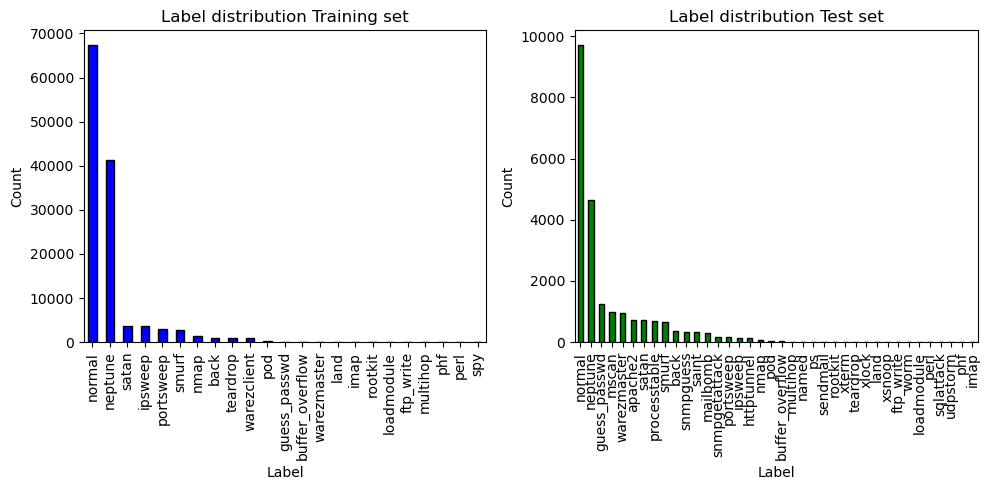

In [11]:
# Get label counts for training set
train_label_counts = dataset_train['attack_type'].value_counts()

# Get label counts for test set
test_label_counts = dataset_test['attack_type'].value_counts()

# Create a new figure
plt.figure(figsize=(10, 5))

# Create a bar plot for training set label distribution
plt.subplot(1, 2, 1)  # 1 row, 2 cols, subplot 1
train_label_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Label distribution Training set')
plt.xlabel('Label')
plt.ylabel('Count')

# Create a bar plot for test set label distribution
plt.subplot(1, 2, 2)  # 1 row, 2 cols, subplot 2
test_label_counts.plot(kind='bar', color='green', edgecolor='black')
plt.title('Label distribution Test set')
plt.xlabel('Label')
plt.ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

### Features
- 41 Features: Includes basic features (e.g., duration, protocol type), content features (e.g., number of failed login attempts), and traffic features (e.g., number of connections to the same host in the past two seconds). (Nkiama et al.)
- Attack Types: The dataset categorises attacks into four main groups: DoS, Probe, R2L, and U2R, alongside normal traffic. (Nkiama et al.)

## Data Cleaning

In [12]:
# Check for missing values in dataset_train
print("Missing values in dataset_train:")
print(dataset_train.isnull().any())

Missing values in dataset_train:
duration                       False
protocol_type                  False
service                        False
flag                           False
src_bytes                      False
dst_bytes                      False
land                           False
wrong_fragment                 False
urgent                         False
hot                            False
num_failed_logins              False
logged_in                      False
num_compromised                False
root_shell                     False
su_attempted                   False
num_root                       False
num_file_creations             False
num_shells                     False
num_access_files               False
num_outbound_cmds              False
is_host_login                  False
is_guest_login                 False
count                          False
srv_count                      False
serror_rate                    False
srv_serror_rate                False
rerro

In [13]:
# Check for missing values in dataset_test
print("\nMissing values in dataset_test:")
print(dataset_test.isnull().any())


Missing values in dataset_test:
duration                       False
protocol_type                  False
service                        False
flag                           False
src_bytes                      False
dst_bytes                      False
land                           False
wrong_fragment                 False
urgent                         False
hot                            False
num_failed_logins              False
logged_in                      False
num_compromised                False
root_shell                     False
su_attempted                   False
num_root                       False
num_file_creations             False
num_shells                     False
num_access_files               False
num_outbound_cmds              False
is_host_login                  False
is_guest_login                 False
count                          False
srv_count                      False
serror_rate                    False
srv_serror_rate                False
rerro

In [14]:
duplicate_rows = dataset_train.duplicated()
duplicate_data = dataset_train[duplicate_rows]
print(duplicate_data)


Empty DataFrame
Columns: [duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_host_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate, attack_type]
Index: []

[0 rows x 42 columns]


In [15]:
dataset_train.drop_duplicates(keep='first')

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0              0           tcp  ftp_data   SF        491          0     0   
1              0           udp     other   SF        146          0     0   
2              0           tcp   private   S0          0          0     0   
3              0           tcp      http   SF        232       8153     0   
4              0           tcp      http   SF        199        420     0   
...          ...           ...       ...  ...        ...        ...   ...   
125968         0           tcp   private   S0          0          0     0   
125969         8           udp   private   SF        105        145     0   
125970         0           tcp      smtp   SF       2231        384     0   
125971         0           tcp    klogin   S0          0          0     0   
125972         0           tcp  ftp_data   SF        151          0     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                    0       0    0  ...                  25   
1                    0       0    0  ...                   1   
2                    0       0    0  ...                  26   
3                    0       0    0  ...                 255   
4                    0       0    0  ...                 255   
...                ...     ...  ...  ...                 ...   
125968               0       0    0  ...                  25   
125969               0       0    0  ...                 244   
125970               0       0    0  ...                  30   
125971               0       0    0  ...                   8   
125972               0       0    0  ...                  77   

        dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                         0.17                    0.03   
1                         0.00                    0.60   
2                         0.10                    0.05   
3                         1.00                    0.00   
4                         1.00                    0.00   
...                        ...                     ...   
125968                    0.10                    0.06   
125969                    0.96                    0.01   
125970                    0.12                    0.06   
125971                    0.03                    0.05   
125972                    0.30                    0.03   

        dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                              0.17                         0.00   
1                              0.88                         0.00   
2                              0.00                         0.00   
3                              0.03                         0.04   
4                              0.00                         0.00   
...                             ...                          ...   
125968                         0.00                         0.00   
125969                         0.01                         0.00   
125970                         0.00                         0.00   
125971                         0.00                         0.00   
125972                         0.30                         0.00   

        dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                       0.00                      0.00                  0.05   
1                       0.00                      0.00                  0.00   
2                       1.00                      1.00                  0.00   
3                       0.03                      0.01                  0.00   
4                       0.00                      0.00                  0.00   
...                      ...                       ...                   ...   
125968                  1.00                      1.00                  0.00   
125969                  0.00                      0.00                  0.00   
125970                  0.72                      0.00                  0.01   


In [16]:
duplicate_rows = dataset_test.duplicated()
duplicate_data = dataset_test[duplicate_rows]
print(duplicate_data)

Empty DataFrame
Columns: [duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_host_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate, attack_type]
Index: []

[0 rows x 42 columns]


In [17]:
dataset_test.drop_duplicates(keep='first')

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0             0           tcp   private   REJ          0          0     0   
1             0           tcp   private   REJ          0          0     0   
2             2           tcp  ftp_data    SF      12983          0     0   
3             0          icmp     eco_i    SF         20          0     0   
4             1           tcp    telnet  RSTO          0         15     0   
...         ...           ...       ...   ...        ...        ...   ...   
22539         0           tcp      smtp    SF        794        333     0   
22540         0           tcp      http    SF        317        938     0   
22541         0           tcp      http    SF      54540       8314     0   
22542         0           udp  domain_u    SF         42         42     0   
22543         0           tcp    sunrpc   REJ          0          0     0   

       wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                   0       0    0  ...                  10   
1                   0       0    0  ...                   1   
2                   0       0    0  ...                  86   
3                   0       0    0  ...                  57   
4                   0       0    0  ...                  86   
...               ...     ...  ...  ...                 ...   
22539               0       0    0  ...                 141   
22540               0       0    0  ...                 255   
22541               0       0    2  ...                 255   
22542               0       0    0  ...                 252   
22543               0       0    0  ...                  21   

       dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                        0.04                    0.06   
1                        0.00                    0.06   
2                        0.61                    0.04   
3                        1.00                    0.00   
4                        0.31                    0.17   
...                       ...                     ...   
22539                    0.72                    0.06   
22540                    1.00                    0.00   
22541                    1.00                    0.00   
22542                    0.99                    0.01   
22543                    0.08                    0.03   

       dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                             0.00                         0.00   
1                             0.00                         0.00   
2                             0.61                         0.02   
3                             1.00                         0.28   
4                             0.03                         0.02   
...                            ...                          ...   
22539                         0.01                         0.01   
22540                         0.01                         0.01   
22541                         0.00                         0.00   
22542                         0.00                         0.00   
22543                         0.00                         0.00   

       dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                      0.00                       0.0                  1.00   
1                      0.00                       0.0                  1.00   
2                      0.00                       0.0                  0.00   
3                      0.00                       0.0                  0.00   
4                      0.00                       0.0                  0.83   
...                     ...                       ...                   ...   
22539                  0.01                       0.0                  0.00   
22540                  0.01                       0.0                  0.00   
22541                  0.00                       0.0                  0.07   
22542                  0.00                  

## Data_Preprocessing

 Data preprocessing occurs here due to numerical and categorical data in the dataset, and we only want to use numerical data for our models.

### Data Distribution
Unlike its predecessor, the NSL-KDD dataset provides a more balanced representation of different attack types, mitigating the issue of biased learning. (Tavallaee et al.) The dataset contains 24 attack types, with the most common being DoS (Denial of Service) and Probe attacks. The least common attack types are the U2R (User to Root) and R2L (Remote to Local) attacks. Looking at the distribution of attack types of both KDDTrain+ and KDDTest+ it is unbalanced and the values U2R and R2L will be prone to overfitting.

Columns ‘protocol_type’, ‘service’, ‘flag’ and ‘attack_type’ in both data sets all contain non-numerical data and will need to be encoded to numerical values. All other columns contain numerical data.

In this phase, categorical features within the dataset, specifically 'protocol_type', 'service', and 'flag', are identified and prepared for numerical transformation. This is a prerequisite for machine learning algorithms that require numerical input. The unique categories for each feature are extracted, and a structured format is created to facilitate the encoding process.

In [18]:
# Identify categorical features and explore their unique categories in the training set
print('Training set:')
for col_name in dataset_train.columns:
    if dataset_train[col_name].dtypes == 'object':
        unique_cat = len(dataset_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

# Check the distribution of categories in the 'service' feature
print()
print('Distribution of categories in service:')
print(dataset_train['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'attack_type' has 23 categories

Distribution of categories in service:
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: count, dtype: int64


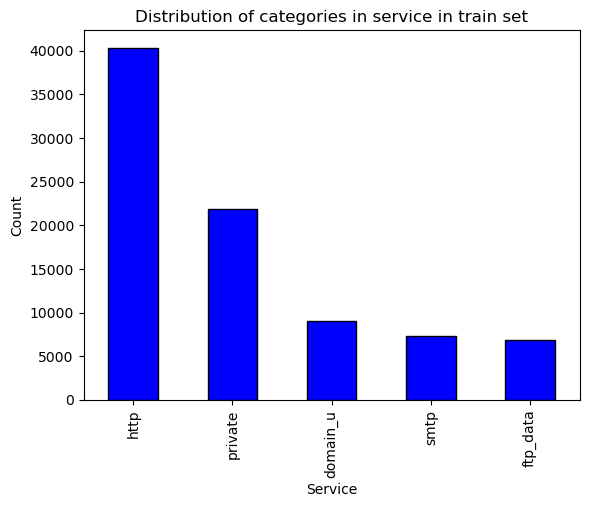

In [19]:
# Get the counts of the top categories in the 'service' column
service_counts = dataset_train['service'].value_counts().sort_values(ascending=False).head()

# Create a bar plot of the counts
service_counts.plot(kind='bar', color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Service')
plt.ylabel('Count')
plt.title('Distribution of categories in service in train set')

# Display the plot
plt.show()

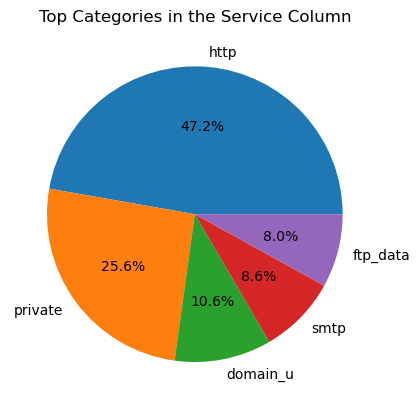

In [20]:
# Get the value counts of the 'service' column
service_counts = dataset_train['service'].value_counts()

# Get the top 5 categories
top_categories = service_counts.head(5)

# Create a pie chart
plt.pie(top_categories, labels=top_categories.index, autopct='%1.1f%%')

# Add a title
plt.title('Top Categories in the Service Column')

# Display the pie chart
plt.show()

In [21]:
# Test set
print('Test set:')
for col_name in dataset_test.columns:
    if dataset_test[col_name].dtypes == 'object' :
        unique_cat = len(dataset_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


# Check the distribution of categories in the 'service' feature
print()
print('Distribution of categories in service:')
print(dataset_test['service'].value_counts().sort_values(ascending=False).head())

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'attack_type' has 38 categories

Distribution of categories in service:
service
http       7853
private    4774
telnet     1626
pop_3      1019
smtp        934
Name: count, dtype: int64


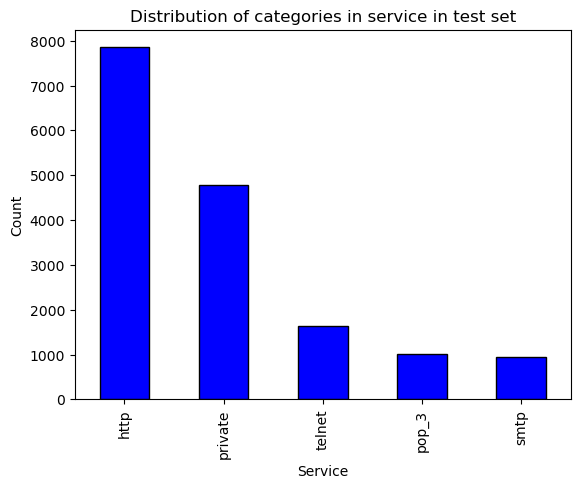

In [22]:
# Get the counts of the top categories in the 'service' column
service_counts = dataset_test['service'].value_counts().sort_values(ascending=False).head()

# Create a bar plot of the counts
service_counts.plot(kind='bar', color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Service')
plt.ylabel('Count')
plt.title('Distribution of categories in service in test set')

# Display the plot
plt.show()

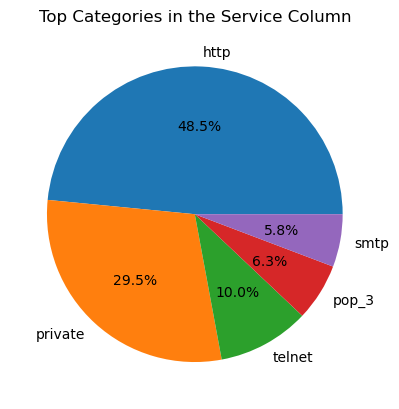

In [23]:
# Get the counts of the top categories in the 'service' column
service_counts = dataset_test['service'].value_counts().head()

# Create a pie chart
plt.pie(service_counts, labels=service_counts.index, autopct='%1.1f%%')

# Add a title
plt.title('Top Categories in the Service Column')

# Display the pie chart
plt.show()

In [24]:
# Concatenate the test and train datasets
combined_data = pd.concat([dataset_test, dataset_train])

# Print the unique values of the 'attack_type' column
print('Attack type values in all datasets:', set(list(combined_data['attack_type'])))

Attack type values in all datasets: {'neptune', 'processtable', 'mscan', 'sendmail', 'httptunnel', 'multihop', 'teardrop', 'xterm', 'snmpgetattack', 'worm', 'rootkit', 'buffer_overflow', 'nmap', 'land', 'sqlattack', 'portsweep', 'named', 'ftp_write', 'perl', 'guess_passwd', 'pod', 'apache2', 'xsnoop', 'smurf', 'normal', 'xlock', 'warezmaster', 'warezclient', 'back', 'phf', 'loadmodule', 'ps', 'imap', 'snmpguess', 'mailbomb', 'saint', 'satan', 'udpstorm', 'ipsweep', 'spy'}


In [25]:
print('Attack type values in Training dataset:', set(list(dataset_train['attack_type'])))

print()

print('Attack type values in Test dataset:', set(list(dataset_test['attack_type'])))


Attack type values in Training dataset: {'neptune', 'multihop', 'teardrop', 'rootkit', 'buffer_overflow', 'nmap', 'land', 'portsweep', 'ftp_write', 'perl', 'pod', 'guess_passwd', 'smurf', 'normal', 'warezclient', 'warezmaster', 'back', 'phf', 'loadmodule', 'imap', 'satan', 'ipsweep', 'spy'}

Attack type values in Test dataset: {'neptune', 'processtable', 'mscan', 'sendmail', 'httptunnel', 'multihop', 'teardrop', 'xterm', 'snmpgetattack', 'worm', 'rootkit', 'buffer_overflow', 'nmap', 'land', 'sqlattack', 'portsweep', 'named', 'ftp_write', 'perl', 'guess_passwd', 'pod', 'apache2', 'xsnoop', 'smurf', 'normal', 'xlock', 'warezmaster', 'back', 'phf', 'loadmodule', 'ps', 'imap', 'snmpguess', 'mailbomb', 'saint', 'satan', 'udpstorm', 'ipsweep'}


In [26]:
attack_types = ['perl', 'worm', 'xlock', 'udpstorm', 'nmap', 'processtable', 'portsweep', 'saint', 'ps', 'mscan', 'guess_passwd', 'land', 'warezclient', 'rootkit', 'satan', 'xterm', 'mailbomb', 'back', 'xsnoop', 'apache2', 'sendmail', 'teardrop', 'phf', 'named', 'smurf', 'pod', 'imap', 'ftp_write', 'normal', 'spy', 'snmpgetattack', 'snmpguess', 'loadmodule', 'multihop', 'neptune', 'warezmaster', 'buffer_overflow', 'httptunnel', 'sqlattack', 'ipsweep']

# Filter the attack_type_counts series to include only the attack types present in the attack_types list
attack_type_counts_all = combined_data['attack_type'].value_counts().loc[attack_types]

print(attack_type_counts_all)


attack_type
perl                   5
worm                   2
xlock                  9
udpstorm               2
nmap                1566
processtable         685
portsweep           3088
saint                319
ps                    15
mscan                996
guess_passwd        1284
land                  25
warezclient          890
rootkit               23
satan               4368
xterm                 13
mailbomb             293
back                1315
xsnoop                 4
apache2              737
sendmail              14
teardrop             904
phf                    6
named                 17
smurf               3311
pod                  242
imap                  12
ftp_write             11
normal             77054
spy                    2
snmpgetattack        178
snmpguess            331
loadmodule            11
multihop              25
neptune            45871
warezmaster          964
buffer_overflow       50
httptunnel           133
sqlattack              2
ipsweep      

In [160]:
attack_types = ['portsweep', 'smurf', 'rootkit', 'teardrop', 'land', 'ftp_write', 'neptune', 'back', 'multihop', 'pod', 'normal', 'satan', 'ipsweep', 'imap', 'guess_passwd', 'buffer_overflow', 'warezclient', 'nmap', 'loadmodule', 'warezmaster', 'perl', 'phf', 'spy']


# Filter the attack_type_counts series to include only the attack types present in the attack_types list
attack_type_counts = dataset_train['attack_type'].value_counts().loc[attack_types]

print(attack_type_counts)

attack_type
portsweep           2931
smurf               2646
rootkit               10
teardrop             892
land                  18
ftp_write              8
neptune            41214
back                 956
multihop               7
pod                  201
normal             67343
satan               3633
ipsweep             3599
imap                  11
guess_passwd          53
buffer_overflow       30
warezclient          890
nmap                1493
loadmodule             9
warezmaster           20
perl                   3
phf                    4
spy                    2
Name: count, dtype: int64


In [161]:
attack_types = ['xsnoop', 'named', 'portsweep', 'smurf', 'rootkit', 'teardrop', 'land', 'sendmail', 'worm', 'snmpguess', 'ftp_write', 'neptune', 'back', 'multihop', 'xterm', 'pod', 'normal', 'satan', 'saint', 'snmpgetattack', 'ipsweep', 'imap', 'httptunnel', 'apache2', 'guess_passwd', 'buffer_overflow', 'ps', 'mscan', 'udpstorm', 'nmap', 'xlock', 'loadmodule', 'warezmaster', 'perl', 'phf', 'processtable', 'sqlattack', 'mailbomb']



# Filter the attack_type_counts series to include only the attack types present in the attack_types list
attack_type_counts = dataset_test['attack_type'].value_counts().loc[attack_types]

print(attack_type_counts)

attack_type
xsnoop                4
named                17
portsweep           157
smurf               665
rootkit              13
teardrop             12
land                  7
sendmail             14
worm                  2
snmpguess           331
ftp_write             3
neptune            4657
back                359
multihop             18
xterm                13
pod                  41
normal             9711
satan               735
saint               319
snmpgetattack       178
ipsweep             141
imap                  1
httptunnel          133
apache2             737
guess_passwd       1231
buffer_overflow      20
ps                   15
mscan               996
udpstorm              2
nmap                 73
xlock                 9
loadmodule            2
warezmaster         944
perl                  2
phf                   2
processtable        685
sqlattack             2
mailbomb            293
Name: count, dtype: int64


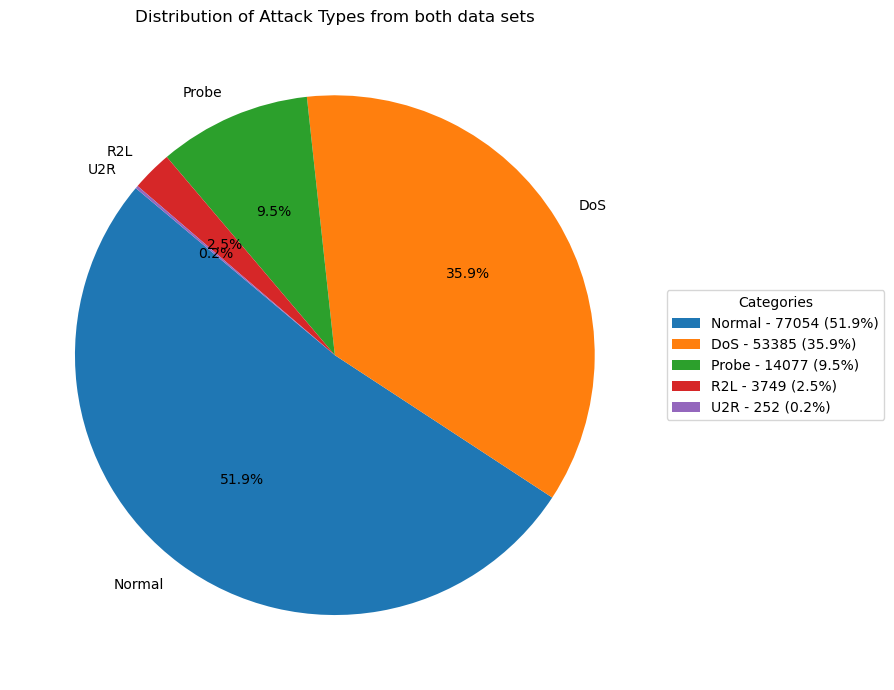

In [27]:
# existing attack types and counts
attack_types = ['perl', 'worm', 'xlock', 'udpstorm', 'nmap', 'processtable', 'portsweep', 'saint', 'ps', 'mscan', 'guess_passwd', 'land', 'warezclient', 'rootkit', 'satan', 'xterm', 'mailbomb', 'back', 'xsnoop', 'apache2', 'sendmail', 'teardrop', 'phf', 'named', 'smurf', 'pod', 'imap', 'ftp_write', 'normal', 'spy', 'snmpgetattack', 'snmpguess', 'loadmodule', 'multihop', 'neptune', 'warezmaster', 'buffer_overflow', 'httptunnel', 'sqlattack', 'ipsweep']


# Mapping of individual attacks to categories
attack_mapping = {
    'normal': 0,
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3,
    'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3,
    'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'worm': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'httptunnel': 4,
    'ps': 4, 'sqlattack': 4, 'xterm': 4
}

# Mapping of category codes to category names
category_names = {
    0: 'Normal',
    1: 'DoS',
    2: 'Probe',
    3: 'R2L',
    4: 'U2R'
}

# Map the attack types in attack_type_counts to their corresponding category codes
mapped_attack_type_counts = attack_type_counts_all.index.map(attack_mapping)

# Create a new Series with the mapped category codes
category_counts = pd.Series(data=attack_type_counts_all.values, index=mapped_attack_type_counts)

# Aggregate counts by category code
aggregated_category_counts = category_counts.groupby(level=0).sum()

# Map category codes to category names
aggregated_category_counts.index = aggregated_category_counts.index.map(category_names)

# Plotting the pie chart
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(aggregated_category_counts, 
                                   labels=aggregated_category_counts.index, 
                                   autopct='%1.1f%%', 
                                   startangle=140)

plt.title('Distribution of Attack Types from both data sets')

# Draw a legend with the category names and their corresponding values
category_labels = ['{0} - {1} ({2})'.format(i, j, k) for i, j, k in zip(aggregated_category_counts.index, aggregated_category_counts, ['{:.1f}%'.format(p) for p in (aggregated_category_counts / aggregated_category_counts.sum() * 100)])]

plt.legend(wedges, category_labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()


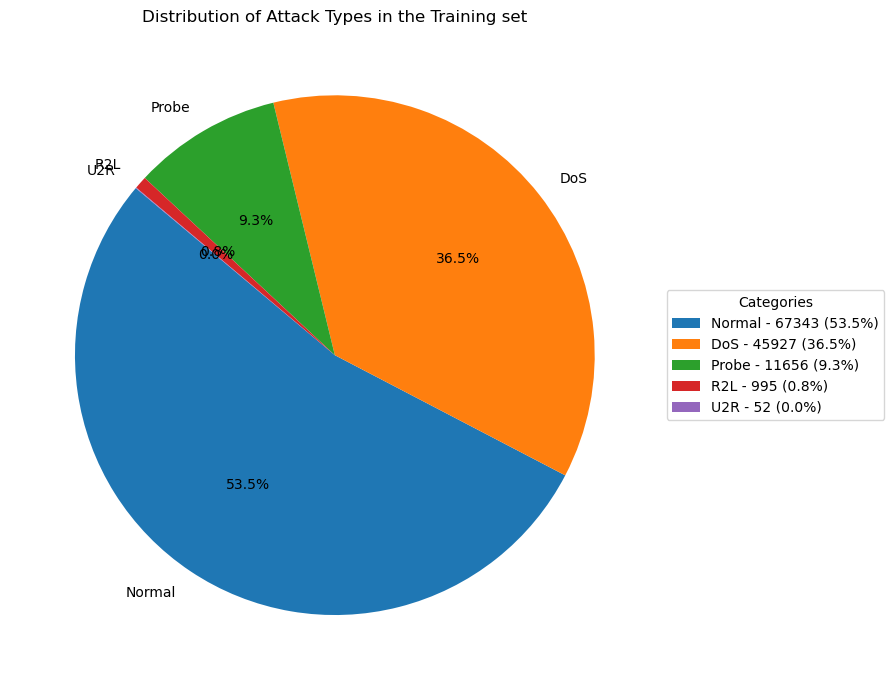

In [163]:
# Your provided list of attack types
attack_types = ['portsweep', 'smurf', 'rootkit', 'teardrop', 'land', 'ftp_write', 'neptune', 'back', 'multihop', 'pod', 'normal', 'satan', 'ipsweep', 'imap', 'guess_passwd', 'buffer_overflow', 'warezclient', 'nmap', 'loadmodule', 'warezmaster', 'perl', 'phf', 'spy']

# Filter the attack_type_counts series to include only the attack types present in the attack_types list
attack_type_counts = dataset_train['attack_type'].value_counts().loc[attack_types]

# Mapping of individual attacks to categories
attack_mapping = {
    'normal': 0,
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3,
    'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3,
    'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'worm': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'httptunnel': 4,
    'ps': 4, 'sqlattack': 4, 'xterm': 4
}

# Mapping of category codes to category names
category_names = {
    0: 'Normal',
    1: 'DoS',
    2: 'Probe',
    3: 'R2L',
    4: 'U2R'
}

# Map the attack types in attack_type_counts to their corresponding category codes
mapped_attack_type_counts = attack_type_counts.index.map(attack_mapping)

# Create a new Series with the mapped category codes
category_counts = pd.Series(data=attack_type_counts.values, index=mapped_attack_type_counts)

# Aggregate counts by category code
aggregated_category_counts = category_counts.groupby(level=0).sum()

# Map category codes to category names
aggregated_category_counts.index = aggregated_category_counts.index.map(category_names)

# Plotting the pie chart
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(aggregated_category_counts, 
                                   labels=aggregated_category_counts.index, 
                                   autopct='%1.1f%%', 
                                   startangle=140)

plt.title('Distribution of Attack Types in the Training set')

# Draw a legend with the category names and their corresponding values
category_labels = ['{0} - {1} ({2})'.format(i, j, k) for i, j, k in zip(aggregated_category_counts.index, aggregated_category_counts, ['{:.1f}%'.format(p) for p in (aggregated_category_counts / aggregated_category_counts.sum() * 100)])]

plt.legend(wedges, category_labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()


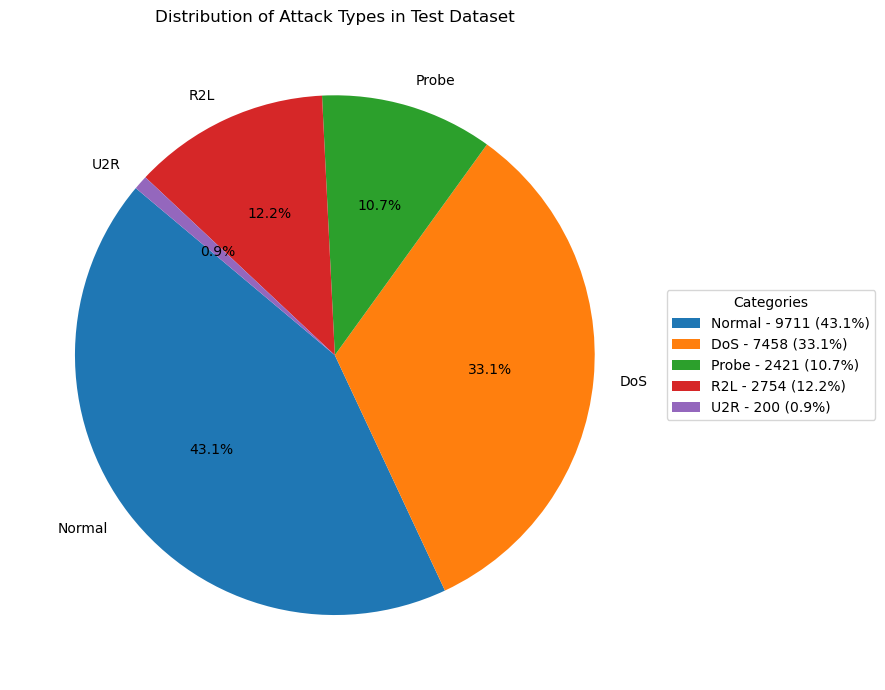

In [164]:
# Your provided list of attack types
attack_types = ['xsnoop', 'named', 'portsweep', 'smurf', 'rootkit', 'teardrop', 'land', 'sendmail', 'worm', 'snmpguess', 'ftp_write', 'neptune', 'back', 'multihop', 'xterm', 'pod', 'normal', 'satan', 'saint', 'snmpgetattack', 'ipsweep', 'imap', 'httptunnel', 'apache2', 'guess_passwd', 'buffer_overflow', 'ps', 'mscan', 'udpstorm', 'nmap', 'xlock', 'loadmodule', 'warezmaster', 'perl', 'phf', 'processtable', 'sqlattack', 'mailbomb']

# Filter the attack_type_counts series to include only the attack types present in the attack_types list
attack_type_counts = dataset_test['attack_type'].value_counts().loc[attack_types]

# Mapping of individual attacks to categories
attack_mapping = {
    'normal': 0,
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3,
    'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3,
    'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'worm': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'httptunnel': 4,
    'ps': 4, 'sqlattack': 4, 'xterm': 4
}

# Mapping of category codes to category names
category_names = {
    0: 'Normal',
    1: 'DoS',
    2: 'Probe',
    3: 'R2L',
    4: 'U2R'
}

# Map the attack types in attack_type_counts to their corresponding category codes
mapped_attack_type_counts = attack_type_counts.index.map(attack_mapping)

# Create a new Series with the mapped category codes
category_counts = pd.Series(data=attack_type_counts.values, index=mapped_attack_type_counts)

# Aggregate counts by category code
aggregated_category_counts = category_counts.groupby(level=0).sum()

# Map category codes to category names
aggregated_category_counts.index = aggregated_category_counts.index.map(category_names)

# Plotting the pie chart
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(aggregated_category_counts, 
                                   labels=aggregated_category_counts.index, 
                                   autopct='%1.1f%%', 
                                   startangle=140)

plt.title('Distribution of Attack Types in Test Dataset')

# Draw a legend with the category names and their corresponding values
category_labels = ['{0} - {1} ({2})'.format(i, j, k) for i, j, k in zip(aggregated_category_counts.index, aggregated_category_counts, ['{:.1f}%'.format(p) for p in (aggregated_category_counts / aggregated_category_counts.sum() * 100)])]

plt.legend(wedges, category_labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()


### Looking for categorical data

In [165]:
# Get the columns with categorical data for train set
categorical_columns = dataset_train.select_dtypes(include=['object']).columns

# Print the categorical columns
print(categorical_columns)

Index(['protocol_type', 'service', 'flag', 'attack_type'], dtype='object')


In [166]:
# Get the columns with categorical data for test set
categorical_columns = dataset_test.select_dtypes(include=['object']).columns

# Print the categorical columns
print(categorical_columns)

Index(['protocol_type', 'service', 'flag', 'attack_type'], dtype='object')


## One Hot Encode

The methodology utilises One-Hot Encoding to transform categorical variables into a format that can be provided to machine learning models. This technique creates binary columns for each category/value of the original variable, ensuring the representation of categorical data without implying any ordinality. The implementation uses the OneHotEncoder from the scikit-learn library, which is applied to both the training and test datasets to maintain consistency.

In [167]:
categorical_columns = ['protocol_type', 'service', 'flag']

# Initialise OneHotEncoder
enc = OneHotEncoder(handle_unknown='error')

# Fit the encoder on the training data and transform it
dataset_train_categorical_values_fit_enc = enc.fit_transform(dataset_train[categorical_columns])

# Convert the encoded values to a dataframe and assign column names
dataset_train_categorical_data = pd.DataFrame(dataset_train_categorical_values_fit_enc.toarray(), columns=enc.get_feature_names_out(categorical_columns))

# Transform the test data using the same encoder
dataset_test_categorical_values_fit_enc = enc.transform(dataset_test[categorical_columns])

# Convert the encoded values to a dataframe
# Ensure the test set columns match the training set
dataset_test_categorical_data = pd.DataFrame(dataset_test_categorical_values_fit_enc.toarray(), columns=dataset_train_categorical_data.columns)

# Drop original categorical columns from the datasets
dataset_train = dataset_train.drop(categorical_columns, axis=1)
dataset_test = dataset_test.drop(categorical_columns, axis=1)

# Concatenate the new one-hot encoded columns with the original datasets
dataset_train_final = pd.concat([dataset_train, dataset_train_categorical_data], axis=1)
dataset_test_final = pd.concat([dataset_test, dataset_test_categorical_data], axis=1)


In [168]:
# Print the shape of the new dataframe to check the number of rows and columns
print(dataset_train_final.shape)

# Print the shape of the new test dataframe to check the number of rows and columns
print(dataset_test_final.shape)

(125973, 123)
(22544, 123)


In [169]:
dataset_train_final.head()

duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        491          0     0               0       0    0   
1         0        146          0     0               0       0    0   
2         0          0          0     0               0       0    0   
3         0        232       8153     0               0       0    0   
4         0        199        420     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                  0          0                0  ...       0.0        0.0   
1                  0          0                0  ...       0.0        0.0   
2                  0          0                0  ...       0.0        0.0   
3                  0          1                0  ...       0.0        0.0   
4                  0          1                0  ...       0.0        0.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0          0.0        0.0      0.0      0.0      0.0      0.0      1.0   
1          0.0        0.0      0.0      0.0      0.0      0.0      1.0   
2          0.0        0.0      1.0      0.0      0.0      0.0      0.0   
3          0.0        0.0      0.0      0.0      0.0      0.0      1.0   
4          0.0        0.0      0.0      0.0      0.0      0.0      1.0   

   flag_SH  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  

[5 rows x 123 columns]

In [170]:
dataset_test_final.head()

duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0          0          0     0               0       0    0   
1         0          0          0     0               0       0    0   
2         2      12983          0     0               0       0    0   
3         0         20          0     0               0       0    0   
4         1          0         15     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                  0          0                0  ...       1.0        0.0   
1                  0          0                0  ...       1.0        0.0   
2                  0          0                0  ...       0.0        0.0   
3                  0          0                0  ...       0.0        0.0   
4                  0          0                0  ...       0.0        1.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0          0.0        0.0      0.0      0.0      0.0      0.0      0.0   
1          0.0        0.0      0.0      0.0      0.0      0.0      0.0   
2          0.0        0.0      0.0      0.0      0.0      0.0      1.0   
3          0.0        0.0      0.0      0.0      0.0      0.0      1.0   
4          0.0        0.0      0.0      0.0      0.0      0.0      0.0   

   flag_SH  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  

[5 rows x 123 columns]

## Split Dataset into 4 datasets for every attack category

In [171]:
def categorise_attacks(df):
    # Mapping of attacks to categories
    # http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types
    attack_mapping = {
    'normal': 0,
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3,
    'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3,
    'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'worm': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'httptunnel': 4,
    'ps': 4, 'sqlattack': 4, 'xterm': 4
}


    # Replace the 'attacktype' column based on the mapping
    df['attack_type'] = df['attack_type'].map(attack_mapping)

# Apply the function to both datasets
categorise_attacks(dataset_train_final)
categorise_attacks(dataset_test_final)

In [172]:
print(dataset_train_final['attack_type'])

0         0
1         0
2         1
3         0
4         0
         ..
125968    1
125969    0
125970    0
125971    1
125972    0
Name: attack_type, Length: 125973, dtype: int64


In [173]:
# Function to segment the dataset
def segment_dataset(dataset, attack_types):
    segmented_data = {}
    for attack_type in attack_types:
        segmented_data[attack_type] = dataset[dataset['attack_type'].isin(attack_types[attack_type])]
    return segmented_data

# Define the attack types and their corresponding labels
attack_types = {
    'DoS': [0,1],
    'Probe': [0,2],
    'R2L': [0,3],
    'U2R': [0,4]
}

# Segment the training dataset
train_segments = segment_dataset(dataset_train_final, attack_types)
dataset_train_DoS = train_segments['DoS']
dataset_train_Probe = train_segments['Probe']
dataset_train_R2L = train_segments['R2L']
dataset_train_U2R = train_segments['U2R']

# Segment the testing dataset
test_segments = segment_dataset(dataset_test_final, attack_types)
dataset_test_DoS = test_segments['DoS']
dataset_test_Probe = test_segments['Probe']
dataset_test_R2L = test_segments['R2L']
dataset_test_U2R = test_segments['U2R']

# Print the dimensions of the new datasets
print('Train Set Dimensions:')
print(f'DoS: {dataset_train_DoS.shape}')
print(f'Probe: {dataset_train_Probe.shape}')
print(f'R2L: {dataset_train_R2L.shape}')
print(f'U2R: {dataset_train_U2R.shape}')

print('\nTest Set Dimensions:')
print(f'DoS: {dataset_test_DoS.shape}')
print(f'Probe: {dataset_test_Probe.shape}')
print(f'R2L: {dataset_test_R2L.shape}')
print(f'U2R: {dataset_test_U2R.shape}')

Train Set Dimensions:
DoS: (113270, 123)
Probe: (78999, 123)
R2L: (68338, 123)
U2R: (67395, 123)

Test Set Dimensions:
DoS: (17169, 123)
Probe: (12132, 123)
R2L: (12465, 123)
U2R: (9911, 123)


In [174]:
dataset_train_DoS.head()

duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        491          0     0               0       0    0   
1         0        146          0     0               0       0    0   
2         0          0          0     0               0       0    0   
3         0        232       8153     0               0       0    0   
4         0        199        420     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                  0          0                0  ...       0.0        0.0   
1                  0          0                0  ...       0.0        0.0   
2                  0          0                0  ...       0.0        0.0   
3                  0          1                0  ...       0.0        0.0   
4                  0          1                0  ...       0.0        0.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0          0.0        0.0      0.0      0.0      0.0      0.0      1.0   
1          0.0        0.0      0.0      0.0      0.0      0.0      1.0   
2          0.0        0.0      1.0      0.0      0.0      0.0      0.0   
3          0.0        0.0      0.0      0.0      0.0      0.0      1.0   
4          0.0        0.0      0.0      0.0      0.0      0.0      1.0   

   flag_SH  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  

[5 rows x 123 columns]

In [175]:
dataset_train_R2L.head()

duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0          0        491          0     0               0       0    0   
1          0        146          0     0               0       0    0   
3          0        232       8153     0               0       0    0   
4          0        199        420     0               0       0    0   
12         0        287       2251     0               0       0    0   

    num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                   0          0                0  ...       0.0        0.0   
1                   0          0                0  ...       0.0        0.0   
3                   0          1                0  ...       0.0        0.0   
4                   0          1                0  ...       0.0        0.0   
12                  0          1                0  ...       0.0        0.0   

    flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0           0.0        0.0      0.0      0.0      0.0      0.0      1.0   
1           0.0        0.0      0.0      0.0      0.0      0.0      1.0   
3           0.0        0.0      0.0      0.0      0.0      0.0      1.0   
4           0.0        0.0      0.0      0.0      0.0      0.0      1.0   
12          0.0        0.0      0.0      0.0      0.0      0.0      1.0   

    flag_SH  
0       0.0  
1       0.0  
3       0.0  
4       0.0  
12      0.0  

[5 rows x 123 columns]

## Splitting the datasets

In [176]:
def prepare_dataset(dataset, dataset_name):
    global X_DoS, Y_DoS, X_Probe, Y_Probe, X_R2L, Y_R2L, X_U2R, Y_U2R
    global X_DoS_test, Y_DoS_test, X_Probe_test, Y_Probe_test, X_R2L_test, Y_R2L_test, X_U2R_test, Y_U2R_test

    try:
        # Splitting the dataset into features (X) and labels (Y)
        X = dataset.drop('attack_type', axis=1)
        Y = dataset['attack_type']

        # Assigning to the respective global variables
        if dataset_name == 'dataset_train_DoS':
            X_DoS, Y_DoS = X, Y
        elif dataset_name == 'dataset_train_Probe':
            X_Probe, Y_Probe = X, Y
        elif dataset_name == 'dataset_train_R2L':
            X_R2L, Y_R2L = X, Y
        elif dataset_name == 'dataset_train_U2R':
            X_U2R, Y_U2R = X, Y
        elif dataset_name == 'dataset_test_DoS':
            X_DoS_test, Y_DoS_test = X, Y
        elif dataset_name == 'dataset_test_Probe':
            X_Probe_test, Y_Probe_test = X, Y
        elif dataset_name == 'dataset_test_R2L':
            X_R2L_test, Y_R2L_test = X, Y
        elif dataset_name == 'dataset_test_U2R':
            X_U2R_test, Y_U2R_test = X, Y

    except KeyError as e:
        print(f"Error: Column {e} not found in {dataset_name}.")
    except Exception as e:
        print(f"An unexpected error occurred while processing {dataset_name}: {e}")

# Applying the function to each dataset
prepare_dataset(dataset_train_DoS, 'dataset_train_DoS')
prepare_dataset(dataset_train_Probe, 'dataset_train_Probe')
prepare_dataset(dataset_train_R2L, 'dataset_train_R2L')
prepare_dataset(dataset_train_U2R, 'dataset_train_U2R')
prepare_dataset(dataset_test_DoS, 'dataset_test_DoS')
prepare_dataset(dataset_test_Probe, 'dataset_test_Probe')
prepare_dataset(dataset_test_R2L, 'dataset_test_R2L')
prepare_dataset(dataset_test_U2R, 'dataset_test_U2R')

In [177]:
X_dataset_train_final = dataset_train_final.drop('attack_type', axis=1)
Y_dataset_train_final = dataset_train_final['attack_type']

X_dataset_test_final = dataset_test_final.drop('attack_type', axis=1)
Y_dataset_test_final = dataset_test_final['attack_type']

## Feature_Scaling

Feature scaling is performed using StandardScaler, normalising the feature values to have a mean of zero and a standard deviation of one. This procedure is conducted independently on different segments of the dataset (DoS, Probe, R2L, U2R) to account for possible variations in data distribution across these segments.

In [178]:
# Initialise separate scalers for each segment
scaler_DoS = StandardScaler()
scaler_Probe = StandardScaler()
scaler_R2L = StandardScaler()
scaler_U2R = StandardScaler()
scaler_All = StandardScaler()

# Scale DoS segment
X_DoS = scaler_DoS.fit_transform(X_DoS)
X_DoS_test = scaler_DoS.transform(X_DoS_test)

# Scale Probe segment
X_Probe = scaler_Probe.fit_transform(X_Probe)
X_Probe_test = scaler_Probe.transform(X_Probe_test)

# Scale R2L segment
X_R2L = scaler_R2L.fit_transform(X_R2L)
X_R2L_test = scaler_R2L.transform(X_R2L_test)

# Scale U2R segment
X_U2R = scaler_U2R.fit_transform(X_U2R)
X_U2R_test = scaler_U2R.transform(X_U2R_test)

# Scale the entire dataset
X_dataset_train_final = scaler_All.fit_transform(X_dataset_train_final)
X_dataset_test_final = scaler_All.transform(X_dataset_test_final)

In [179]:
X_DoS.shape

(113270, 122)

In [180]:
X_DoS_test.shape

(17169, 122)

In [181]:
X_Probe.shape

(78999, 122)

In [182]:
X_Probe_test.shape

(12132, 122)

In [183]:
X_R2L.shape

(68338, 122)

In [184]:
X_R2L_test.shape

(12465, 122)

In [185]:
X_U2R.shape

(67395, 122)

In [186]:
X_U2R_test.shape

(9911, 122)

In [187]:
X_dataset_train_final.shape

(125973, 122)

In [188]:
X_dataset_test_final.shape

(22544, 122)

### Data Balancing analysis

In [189]:
print(Y_R2L.value_counts())

attack_type
0    67343
3      995
Name: count, dtype: int64


In [190]:
print(Y_dataset_train_final.value_counts())

attack_type
0    67343
1    45927
2    11656
3      995
4       52
Name: count, dtype: int64


## Managing_imbalance_in_the_datasets

To help balance the datasets with the most imbalance (R2L and U2R), the SMOTE (Synthetic Minority Oversampling Technique) algorithm is applied to the Main dataset, R2L and U2R training datasets paired with randomundersampling. This technique generates synthetic samples of the minority class (attack types) to match the number of samples in the majority class (normal traffic). The SMOTE algorithm is implemented using the imblearn library, and the resulting datasets are used to train the models. However U2R has been excluded from this process as it did not respond well due to the low number of samples and the test set not being representative of the training set.

In [191]:
# Managing imbalance in the training set

# Define the resampling strategy
over_strategy = {3: 18000, 4: 18000}  # 3: R2L, 4: U2R
under_strategy = {0: 10000, 1: 9000, 2: 8000}  # 0: Normal, 1: DoS, 2: Probe

# Initialise the resampling objects
over = SMOTE(sampling_strategy=over_strategy)
under = RandomUnderSampler(sampling_strategy=under_strategy)

# Define the resampling pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])

X_dataset_train_final, Y_dataset_train_final = pipeline.fit_resample(X_dataset_train_final, Y_dataset_train_final)

In [192]:
print(Y_dataset_train_final.value_counts())

attack_type
3    18000
4    18000
0    10000
1     9000
2     8000
Name: count, dtype: int64


In [193]:
# Managing imbalance in R2L and U2R training datasets

# Define the resampling strategy
over_strategy = {3: 8000}
under_strategy = {0: 30000}

# Initialise the resampling objects
over = SMOTE(sampling_strategy=over_strategy)
under = RandomUnderSampler(sampling_strategy=under_strategy)

# Define the resampling pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])

X_R2L, Y_R2L = pipeline.fit_resample(X_R2L, Y_R2L)

# U2R does not response well to the SMOTE resampling method
# X_U2R, Y_U2R = pipeline.fit_resample(X_U2R, Y_U2R)

In [194]:
print(Y_R2L.value_counts())

attack_type
0    30000
3     8000
Name: count, dtype: int64


## Feature_Selection

## Feature Selection for decision tree, gradient boosting, KNN and SVM

RFE is used for feature selection for decision tree, gradient boosting, KNN and SVM. The reason why RFE is used is because it is a wrapper method that uses the model to identify the best features. The model used is the decision tree model. The reason as to why only 30% of features are sleected is because the model is overfitting when all features are used.

In [195]:
# Create a base classifier to be used for the RFE
base_estimator_DoS = DecisionTreeClassifier(random_state=0)
base_estimator_Probe = DecisionTreeClassifier(random_state=0)
base_estimator_R2L = DecisionTreeClassifier(random_state=0)
base_estimator_U2R = DecisionTreeClassifier(random_state=0)
base_estimator_All = DecisionTreeClassifier(random_state=0)

# Using half of the features:
n_features_to_select_DoS = int(X_DoS.shape[1] * 0.3)
n_features_to_select_Probe = int(X_Probe.shape[1] * 0.3)
n_features_to_select_R2L = int(X_R2L.shape[1] * 0.3)
n_features_to_select_U2R = int(X_U2R.shape[1] * 0.3)
n_features_to_select_All = int(X_dataset_train_final.shape[1] * 0.3)

# Create the RFE object
rfe_selector_DoS = RFE(estimator=base_estimator_DoS, n_features_to_select=n_features_to_select_DoS, step=1)
rfe_selector_Probe = RFE(estimator=base_estimator_Probe, n_features_to_select=n_features_to_select_Probe, step=1)
rfe_selector_R2L = RFE(estimator=base_estimator_R2L, n_features_to_select=n_features_to_select_R2L, step=1)
rfe_selector_U2R = RFE(estimator=base_estimator_U2R, n_features_to_select=n_features_to_select_U2R, step=1)
rfe_selector_All = RFE(estimator=base_estimator_All, n_features_to_select=n_features_to_select_All, step=1)

# Fit the RFE selector to the datasets
X_newDoS = rfe_selector_DoS.fit_transform(X_DoS, Y_DoS)
X_newDoS_test = rfe_selector_DoS.transform(X_DoS_test)

X_newProbe = rfe_selector_Probe.fit_transform(X_Probe, Y_Probe)
X_newProbe_test = rfe_selector_Probe.transform(X_Probe_test)

X_newR2L = rfe_selector_R2L.fit_transform(X_R2L, Y_R2L)
X_newR2L_test = rfe_selector_R2L.transform(X_R2L_test)

X_newU2R = rfe_selector_U2R.fit_transform(X_U2R, Y_U2R)
X_newU2R_test = rfe_selector_U2R.transform(X_U2R_test)

X_NewAll = rfe_selector_All.fit_transform(X_dataset_train_final, Y_dataset_train_final)
X_NewAll_test = rfe_selector_All.transform(X_dataset_test_final)

## Feature Selection for random forest

For the random forest model, ANOVA F-value f_classif scoring function is used to identify the top 20% of features that have the highest correlation with the target variable. The feature selection process is applied to the training dataset, and the resulting features are used to transform both the training and test datasets. The reaon why is due to the high computational cost of the random forest model, resulting in the rfe method taking too long to run, and the ANOVA F-value f_classif scoring function is a good alternative.

In [196]:
# Select the top 20% of features based on their ANOVA F-value
selector = SelectPercentile(f_classif, percentile=20)

X_newDoS_rfe = selector.fit_transform(X_DoS, Y_DoS)
X_newDoS_test_rfe = selector.transform(X_DoS_test)

X_newProbe_rfe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe_test_rfe = selector.transform(X_Probe_test)

X_newR2L_rfe = selector.fit_transform(X_R2L,Y_R2L)
X_newR2L_test_rfe = selector.transform(X_R2L_test)

X_newU2R_rfe = selector.fit_transform(X_U2R,Y_U2R)
X_newU2R_test_rfe = selector.transform(X_U2R_test)

/Users/kaialogen/anaconda3/envs/Test-Mac/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 16  44  63  66  68  86 114] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kaialogen/anaconda3/envs/Test-Mac/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/kaialogen/anaconda3/envs/Test-Mac/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kaialogen/anaconda3/envs/Test-Mac/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/kaialogen/anaconda3/envs/Test-Mac/lib/python3.11/site-packages/sklearn/feature_

## Machine_Learning_Models


### Decision Tree
Decision Trees are a non-parametric supervised learning method used for classification and regression. Decision trees model decisions and their possible consequences, including chance event outcomes, resource costs, and utility.

| Aspect                       | Description                                                                                                                                                                                                                       |
|------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Type**                     | Decision Tree                                                                                                                                                                                                                     |
| **Application in Intrusion Detection**             | Interpretability: Decision Trees offer a clear visualisation of the decision-making process, making them highly interpretable. This is crucial in intrusion detection for understanding the basis of a particular classification.<br> Handling Non-Linear Relationships: They can capture non-linear relationships between features, which is beneficial given the complex nature of network traffic data.<br> Feature Importance: Decision Trees inherently perform feature selection, highlighting the most significant features for intrusion detection.                           |
| **Limitations**              | Overfitting: Prone to overfitting, especially with complex trees. Overfitting can lead to poor generalisation of unseen data.<br> Vulnerability to Variance: Small changes in the data can lead to different tree structures, making the model sensitive to the specifics of the training data.                                                                                                                |


### Decision Tree with Gradient Boosting
Gradient Boosting Decision Trees (GBDT) is an ensemble learning technique that builds the model in a stage-wise fashion. It constructs new models that predict the residuals or errors of prior models and then combines them to make the final prediction.

| Aspect                       | Description                                                                                                                                                                                                                       |
|------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Type**                     | Decision Tree with Gradient Boosting                                                                                                                                                                                               |
| **Application in Intrusion Detection**             | Improved Prediction Accuracy: By sequentially correcting errors made by previous trees, gradient boosting can improve prediction accuracy compared to a single decision tree.<br> Handling of Various Data Types: GBDT can handle different types of predictor variables and accommodate missing data.<br> Feature Importance: Like Decision Trees, GBDT also provides feature importance scores, offering insights into the most significant features for intrusion detection.                    |
| **Limitations**              | Overfitting Risk: If not properly tuned, gradient boosting can overfit the training data, especially in the presence of noise.<br> Computational Expense: More computationally expensive than a single decision tree due to sequential model building. It can be slower to train, especially with large datasets.<br> Hyperparameter Tuning: Requires careful tuning of parameters such as the number of trees, depth of trees, learning rate, etc., which can be complex and time-consuming.                                   |


### Random Forest
Random Forest is an ensemble learning method for classification, regression, and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the Random Forest is the class selected by most trees.

| Aspect                       | Description                                                                                                                                                                                                                       |
|------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Type**                     | Random Forest                                                                                                                                                                                                                     |
| **Application in Intrusion Detection**             | Robustness to Overfitting: By building multiple decision trees and merging their outcomes, Random Forests mitigate the risk of overfitting, a common issue with single decision trees.<br> Handling High-Dimensional Data: It can handle large datasets with higher dimensionality. It can manage thousands of input variables without variable deletion, which is significant for network intrusion detection where the input features are numerous and heterogeneous.<br> Model Accuracy and Feature Importance: Random Forests are known for their high accuracy and the ability to run estimations of which variables are important in the classification. |
| **Limitations**              | Complexity and Resource Intensive: They are more complex and computationally intensive than individual decision trees, leading to longer training times.<br> Model Interpretability: While individual decision trees are interpretable, Random Forests lose this quality due to the ensemble of trees, making it difficult to visually interpret the model's decision-making process                                          |


### K-Nearest Neighbours (KNN)
KNN is a simple, instance-based learning algorithm. It classifies a new case based on a similarity measure (e.g., distance functions) with labelled instances from the training dataset.

| Aspect                       | Description                                                                                                                                                                                                                       |
|------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Type**                     | K-Nearest Neighbours (KNN)                                                                                                                                                                                                         |
| **Application in Intrusion Detection**             | Simplicity and Flexibility: KNN is simple to implement and understand. It can be easily adjusted by changing the value of K (number of neighbours) or the distance metric.<br> Effectiveness in Small Datasets: It can be particularly effective if the dataset is not excessively large, as KNN can suffer from performance issues with large datasets.<br> No Model Training Phase: KNN doesn't require a training phase, which can be beneficial in scenarios where the model needs to be frequently updated with new data types.                                  |
| **Limitations**              | Scalability: KNN struggles with scalability and efficiency, especially with large datasets and a high number of features.<br> Sensitivity to Imbalanced Data and Irrelevant Features: The performance of KNN can be significantly affected by imbalanced data and irrelevant or redundant features.                                                            |



### Support Vector Machine (SVM)
Support Vector Machines (SVM) is a set of supervised learning methods used for classification, regression, and outliers detection. The objective of the SVM algorithm is to find a hyperplane in an N-dimensional space that distinctly classifies the data points.


| Aspect                       | Description                                                                                                                                                                                                                       |
|------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Type**                     | Support Vector Machine (SVM)                                                                                                                                                                                                       |
| **Application in Intrusion Detection**             | Effectiveness in High-Dimensional Spaces: SVM is effective in high-dimensional spaces, which is ideal for intrusion detection systems where datasets often have many features.<br> Memory Efficiency: SVMs are memory efficient because they use a subset of training points (support vectors) in the decision function.<br> Versatility: SVMs are versatile, as different Kernel functions can be specified for the decision function. It's possible to implement custom kernels for specific decision surfaces. |
| **Limitations**              | Algorithm Complexity and Resource Intensity: The algorithm is relatively complex and can be resource-intensive, making it slower for large datasets.<br> Kernel Selection: The choice of the kernel and its parameters can have a significant impact on the performance. Selecting the appropriate kernel and tuning its parameters requires expertise and extensive experimentation.<br> Limited Performance on Overlapping Classes: SVMs do not perform very well when the data has more noise, i.e., target classes are overlapping.    |

---



### Summary of Models
Decision Trees provide a good starting point due to their interpretability and feature importance capabilities, offering clear insights into decision-making criteria. This aspect is crucial for understanding how different attack types are classified. However, their susceptibility to overfitting and vulnerability to variance could hinder their performance, especially when dealing with the diverse and complex nature of attack types in the NSL-KDD dataset.

Gradient Boosting Decision Trees (GBDT) enhance Decision Trees by addressing their propensity for overfitting through sequential model improvement. The improved prediction accuracy of GBDT is a significant asset for the nuanced task of attack type recognition. Nevertheless, the increased computational expense and the necessity for meticulous hyperparameter tuning introduce complexity, potentially complicating the model deployment and maintenance.

Random Forests mitigate the overfitting issue prevalent in single Decision Trees by integrating multiple trees' outcomes. This model's robustness and high-dimensional data handling are advantageous for the NSL-KDD dataset. Yet, the interpretability is compromised, and the increased complexity and resource intensiveness of Random Forests may not align with all operational environments, especially where computational resources or interpretability are prioritised.

K-Nearest Neighbours (KNN) stands out for its simplicity and effectiveness with smaller datasets. While the NSL-KDD dataset's size could challenge KNN's performance, its instance-based learning nature and adaptability in the choice of K and distance metric provide a flexible approach. The model's sensitivity to imbalanced data and irrelevant features, however, demands rigorous preprocessing of the NSL-KDD dataset to ensure optimal performance.

Support Vector Machines (SVM) offer effectiveness in high-dimensional spaces and versatility with various kernel functions, both of which are beneficial for the NSL-KDD dataset. The memory efficiency of SVMs is also favorable. However, the complexity of the algorithm, the resource intensity, and the challenges in kernel selection and parameter tuning make SVMs a more sophisticated choice, potentially limiting their applicability in scenarios requiring rapid deployment or model interpretability.

In conclusion, while each model has its merits, the choice for the NSL-KDD dataset task should be informed by a balance between accuracy, interpretability, computational efficiency, and the ability to handle high-dimensional data. To create a balanced approach, all models apart from SVM are selected for evaluation, and their performance is compared to identify the most suitable model for the task. this testing includes the use of the confusion matrix, accuracy, precision, recall, f1-score and roc_auc_score on all datasets.

SVM was not chosen due to the high computational cost of the model, resulting in the model taking too long to run, and the model not being able to handle the high dimensionality of the dataset.

### Building the models
All models have been designed with a computational cost in mind, and the models have been built with the best parameters found from the gridsearchcv function. Each model have similar architectures, with the only difference being the model used, this is to ensure that the models are comparable.

# Decision_tree_code

In [64]:
# Decison Tree Classifier
# Time taken to run: 6 minutes

# Create decision tree classifiers for each attack type
clf_DoS = DecisionTreeClassifier(random_state=0)
clf_DoS_features = DecisionTreeClassifier(random_state=0)
clf_Probe = DecisionTreeClassifier(random_state=0)
clf_Probe_features = DecisionTreeClassifier(random_state=0)
clf_R2L = DecisionTreeClassifier(random_state=0)
clf_R2L_features = DecisionTreeClassifier(random_state=0)
clf_U2R = DecisionTreeClassifier(random_state=0)
clf_U2R_features = DecisionTreeClassifier(random_state=0)
clf_all = DecisionTreeClassifier(random_state=0)
clf_all_features = DecisionTreeClassifier(random_state=0)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

stratified_k_fold = StratifiedKFold(n_splits=5)

# Perform grid search cross-validation to find the best hyperparameters for each classifier
grid_search_DoS = GridSearchCV(clf_DoS, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_DoS_features = GridSearchCV(clf_DoS_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_Probe = GridSearchCV(clf_Probe, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_Probe_features = GridSearchCV(clf_Probe_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_R2L = GridSearchCV(clf_R2L, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_R2L_features = GridSearchCV(clf_R2L_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_U2R = GridSearchCV(clf_U2R, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_U2R_features = GridSearchCV(clf_U2R_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_all = GridSearchCV(clf_all, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_all_features = GridSearchCV(clf_all_features, param_grid, cv=stratified_k_fold, n_jobs=-1)

# Fit the classifiers on the training data
grid_search_DoS.fit(X_DoS, Y_DoS)
grid_search_DoS_features.fit(X_newDoS, Y_DoS)
grid_search_Probe.fit(X_Probe, Y_Probe)
grid_search_Probe_features.fit(X_newProbe, Y_Probe)
grid_search_R2L.fit(X_R2L, Y_R2L)
grid_search_R2L_features.fit(X_newR2L, Y_R2L)
grid_search_U2R.fit(X_U2R, Y_U2R)
grid_search_U2R_features.fit(X_newU2R, Y_U2R)
grid_search_all.fit(X_dataset_train_final, Y_dataset_train_final)
grid_search_all_features.fit(X_NewAll, Y_dataset_train_final)

# Print the best parameters
print("Best parameters for DoS classifier:", grid_search_DoS.best_params_)
print("Best parameters for DoS classifier with features:", grid_search_DoS_features.best_params_)
print("Best parameters for Probe classifier:", grid_search_Probe.best_params_)
print("Best parameters for Probe classifier with features:", grid_search_Probe_features.best_params_)
print("Best parameters for R2L classifier:", grid_search_R2L.best_params_)
print("Best parameters for R2L classifier with features:", grid_search_R2L_features.best_params_)
print("Best parameters for U2R classifier:", grid_search_U2R.best_params_)
print("Best parameters for U2R classifier with features:", grid_search_U2R_features.best_params_)
print("Best parameters for All classifier:", grid_search_all.best_params_)
print("Best parameters for All classifier with features:", grid_search_all_features.best_params_)

best_clf_DoS = grid_search_DoS.best_estimator_
best_clf_DoS_features = grid_search_DoS_features.best_estimator_
best_clf_Probe = grid_search_Probe.best_estimator_
best_clf_Probe_features = grid_search_Probe_features.best_estimator_
best_clf_R2L = grid_search_R2L.best_estimator_
best_clf_R2L_features = grid_search_R2L_features.best_estimator_
best_clf_U2R = grid_search_U2R.best_estimator_
best_clf_U2R_features = grid_search_U2R_features.best_estimator_
best_clf_all = grid_search_all.best_estimator_
best_clf_all_features = grid_search_all_features.best_estimator_

Best parameters for DoS classifier: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for DoS classifier with features: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for Probe classifier: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for Probe classifier with features: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for R2L classifier: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best parameters for R2L classifier with features: {'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best parameters for U2R classifier: {'criterion': 'entropy', 'max_depth': 1

### Decision Tree Classifier with Gradient Boosting

In [65]:
# Gradient Boosting Classifier to improve the performance of the Decision Tree Classifier
# Time taken to run: 18 mins 17 seconds
# Source used: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

# Create GradientBoosting classifier with Decision Trees as the base estimator
gb_clf_DoS = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)
gb_clf_Probe = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)
gb_clf_R2L = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)
gb_clf_U2R = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)

gb_clf_all = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)

gb_clf_DoS_features = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)
gb_clf_Probe_features = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)
gb_clf_R2L_features = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)
gb_clf_U2R_features = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)

gb_clf_all_features = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)

# Fit the model
gb_clf_DoS.fit(X_DoS, Y_DoS)
gb_clf_DoS_features.fit(X_newDoS, Y_DoS)

gb_clf_Probe.fit(X_Probe, Y_Probe)
gb_clf_Probe_features.fit(X_newProbe, Y_Probe)

gb_clf_R2L.fit(X_R2L, Y_R2L)
gb_clf_R2L_features.fit(X_newR2L, Y_R2L)

gb_clf_U2R.fit(X_U2R, Y_U2R)
gb_clf_U2R_features.fit(X_newU2R, Y_U2R)

gb_clf_all.fit(X_dataset_train_final, Y_dataset_train_final)
gb_clf_all_features.fit(X_NewAll, Y_dataset_train_final)

GradientBoostingClassifier(learning_rate=1.0, random_state=0)

## Decision_tree_and_gradient_boosting_prediction_and_evaluation

### Decision tree evaluation for the whole dataset

[[9313   67  301   15   15]
 [ 968 5827  663    0    0]
 [  39  168 2190    3   21]
 [1747    2  207  790    8]
 [  77    0   84   23   16]]


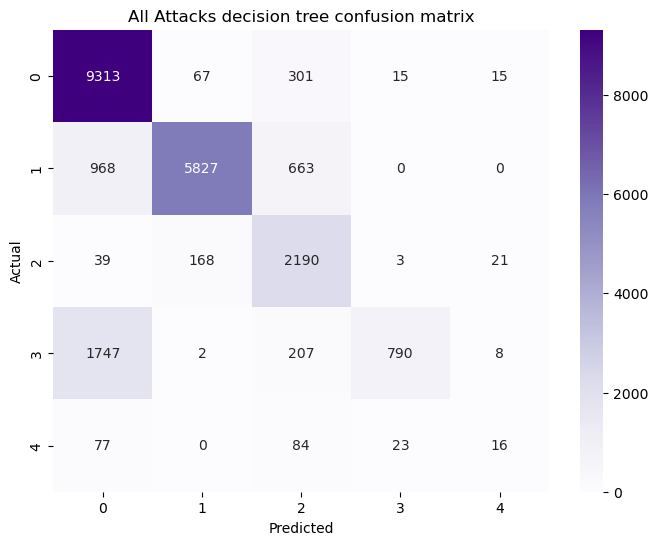

              precision    recall  f1-score   support

           0       0.77      0.96      0.85      9711
           1       0.96      0.78      0.86      7458
           2       0.64      0.90      0.75      2421
           3       0.95      0.29      0.44      2754
           4       0.27      0.08      0.12       200

    accuracy                           0.80     22544
   macro avg       0.72      0.60      0.60     22544
weighted avg       0.83      0.80      0.79     22544



In [66]:
Y_All_Pred = best_clf_all.predict(X_dataset_test_final)

cm_all = confusion_matrix(Y_dataset_test_final, Y_All_Pred)
print(cm_all)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Purples', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('All Attacks decision tree confusion matrix')
plt.show()

# Generate classification report
classification_rep = classification_report(Y_dataset_test_final, Y_All_Pred)
print(classification_rep)


### Decision tree evaluation for the whole dataset with feature selection

[[9288   93  282   29   19]
 [1051 6078  329    0    0]
 [  97  180 2072   51   21]
 [1745  290    8  542  169]
 [  49    0   84   26   41]]


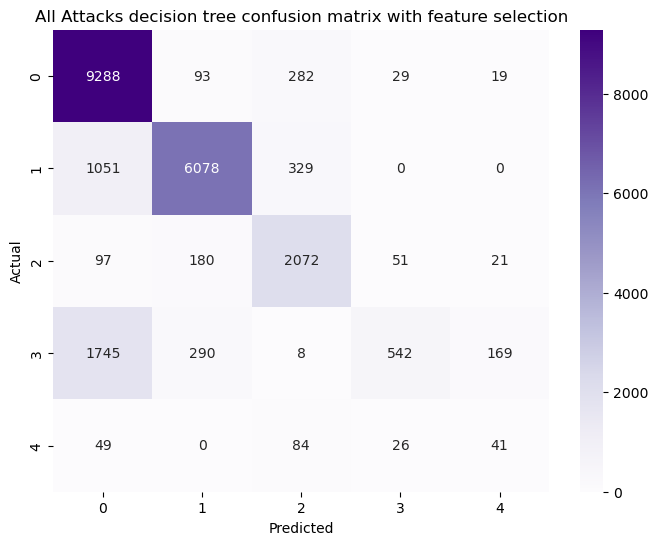

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      9711
           1       0.92      0.81      0.86      7458
           2       0.75      0.86      0.80      2421
           3       0.84      0.20      0.32      2754
           4       0.16      0.20      0.18       200

    accuracy                           0.80     22544
   macro avg       0.68      0.61      0.60     22544
weighted avg       0.81      0.80      0.78     22544



In [67]:
Y_All_Pred_features = best_clf_all_features.predict(X_NewAll_test)

cm_all = confusion_matrix(Y_dataset_test_final, Y_All_Pred_features)
print(cm_all)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Purples', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('All Attacks decision tree confusion matrix with feature selection')
plt.show()

classification_rep = classification_report(Y_dataset_test_final, Y_All_Pred_features)
print(classification_rep)

### Decision tree evaluation with gradient boosting for the whole dataset

[[9059   63  582    3    4]
 [1064 5987  407    0    0]
 [ 325  163 1933    0    0]
 [2072    0   12  659   11]
 [ 129    0   18   11   42]]


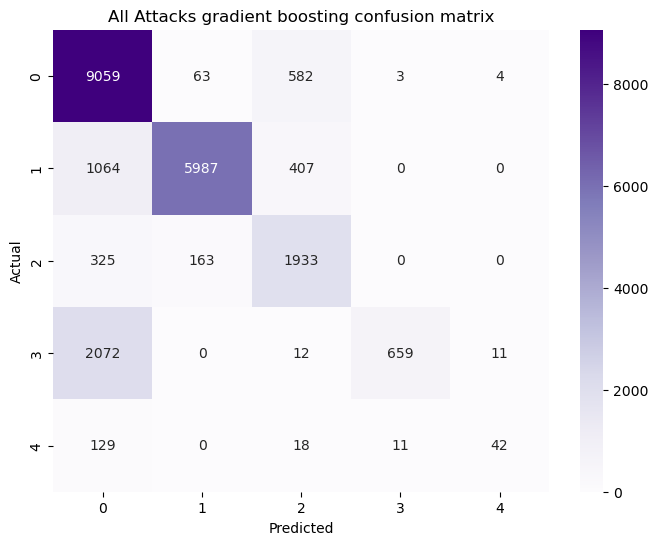

              precision    recall  f1-score   support

           0       0.72      0.93      0.81      9711
           1       0.96      0.80      0.88      7458
           2       0.65      0.80      0.72      2421
           3       0.98      0.24      0.38      2754
           4       0.74      0.21      0.33       200

    accuracy                           0.78     22544
   macro avg       0.81      0.60      0.62     22544
weighted avg       0.82      0.78      0.77     22544



In [68]:
Y_All_Pred = gb_clf_all.predict(X_dataset_test_final)

cm_all = confusion_matrix(Y_dataset_test_final, Y_All_Pred)
print(cm_all)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Purples', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('All Attacks gradient boosting confusion matrix')
plt.show()

classification_rep = classification_report(Y_dataset_test_final, Y_All_Pred)
print(classification_rep)

### Decision tree evaluation with gradient boosting for the whole dataset with feature selection

[[9404   89  207    6    5]
 [1268 5754  436    0    0]
 [ 541  164 1675   41    0]
 [2071    2    8  665    8]
 [  59    1  107   11   22]]


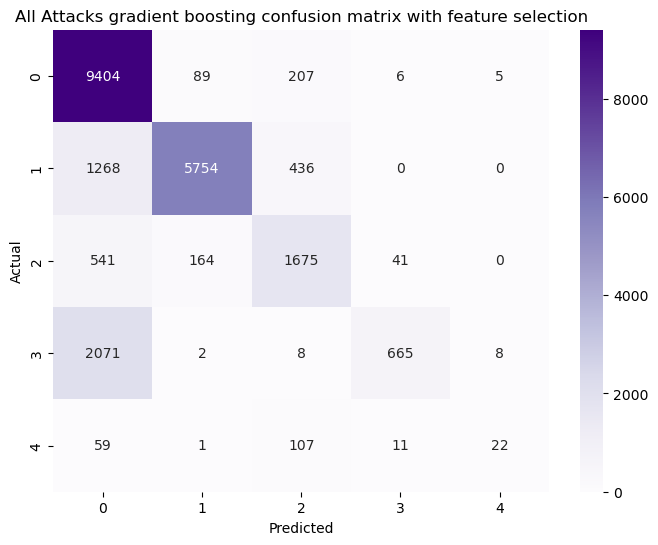

              precision    recall  f1-score   support

           0       0.70      0.97      0.82      9711
           1       0.96      0.77      0.85      7458
           2       0.69      0.69      0.69      2421
           3       0.92      0.24      0.38      2754
           4       0.63      0.11      0.19       200

    accuracy                           0.78     22544
   macro avg       0.78      0.56      0.59     22544
weighted avg       0.81      0.78      0.76     22544



In [69]:
Y_All_Pred_features = gb_clf_all_features.predict(X_NewAll_test)

cm_all = confusion_matrix(Y_dataset_test_final, Y_All_Pred_features)
print(cm_all)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Purples', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('All Attacks gradient boosting confusion matrix with feature selection')
plt.show()

classification_rep = classification_report(Y_dataset_test_final, Y_All_Pred_features)
print(classification_rep)

## Decision tree evaluation

### DoS Evaluation

Confusion Matrix for DoS:
[[9510  201]
 [1441 6017]]
Accuracy: 0.9043625138330712


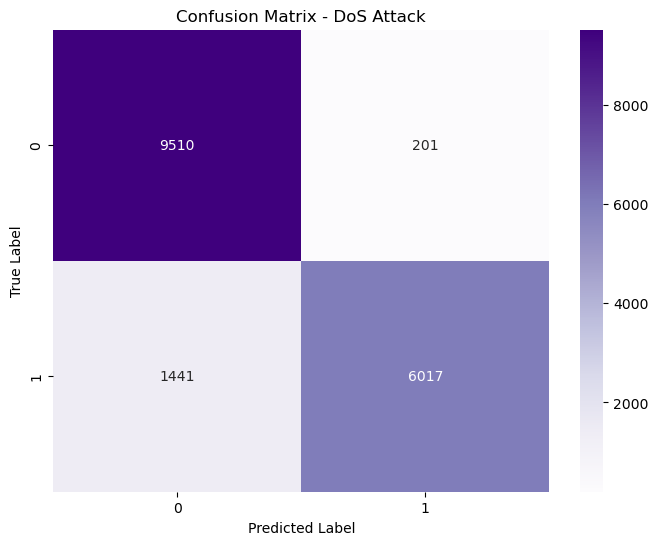

Classification Report for DoS:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      9711
           1       0.97      0.81      0.88      7458

    accuracy                           0.90     17169
   macro avg       0.92      0.89      0.90     17169
weighted avg       0.91      0.90      0.90     17169

AUC-ROC Score for DoS Prediction: 0.8933715139867181


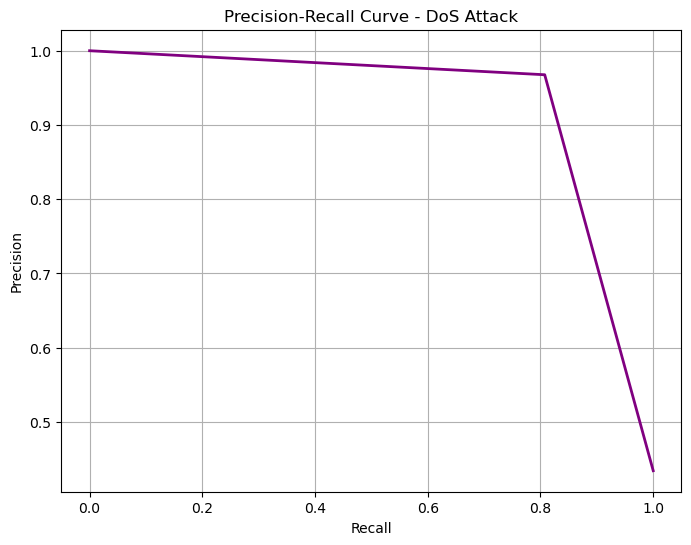

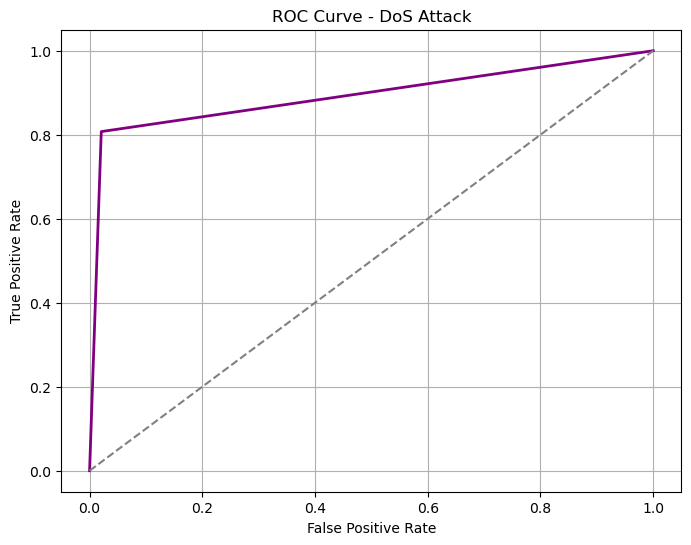

In [70]:
Y_DoS_pred=best_clf_DoS.predict(X_DoS_test)
# Create confusion matrix
cm_DoS = confusion_matrix(Y_DoS_test, Y_DoS_pred)
print("Confusion Matrix for DoS:")
print(cm_DoS)
accuracy_DoS = accuracy_score(Y_DoS_test, Y_DoS_pred)
print("Accuracy:", accuracy_DoS)

# Visualise the confusion matrix for clf_DoS
plt.figure(figsize=(8, 6))
sns.heatmap(cm_DoS, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - DoS Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for DoS:")
print(classification_report(Y_DoS_test, Y_DoS_pred))

# Calculate the predicted probabilities for the positive class (DoS attack)
Y_DoS_pred_proba = best_clf_DoS.predict_proba(X_DoS_test)[:, 1]

# Calculate the AUC-ROC score
auc_roc_score = roc_auc_score(Y_DoS_test, Y_DoS_pred_proba)
print("AUC-ROC Score for DoS Prediction:", auc_roc_score)

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_DoS_test, Y_DoS_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - DoS Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_DoS_test, Y_DoS_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DoS Attack')
plt.grid(True)
plt.show()


### DoS Evaluation with feature selection

Confusion Matrix for DoS with feature selection:
[[9516  195]
 [1310 6148]]
Accuracy: 0.9123420117653911


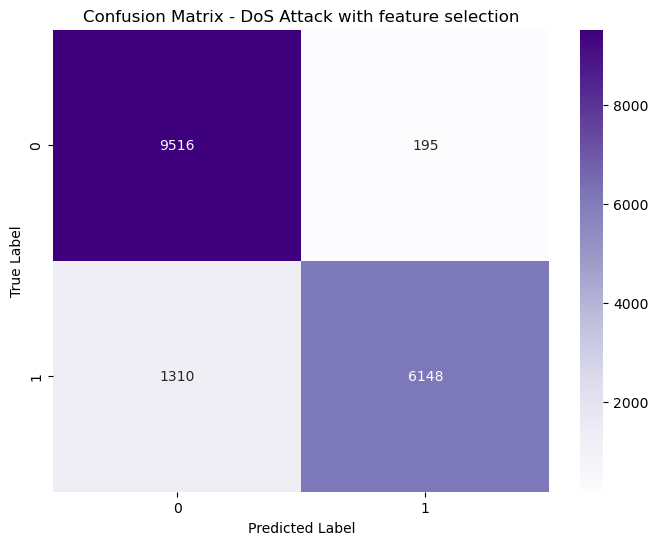

Classification Report for DoS:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      9711
           1       0.97      0.82      0.89      7458

    accuracy                           0.91     17169
   macro avg       0.92      0.90      0.91     17169
weighted avg       0.92      0.91      0.91     17169

AUC-ROC Score for DoS Prediction: 0.9024631645380127


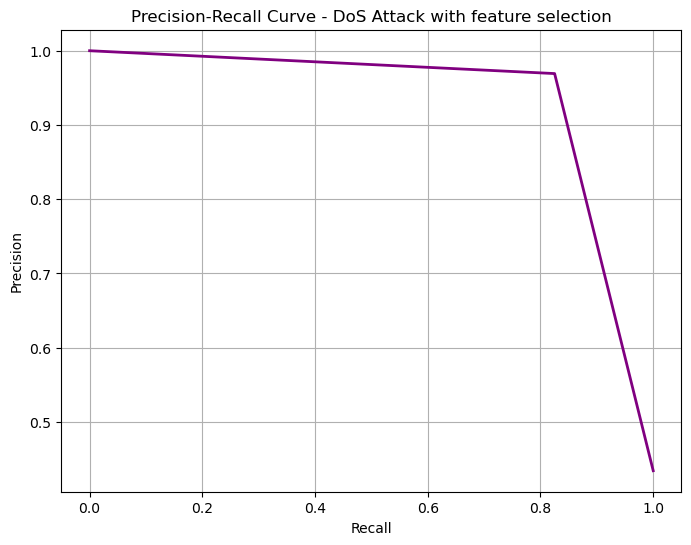

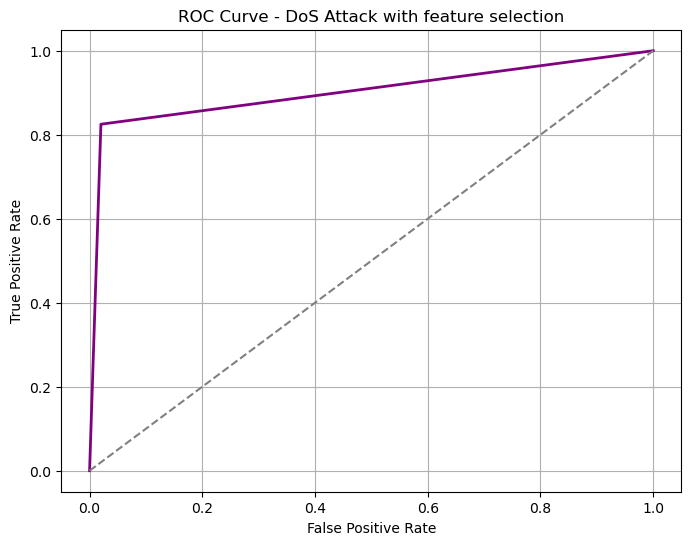

In [71]:
# Make predictions on the test set
Y_DoS_pred_features = best_clf_DoS_features.predict(X_newDoS_test)

# Create confusion matrix
cm_DoS = confusion_matrix(Y_DoS_test, Y_DoS_pred_features)
print("Confusion Matrix for DoS with feature selection:")
print(cm_DoS)

# Calculate accuracy
accuracy_DoS = accuracy_score(Y_DoS_test, Y_DoS_pred_features)
print("Accuracy:", accuracy_DoS)

# visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_DoS, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - DoS Attack with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for DoS:")
print(classification_report(Y_DoS_test, Y_DoS_pred_features))

# Calculate the predicted probabilities for the positive class (DoS attack)
# Ensure to use the transformed test set
Y_DoS_pred_proba = best_clf_DoS_features.predict_proba(X_newDoS_test)[:, 1]

# Calculate the AUC-ROC score
auc_roc_score = roc_auc_score(Y_DoS_test, Y_DoS_pred_proba)
print("AUC-ROC Score for DoS Prediction:", auc_roc_score)

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_DoS_test, Y_DoS_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - DoS Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_DoS_test, Y_DoS_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DoS Attack with feature selection')
plt.grid(True)
plt.show()


### DoS Evaluation using gradient boosting  

DoS attack gradient boosting Confusion Matrix:
[[9632   79]
 [1127 6331]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9711
           1       0.99      0.85      0.91      7458

    accuracy                           0.93     17169
   macro avg       0.94      0.92      0.93     17169
weighted avg       0.94      0.93      0.93     17169



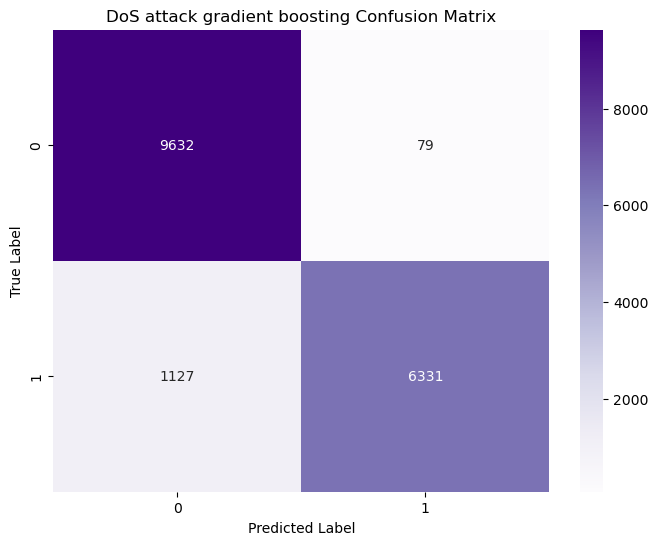

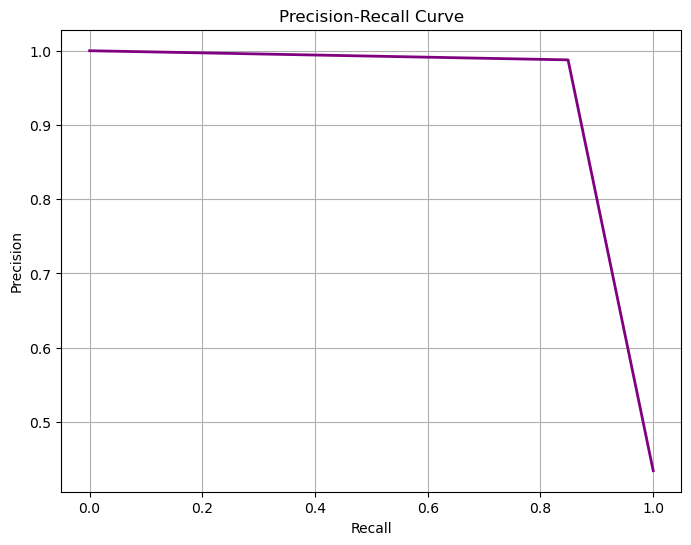

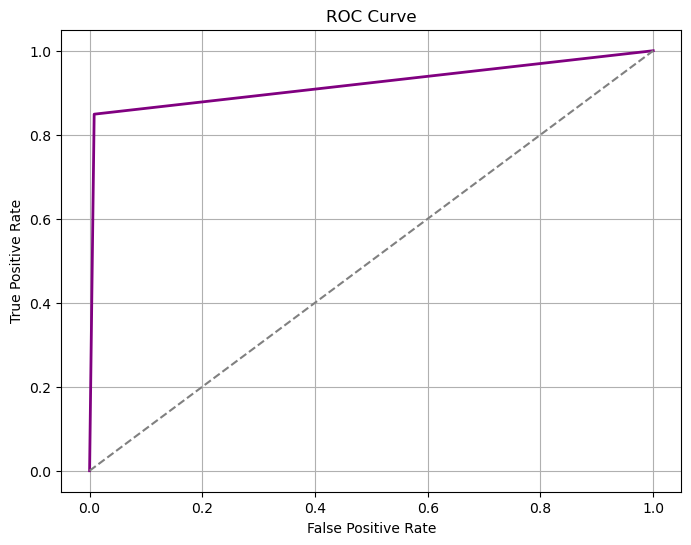

In [72]:
Y_DoS_pred = gb_clf_DoS.predict(X_DoS_test)

# Create confusion matrix
cm_DoS = confusion_matrix(Y_DoS_test, Y_DoS_pred)
print("DoS attack gradient boosting Confusion Matrix:")
print(cm_DoS)


# Classification report
classification_report_DoS = classification_report(Y_DoS_test, Y_DoS_pred)
print("Classification Report:")
print(classification_report_DoS)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_DoS, annot=True, fmt="d", cmap="Purples")
plt.title("DoS attack gradient boosting Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_DoS_test, Y_DoS_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_DoS_test, Y_DoS_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

### DoS Evaluation with feature selection using gradient boosting  

DoS attack gradient boosting Confusion Matrix with feature selection:
[[9639   72]
 [1136 6322]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      9711
           1       0.99      0.85      0.91      7458

    accuracy                           0.93     17169
   macro avg       0.94      0.92      0.93     17169
weighted avg       0.94      0.93      0.93     17169



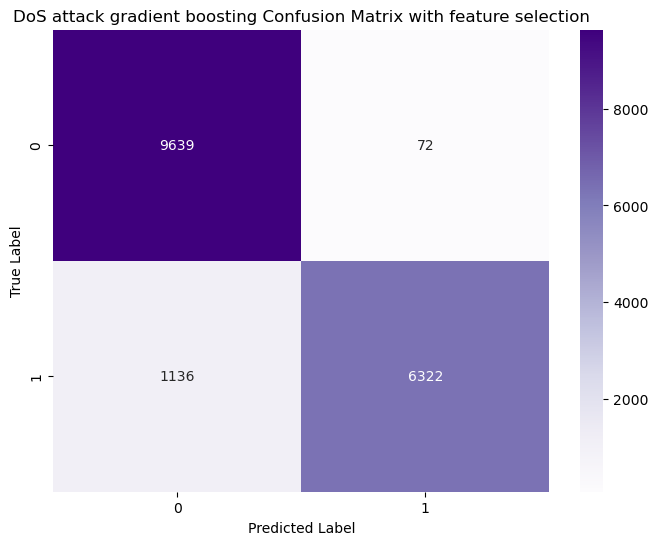

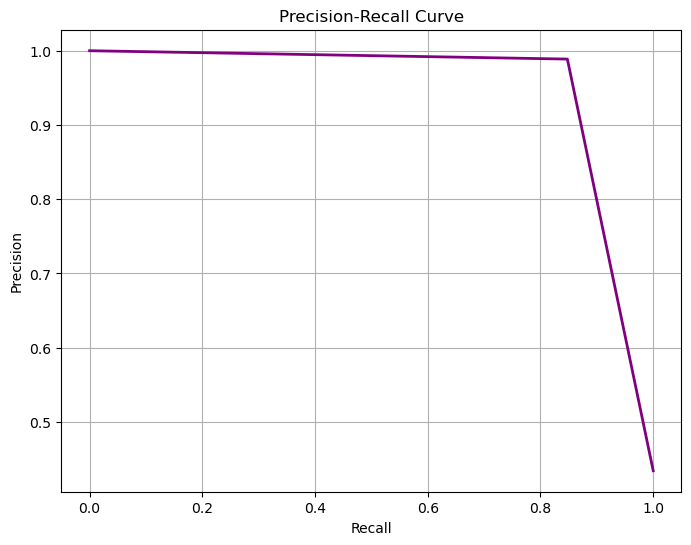

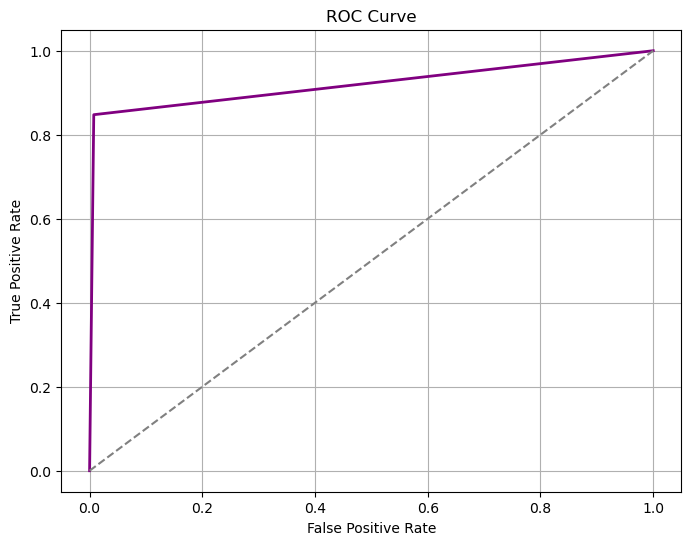

In [73]:
Y_DoS_pred_features = gb_clf_DoS_features.predict(X_newDoS_test)

# Create confusion matrix
cm_DoS = confusion_matrix(Y_DoS_test, Y_DoS_pred_features)
print("DoS attack gradient boosting Confusion Matrix with feature selection:")
print(cm_DoS)

# Generate classification report
classification_report_DoS = classification_report(Y_DoS_test, Y_DoS_pred_features)
print("Classification Report:")
print(classification_report_DoS)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_DoS, annot=True, fmt="d", cmap="Purples")
plt.title("DoS attack gradient boosting Confusion Matrix with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_DoS_test, Y_DoS_pred_features)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(Y_DoS_test, Y_DoS_pred_features)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

### Probe prediction

Confusion Matrix for Probe:
[[9354  357]
 [ 896 1525]]
Accuracy: 0.8967194197164523


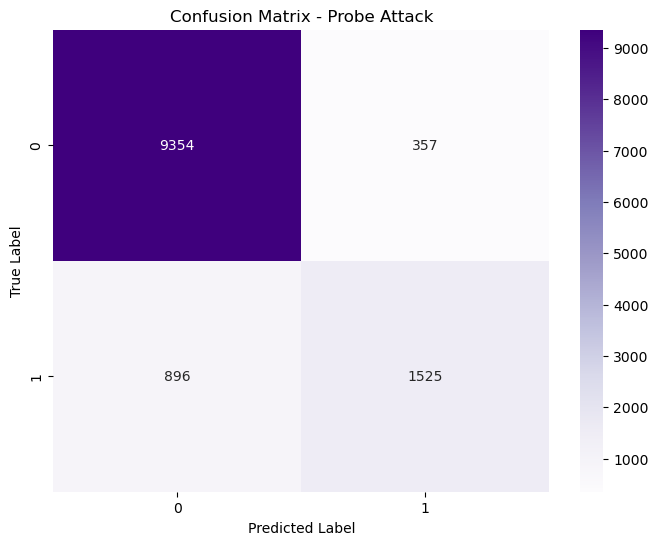

Classification Report for Probe:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      9711
           2       0.81      0.63      0.71      2421

    accuracy                           0.90     12132
   macro avg       0.86      0.80      0.82     12132
weighted avg       0.89      0.90      0.89     12132



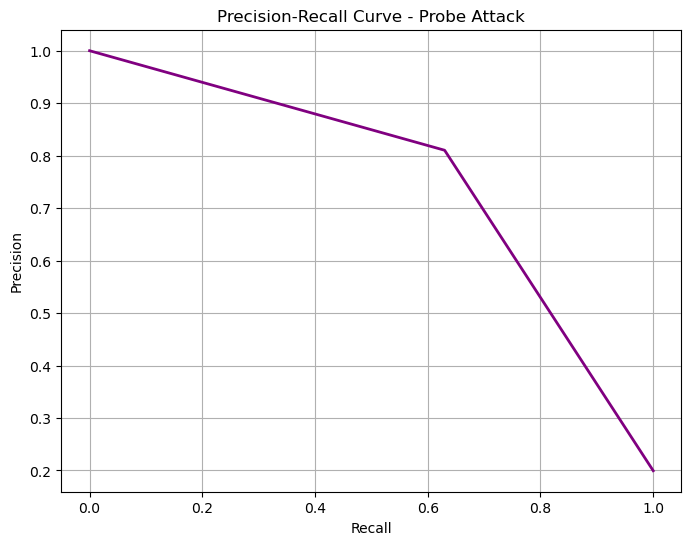

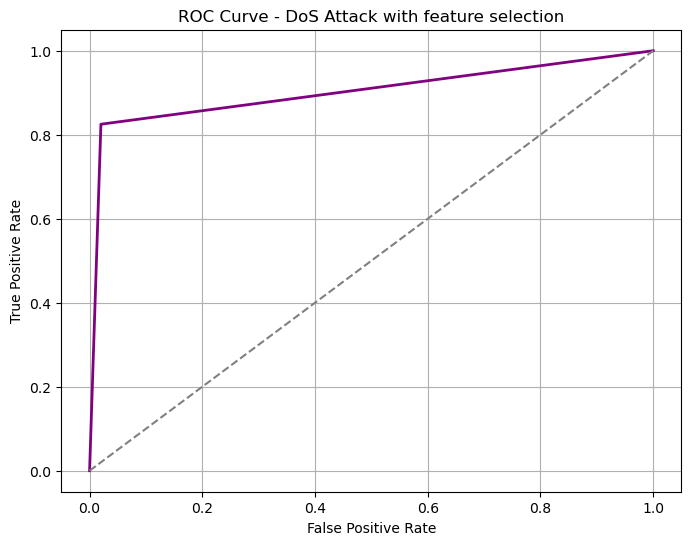

In [74]:
Y_Probe_pred=best_clf_Probe.predict(X_Probe_test)
# Create confusion matrix
cm_Probe = confusion_matrix(Y_Probe_test, Y_Probe_pred)
print("Confusion Matrix for Probe:")
print(cm_Probe)
accuracy_Probe = accuracy_score(Y_Probe_test, Y_Probe_pred)
print("Accuracy:", accuracy_Probe)

# Visualise the confusion matrix for clf_Probe
plt.figure(figsize=(8, 6))
sns.heatmap(cm_Probe, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - Probe Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for Probe:")
print(classification_report(Y_Probe_test, Y_Probe_pred))

# Calculate the predicted probabilities for the positive class (Probe attack)
Y_Probe_pred_proba = best_clf_Probe.predict_proba(X_Probe_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_Probe_test, Y_Probe_pred_proba, pos_label=2)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Probe Attack')
plt.grid(True)

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_DoS_test, Y_DoS_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DoS Attack with feature selection')
plt.grid(True)
plt.show()

### Probe prediction with feature selection

Confusion Matrix for Probe with features:
[[9356  355]
 [ 880 1541]]
Accuracy: 0.898203099241675


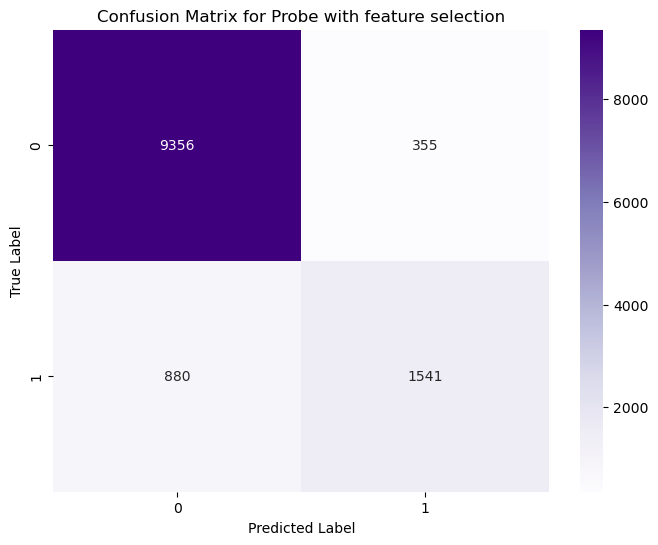

Classification Report for Probe with feature selection:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      9711
           2       0.81      0.64      0.71      2421

    accuracy                           0.90     12132
   macro avg       0.86      0.80      0.83     12132
weighted avg       0.89      0.90      0.89     12132



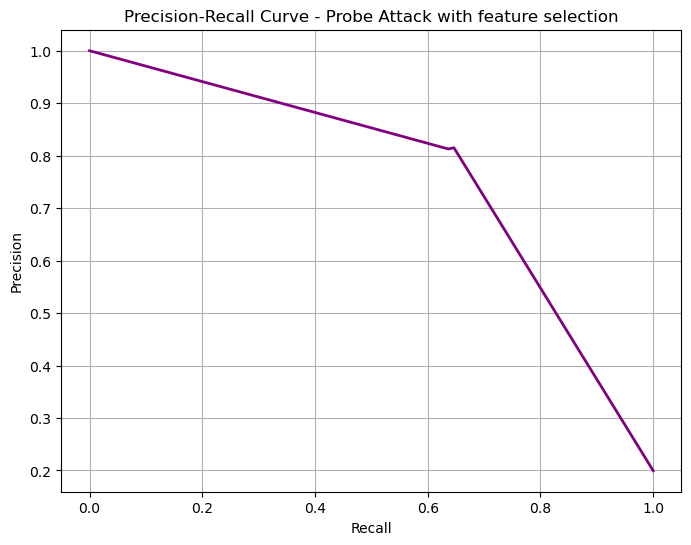

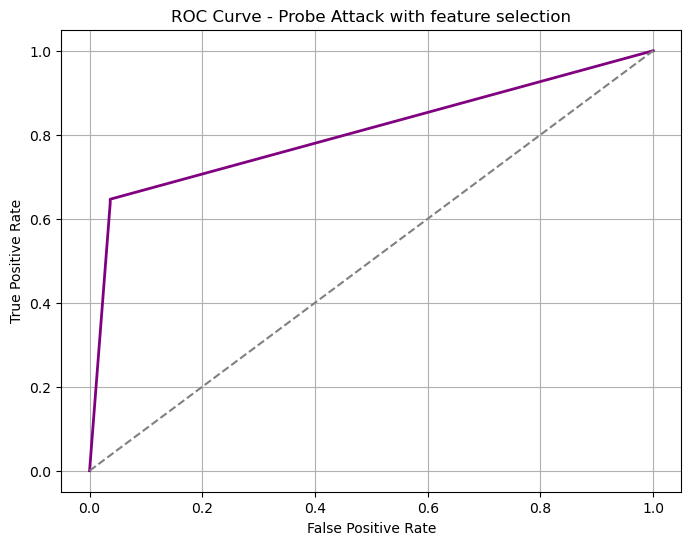

In [75]:
# Make predictions on the test set
Y_Probe_pred = best_clf_Probe_features.predict(X_newProbe_test)

# Create confusion matrix
cm_Probe = confusion_matrix(Y_Probe_test, Y_Probe_pred)
print("Confusion Matrix for Probe with features:")
print(cm_Probe)

# Calculate accuracy
accuracy_Probe = accuracy_score(Y_Probe_test, Y_Probe_pred)
print("Accuracy:", accuracy_Probe)

# visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_Probe, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix for Probe with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for Probe with feature selection:")
print(classification_report(Y_Probe_test, Y_Probe_pred))

# Calculate the predicted probabilities for the positive class (Probe attack)
# Ensure to use the transformed test set
Y_Probe_pred_proba = best_clf_Probe_features.predict_proba(X_newProbe_test)[:, 1]


# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_Probe_test, Y_Probe_pred_proba, pos_label=2)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Probe Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_Probe_test, Y_Probe_pred_proba, pos_label=2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Probe Attack with feature selection')
plt.grid(True)
plt.show()


### Probe Evaluation using gradient boosting  

Confusion Matrix:
[[9500  211]
 [ 582 1839]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      9711
           2       0.90      0.76      0.82      2421

    accuracy                           0.93     12132
   macro avg       0.92      0.87      0.89     12132
weighted avg       0.93      0.93      0.93     12132



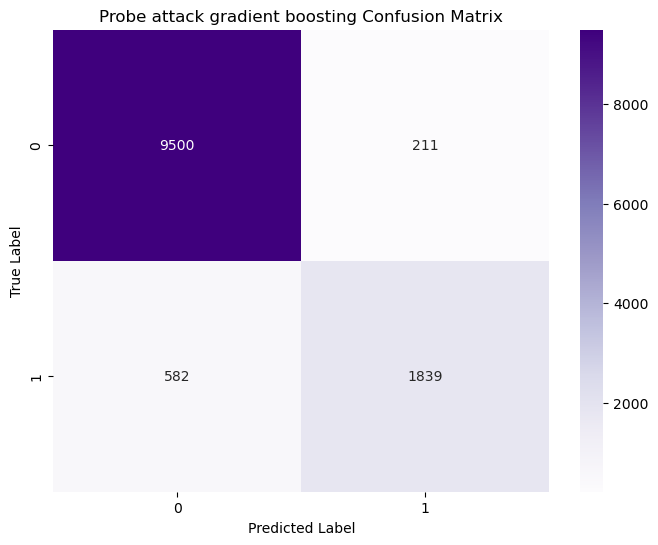

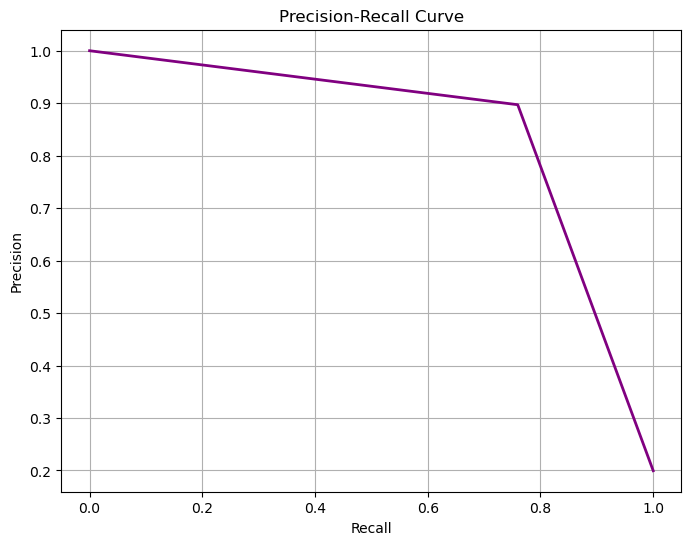

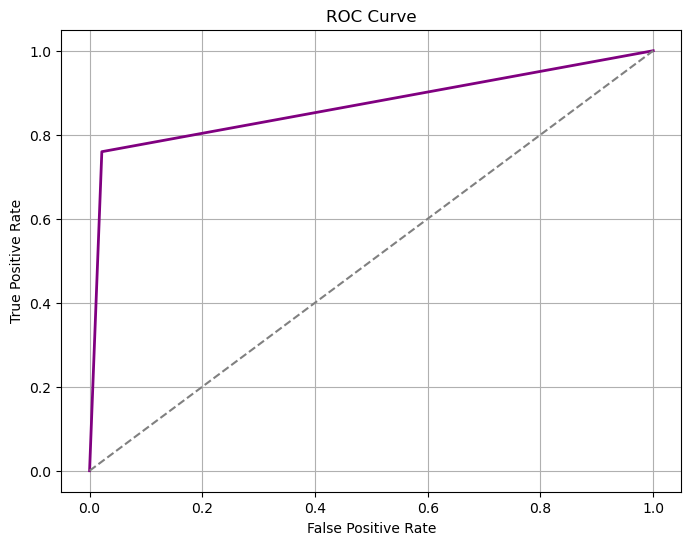

In [76]:
Y_Probe_pred = gb_clf_Probe.predict(X_Probe_test)

# Create confusion matrix
cm_Probe = confusion_matrix(Y_Probe_test, Y_Probe_pred)
print("Confusion Matrix:")
print(cm_Probe)

# Classification report
classification_report_Probe = classification_report(Y_Probe_test, Y_Probe_pred)
print("Classification Report:")
print(classification_report_Probe)

# visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_Probe, annot=True, fmt="d", cmap="Purples")
plt.title("Probe attack gradient boosting Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_Probe_test, Y_Probe_pred, pos_label=2)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(Y_Probe_test, Y_Probe_pred, pos_label=2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

### Probe Evaluation with feature selection using gradient boosting  

Confusion Matrix:
[[9366  345]
 [ 661 1760]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      9711
           2       0.84      0.73      0.78      2421

    accuracy                           0.92     12132
   macro avg       0.89      0.85      0.86     12132
weighted avg       0.91      0.92      0.91     12132



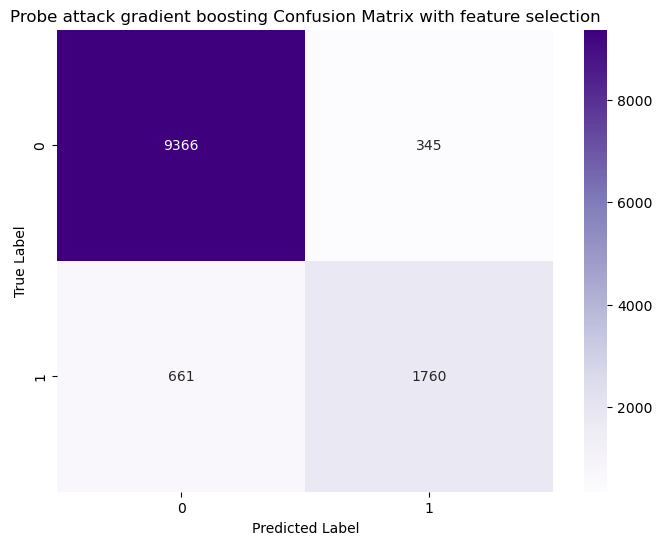

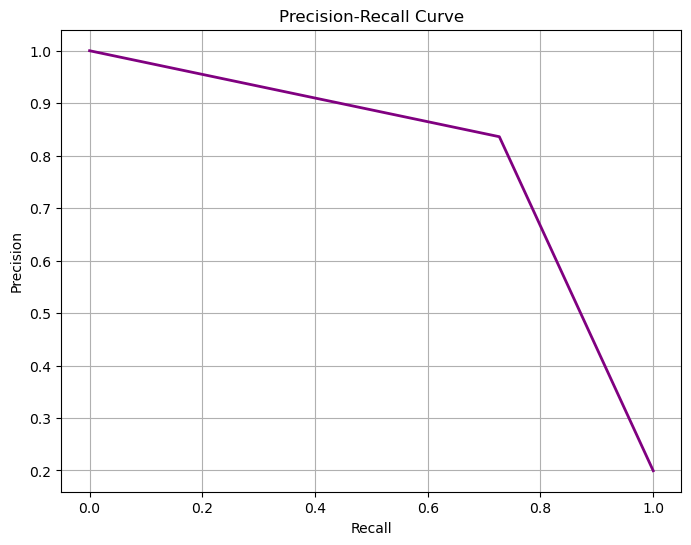

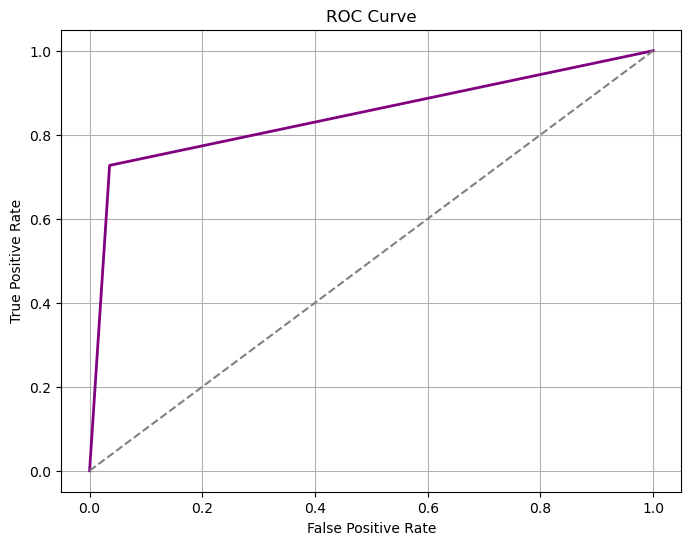

In [77]:
Y_Probe_pred_features = gb_clf_Probe_features.predict(X_newProbe_test)

# Create confusion matrix
cm_Probe = confusion_matrix(Y_Probe_test, Y_Probe_pred_features)
print("Confusion Matrix:")
print(cm_Probe)

# Generate classification report
classification_report_Probe = classification_report(Y_Probe_test, Y_Probe_pred_features)
print("Classification Report:")
print(classification_report_Probe)

# visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_Probe, annot=True, fmt="d", cmap="Purples")
plt.title("Probe attack gradient boosting Confusion Matrix with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_Probe_test, Y_Probe_pred_features, pos_label=2)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(Y_Probe_test, Y_Probe_pred_features, pos_label=2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()


### R2L prediction

Confusion Matrix for R2L:
[[9703    8]
 [2354  400]]
Accuracy: 0.8105094263939029


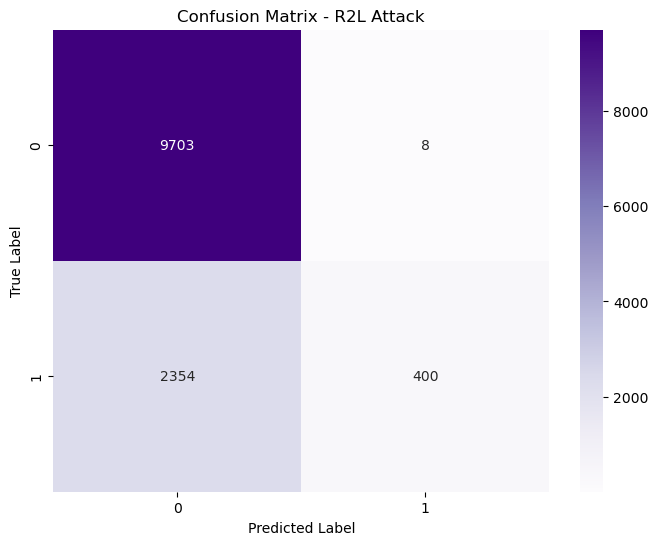

Classification Report for R2L:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      9711
           3       0.98      0.15      0.25      2754

    accuracy                           0.81     12465
   macro avg       0.89      0.57      0.57     12465
weighted avg       0.84      0.81      0.75     12465



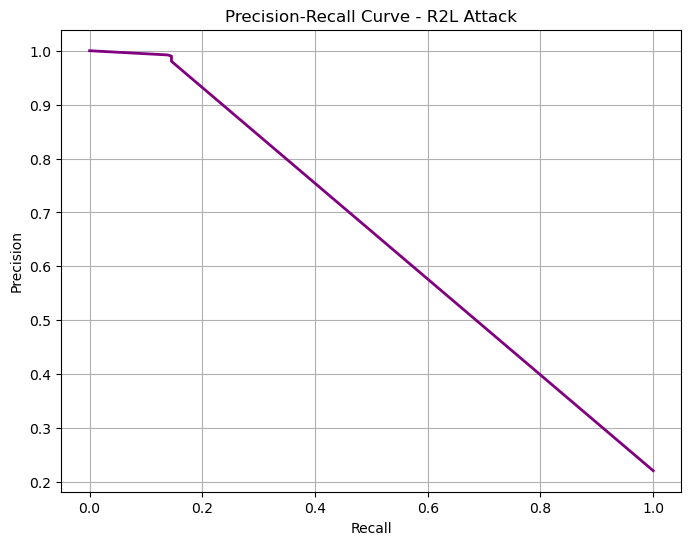

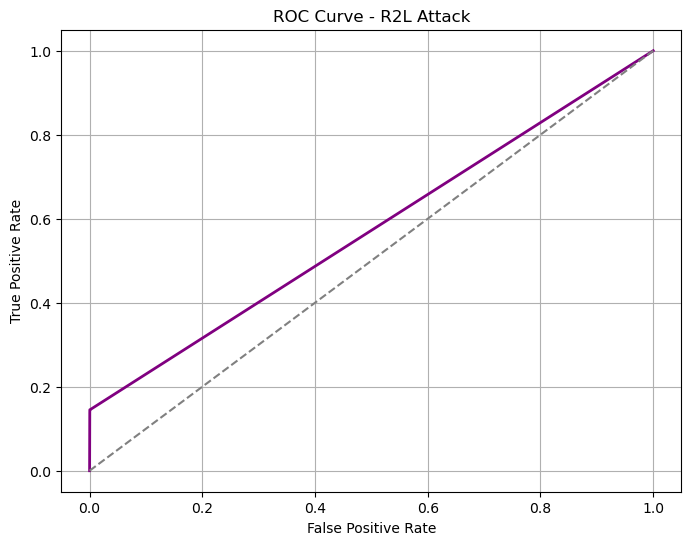

In [78]:
Y_R2L_pred=best_clf_R2L.predict(X_R2L_test)
# Create confusion matrix
cm_R2L = confusion_matrix(Y_R2L_test, Y_R2L_pred)
print("Confusion Matrix for R2L:")
print(cm_R2L)
accuracy_R2L = accuracy_score(Y_R2L_test, Y_R2L_pred)
print("Accuracy:", accuracy_R2L)

# Visualise the confusion matrix for clf_R2L
plt.figure(figsize=(8, 6))
sns.heatmap(cm_R2L, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - R2L Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for R2L:")
print(classification_report(Y_R2L_test, Y_R2L_pred))

# Calculate the predicted probabilities for the positive class (R2L attack)
Y_R2L_pred_proba = best_clf_R2L.predict_proba(X_R2L_test)[:, 1]


# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_R2L_test, Y_R2L_pred_proba, pos_label=3)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - R2L Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_R2L_test, Y_R2L_pred_proba, pos_label=3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - R2L Attack')
plt.grid(True)
plt.show()


### R2L prediction with feature selection

Confusion Matrix for R2L:
Predicted attacks     0    3
Actual attacks              
0                  9708    3
3                  1972  782
Accuracy: 0.8415563578018451


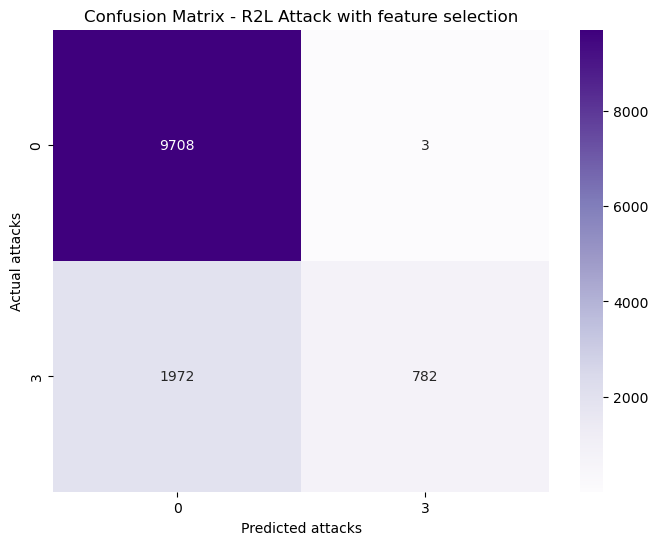

Classification Report for R2L:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      9711
           3       1.00      0.28      0.44      2754

    accuracy                           0.84     12465
   macro avg       0.91      0.64      0.67     12465
weighted avg       0.87      0.84      0.80     12465



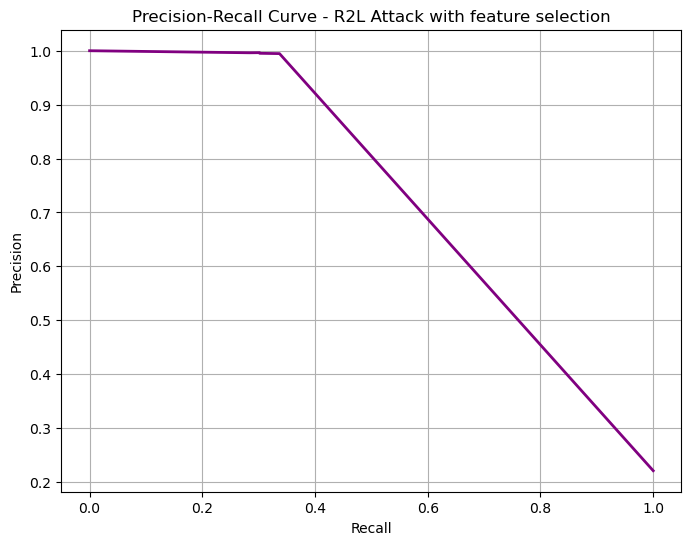

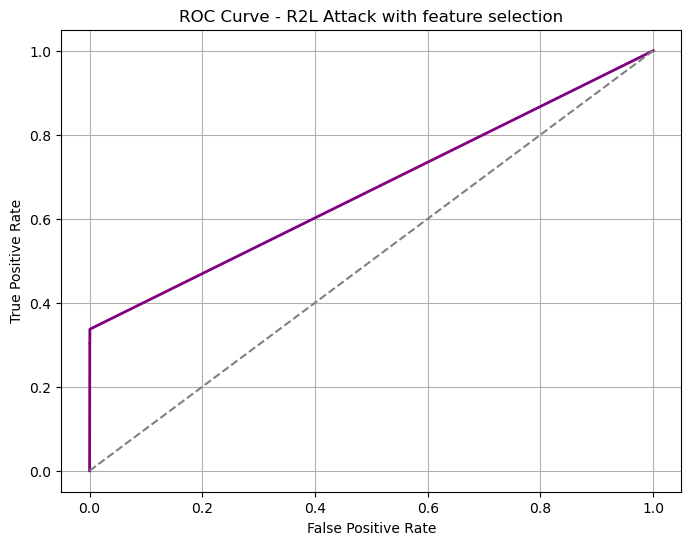

In [79]:
# Make predictions on the test set
Y_R2L_pred = best_clf_R2L_features.predict(X_newR2L_test)

# Create confusion matrix
cm_R2L = pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])
print("Confusion Matrix for R2L:")
print(cm_R2L)

# Calculate accuracy
accuracy_R2L = accuracy_score(Y_R2L_test, Y_R2L_pred)
print("Accuracy:", accuracy_R2L)

# visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_R2L, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - R2L Attack with feature selection")
plt.xlabel("Predicted attacks")
plt.ylabel("Actual attacks")
plt.show()

# Evaluate the performance of the model
print("Classification Report for R2L:")
print(classification_report(Y_R2L_test, Y_R2L_pred))

# Calculate the predicted probabilities for the positive class (R2L attack)
# Ensure to use the transformed test set
Y_R2L_pred_proba = best_clf_R2L_features.predict_proba(X_newR2L_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_R2L_test, Y_R2L_pred_proba, pos_label=3)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - R2L Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_R2L_test, Y_R2L_pred_proba, pos_label=3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - R2L Attack with feature selection')
plt.grid(True)
plt.show()


### R2L Evaluation using gradient boosting  

Confusion Matrix:
[[9709    2]
 [2397  357]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      9711
           3       0.99      0.13      0.23      2754

    accuracy                           0.81     12465
   macro avg       0.90      0.56      0.56     12465
weighted avg       0.84      0.81      0.74     12465



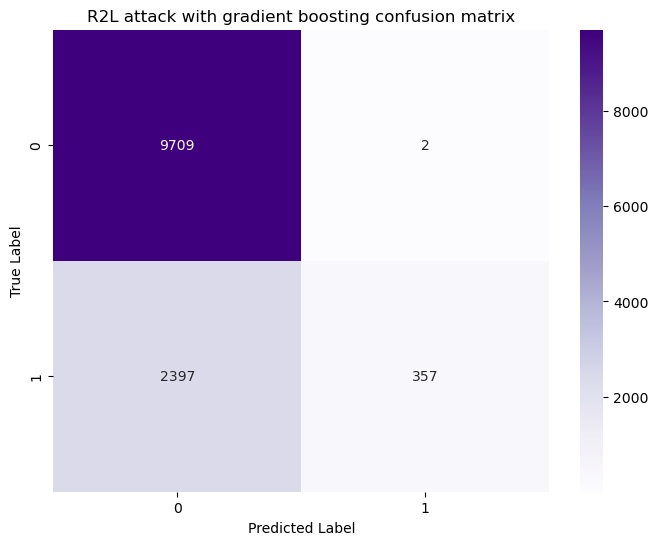

In [80]:
# Predictions
Y_R2L_pred = gb_clf_R2L.predict(X_R2L_test)

# Create confusion matrix
cm_R2L = confusion_matrix(Y_R2L_test, Y_R2L_pred)
print("Confusion Matrix:")
print(cm_R2L)

# Classification report
classification_report_R2L = classification_report(Y_R2L_test, Y_R2L_pred)
print("Classification Report:")
print(classification_report_R2L)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_R2L, annot=True, fmt="d", cmap="Purples")
plt.title("R2L attack with gradient boosting confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### R2L Evaluation with feature selection using gradient boosting  

Confusion Matrix:
[[9709    2]
 [2389  365]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      9711
           3       0.99      0.13      0.23      2754

    accuracy                           0.81     12465
   macro avg       0.90      0.57      0.56     12465
weighted avg       0.84      0.81      0.75     12465



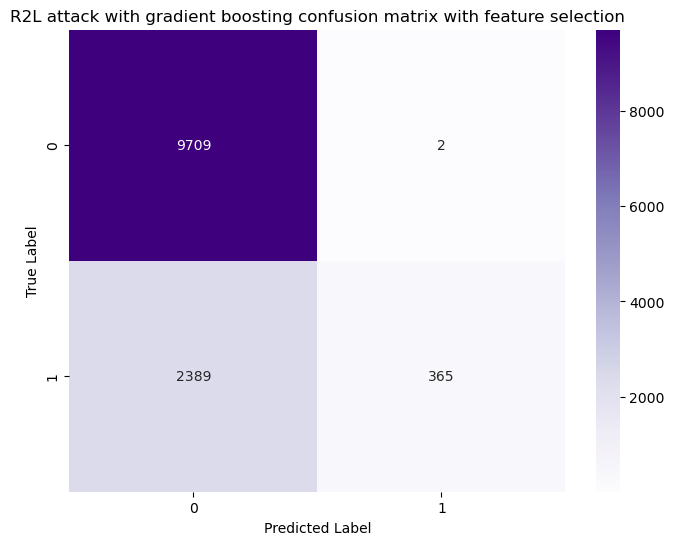

In [81]:
Y_R2L_pred_features = gb_clf_R2L_features.predict(X_newR2L_test)

# Create confusion matrix
cm_R2L = confusion_matrix(Y_R2L_test, Y_R2L_pred_features)
print("Confusion Matrix:")
print(cm_R2L)

# Generate classification report
classification_report_R2L = classification_report(Y_R2L_test, Y_R2L_pred_features)
print("Classification Report:")
print(classification_report_R2L)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_R2L, annot=True, fmt="d", cmap="Purples")
plt.title("R2L attack with gradient boosting confusion matrix with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### U2R prediction

Confusion Matrix for U2R:
[[9708    3]
 [ 193    7]]
Accuracy: 0.9802239935425285


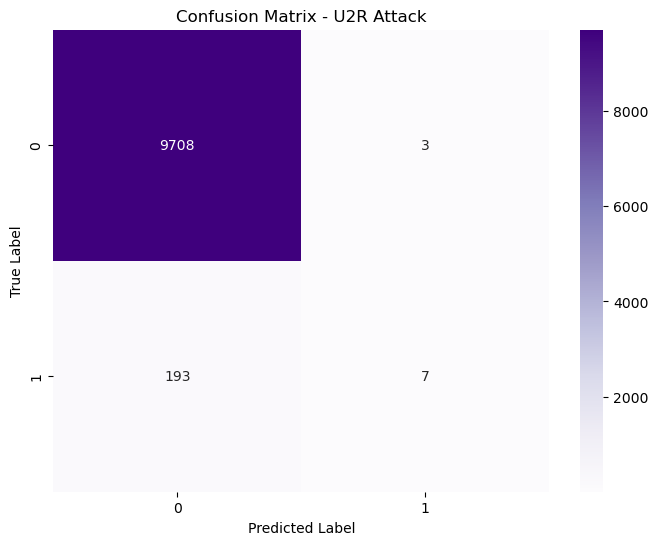

Classification Report for U2R:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9711
           4       0.70      0.04      0.07       200

    accuracy                           0.98      9911
   macro avg       0.84      0.52      0.53      9911
weighted avg       0.97      0.98      0.97      9911



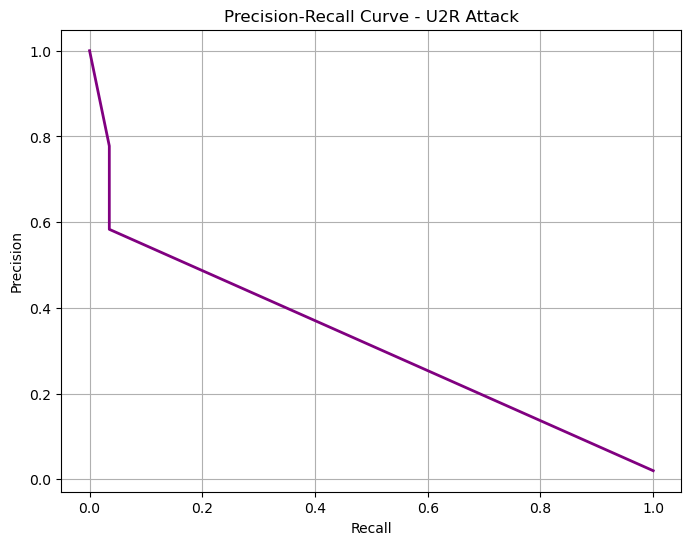

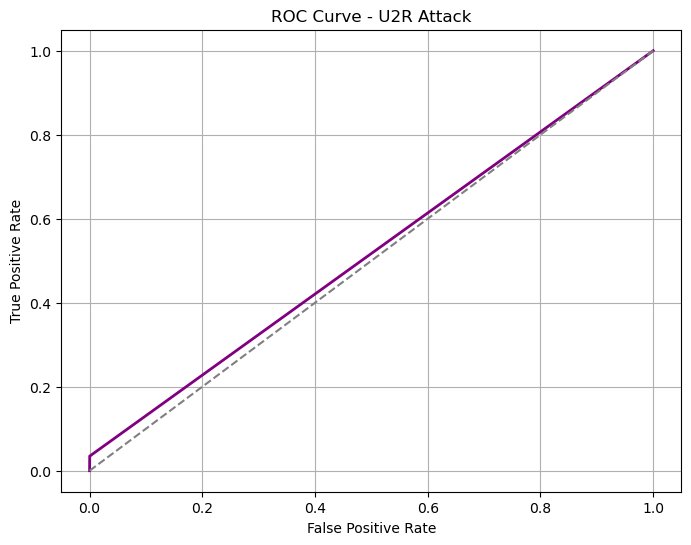

In [82]:
Y_U2R_pred=best_clf_U2R.predict(X_U2R_test)
# Create confusion matrix
cm_U2R = confusion_matrix(Y_U2R_test, Y_U2R_pred)
print("Confusion Matrix for U2R:")
print(cm_U2R)
accuracy_U2R = accuracy_score(Y_U2R_test, Y_U2R_pred)
print("Accuracy:", accuracy_U2R)

# Visualise the confusion matrix for clf_U2R
plt.figure(figsize=(8, 6))
sns.heatmap(cm_U2R, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - U2R Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for U2R:")
print(classification_report(Y_U2R_test, Y_U2R_pred))

# Calculate the predicted probabilities for the positive class (U2R attack)
Y_U2R_pred_proba = best_clf_U2R.predict_proba(X_U2R_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_U2R_test, Y_U2R_pred_proba, pos_label=4)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - U2R Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_U2R_test, Y_U2R_pred_proba, pos_label=4)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - U2R Attack')
plt.grid(True)
plt.show()


### U2R prediction with feature selection

Confusion Matrix for U2R:
[[9708    3]
 [ 187   13]]
Accuracy: 0.9808293814953083


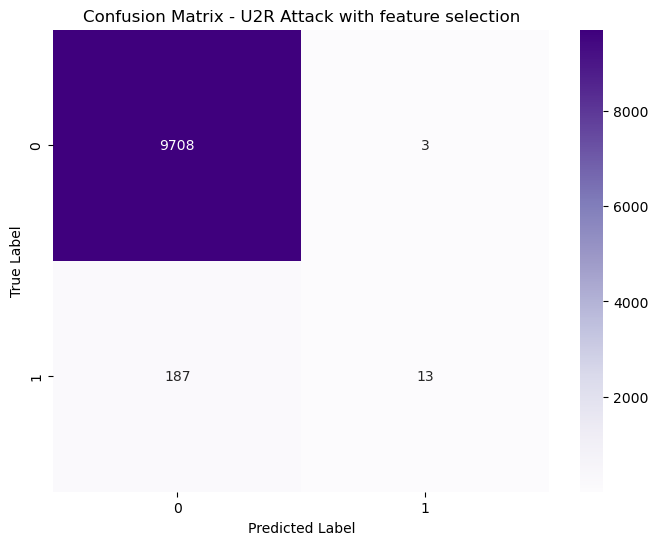

Classification Report for U2R:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9711
           4       0.81      0.07      0.12       200

    accuracy                           0.98      9911
   macro avg       0.90      0.53      0.56      9911
weighted avg       0.98      0.98      0.97      9911



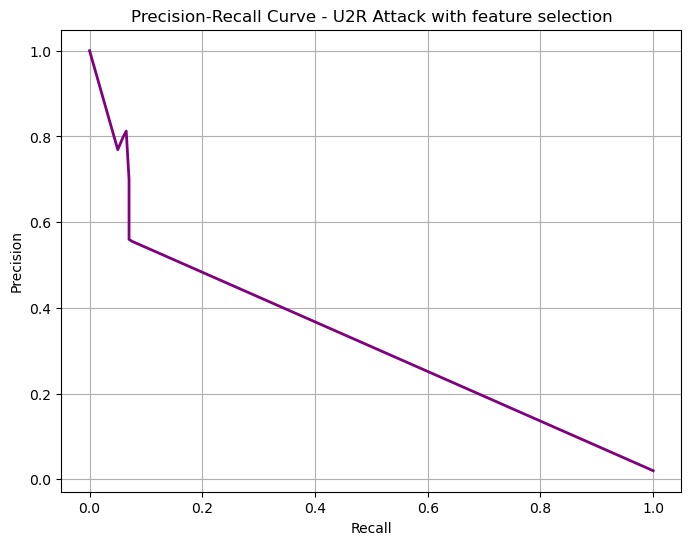

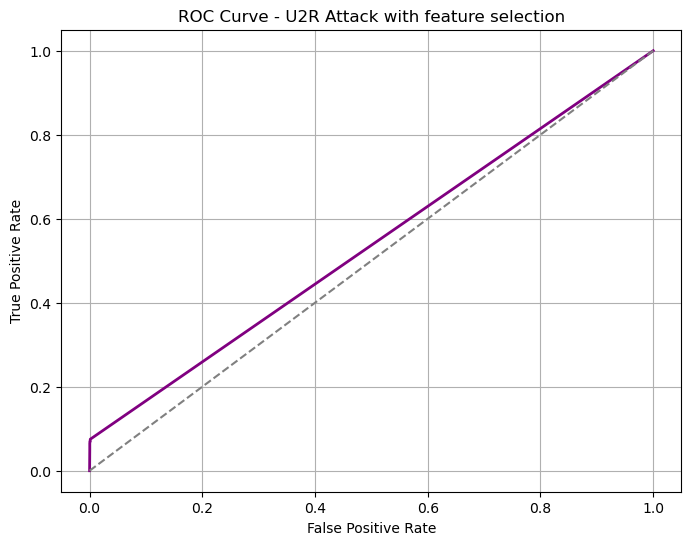

In [83]:
# Make predictions on the test set
Y_U2R_pred = best_clf_U2R_features.predict(X_newU2R_test)

# Create confusion matrix
cm_U2R = confusion_matrix(Y_U2R_test, Y_U2R_pred)
print("Confusion Matrix for U2R:")
print(cm_U2R)

# Calculate accuracy
accuracy_U2R = accuracy_score(Y_U2R_test, Y_U2R_pred)
print("Accuracy:", accuracy_U2R)

# visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_U2R, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - U2R Attack with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for U2R:")
print(classification_report(Y_U2R_test, Y_U2R_pred))

# Calculate the predicted probabilities for the positive class (U2R attack)
# Ensure to use the transformed test set
Y_U2R_pred_proba = best_clf_U2R_features.predict_proba(X_newU2R_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_U2R_test, Y_U2R_pred_proba, pos_label=4)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - U2R Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_U2R_test, Y_U2R_pred_proba, pos_label=4)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - U2R Attack with feature selection')
plt.grid(True)
plt.show()


### U2R Evaluation using gradient boosting  

Confusion Matrix:
[[9691   20]
 [ 175   25]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9711
           4       0.56      0.12      0.20       200

    accuracy                           0.98      9911
   macro avg       0.77      0.56      0.60      9911
weighted avg       0.97      0.98      0.97      9911



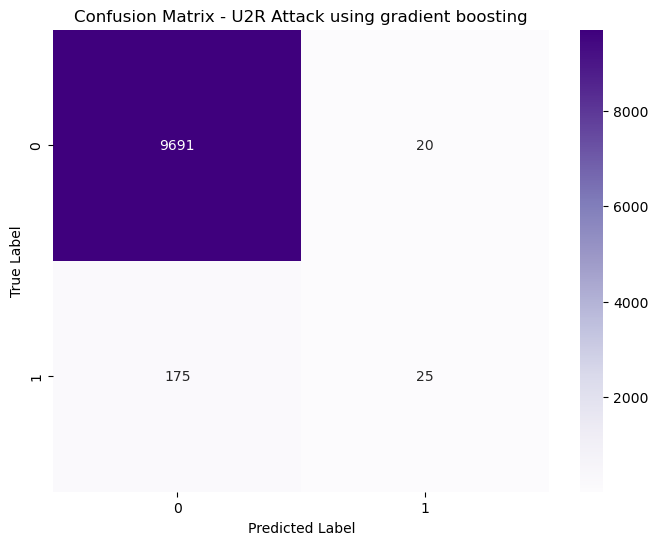

In [84]:
# Predictions
Y_U2R_pred = gb_clf_U2R.predict(X_U2R_test)

# Create confusion matrix
cm_U2R = confusion_matrix(Y_U2R_test, Y_U2R_pred)
print("Confusion Matrix:")
print(cm_U2R)

# Classification report
classification_report_U2R = classification_report(Y_U2R_test, Y_U2R_pred)
print("Classification Report:")
print(classification_report_U2R)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_U2R, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - U2R Attack using gradient boosting")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### U2R Evaluation with feature selection using gradient boosting  

Confusion Matrix:
[[9686   25]
 [ 185   15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9711
           4       0.38      0.07      0.12       200

    accuracy                           0.98      9911
   macro avg       0.68      0.54      0.56      9911
weighted avg       0.97      0.98      0.97      9911



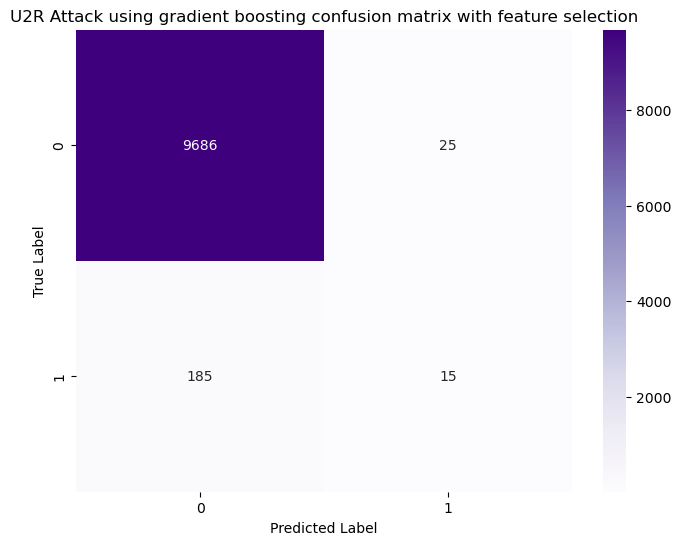

In [85]:
Y_U2R_pred_features = gb_clf_U2R_features.predict(X_newU2R_test)

# Create confusion matrix
cm_U2R = confusion_matrix(Y_U2R_test, Y_U2R_pred_features)
print("Confusion Matrix:")
print(cm_U2R)

# Generate classification report
classification_report_U2R = classification_report(Y_U2R_test, Y_U2R_pred_features)
print("Classification Report:")
print(classification_report_U2R)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_U2R, annot=True, fmt="d", cmap="Purples")
plt.title("U2R Attack using gradient boosting confusion matrix with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Decison tree evaluation summary

#### All Data:
Decent overall performance with high precision and recall for class 0 and 1. However, significantly lower recall for class 3 and especially low precision and recall for class 4, indicating a struggle in correctly identifying and classifying these classes.
Macro average is brought down by poor performance on class 4, but weighted average is higher due to the majority of data points being in classes 0 and 1.

#### All Data with Feature Selection:
Slight improvements in precision and recall for classes 2 and 4. This indicates feature selection helped the model to better identify these classes, but still struggles with class 3 and 4.
Overall accuracy remains the same, but macro avg improved slightly indicating better distribution of performance across classes.

### Gradient Boosting evaluation summary

#### All Data:
Similar to Decision Tree, shows good performance for class 0 and 1, but struggles with class 3 and 4. Class 4, in particular, has higher precision but very low recall, indicating many false negatives.
Weighted avg is relatively high due to good performance on the majority classes, but macro avg is lower due to poor performance on minority classes.

#### All Data with Feature Selection:
Performance on class 2 improved, but class 3 and 4 still have low recall. This indicates the model's inability to identify these classes well, even with feature selection.
Overall accuracy and weighted avg slightly decreased, and macro avg is lower, indicating feature selection did not improve model performance significantly.

## Random_forest_code

In [86]:
# Random Forest
# Time taken: 6 hours

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced','balanced_subsample', None]
}

# Create the classifier
clf_rfeDoS = RandomForestClassifier(n_jobs=-1)
clf_rfeDoS_features = RandomForestClassifier(n_jobs=-1)
clf_rfeProbe = RandomForestClassifier(n_jobs=-1)
clf_rfeProbe_features = RandomForestClassifier(n_jobs=-1)
clf_rfeR2L = RandomForestClassifier(n_jobs=-1)
clf_rfeR2L_features = RandomForestClassifier(n_jobs=-1)
clf_rfeU2R = RandomForestClassifier(n_jobs=-1)
clf_rfeU2R_features = RandomForestClassifier(n_jobs=-1)
clf_rfe_All = RandomForestClassifier(n_jobs=-1)
clf_rfe_All_features = RandomForestClassifier(n_jobs=-1)

stratified_k_fold = StratifiedKFold(n_splits=5)

# Create GridSearchCV
grid_search_DoS = GridSearchCV(clf_rfeDoS, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_DoS_features = GridSearchCV(clf_rfeDoS_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_Probe = GridSearchCV(clf_rfeProbe, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_Probe_features = GridSearchCV(clf_rfeProbe_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_R2L = GridSearchCV(clf_rfeR2L, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_R2L_features = GridSearchCV(clf_rfeR2L_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_U2R = GridSearchCV(clf_rfeU2R, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_U2R_features = GridSearchCV(clf_rfeU2R_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_all = GridSearchCV(clf_rfe_All, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_all_features = GridSearchCV(clf_rfe_All_features, param_grid, cv=stratified_k_fold, n_jobs=-1)

# Fit the grid search to the data
grid_search_DoS.fit(X_DoS, Y_DoS)
grid_search_DoS_features.fit(X_newDoS_rfe, Y_DoS)
grid_search_Probe.fit(X_Probe, Y_Probe)
grid_search_Probe_features.fit(X_newProbe_rfe, Y_Probe)
grid_search_R2L.fit(X_R2L, Y_R2L)
grid_search_R2L_features.fit(X_newR2L_rfe, Y_R2L)
grid_search_U2R.fit(X_U2R, Y_U2R)
grid_search_U2R_features.fit(X_newU2R_rfe, Y_U2R)
grid_search_all.fit(X_dataset_train_final, Y_dataset_train_final)
grid_search_all_features.fit(X_NewAll, Y_dataset_train_final)

# Print the best parameters
print("Best parameters for DoS classifier:", grid_search_DoS.best_params_)
print("Best parameters for DoS classifier with features:", grid_search_DoS_features.best_params_)
print("Best parameters for Probe classifier:", grid_search_Probe.best_params_)
print("Best parameters for Probe classifier with features:", grid_search_Probe_features.best_params_)
print("Best parameters for R2L classifier:", grid_search_R2L.best_params_)
print("Best parameters for R2L classifier with features:", grid_search_R2L_features.best_params_)
print("Best parameters for U2R classifier:", grid_search_U2R.best_params_)
print("Best parameters for U2R classifier with features:", grid_search_U2R_features.best_params_)
print("Best parameters for all classifier:", grid_search_all.best_params_)
print("Best parameters for all classifier with features:", grid_search_all_features.best_params_)

# Use the best estimator for further predictions
clf_rfeDoS_best = grid_search_DoS.best_estimator_
clf_rfeDoS_features_best = grid_search_DoS_features.best_estimator_
clf_rfeProbe_best = grid_search_Probe.best_estimator_
clf_rfeProbe_features_best = grid_search_Probe_features.best_estimator_
clf_rfeR2L_best = grid_search_R2L.best_estimator_
clf_rfeR2L_features_best = grid_search_R2L_features.best_estimator_
clf_rfeU2R_best = grid_search_U2R.best_estimator_
clf_rfeU2R_features_best = grid_search_U2R_features.best_estimator_
clf_rfeAll_best = grid_search_all.best_estimator_
clf_rfeAll_features_best = grid_search_all_features.best_estimator_

Best parameters for DoS classifier: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best parameters for DoS classifier with features: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for Probe classifier: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best parameters for Probe classifier with features: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for R2L classifier: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best parameters for R2L classifier with features: {'class_weight': None, 'cr

## Random_Forest_prediction_and_evaluation

### Random Forest whole dataset prediction and evaluation

[[9428   69  205    4    5]
 [1618 5775   65    0    0]
 [ 502  162 1756    1    0]
 [2609    0    6  132    7]
 [ 159    0   18    7   16]]


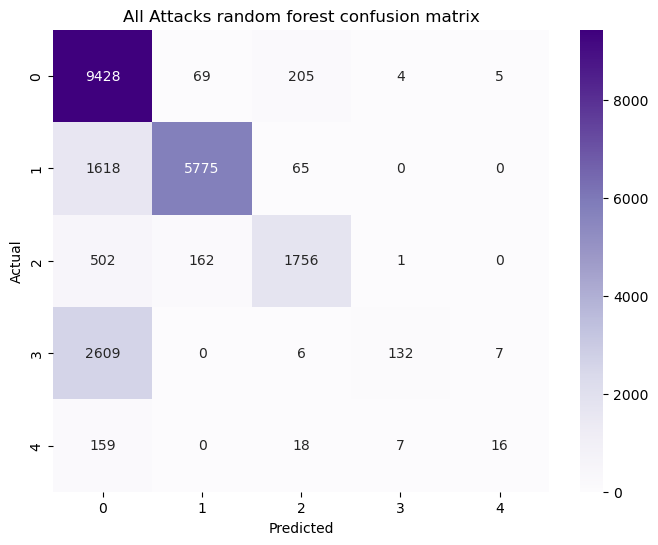

              precision    recall  f1-score   support

           0       0.66      0.97      0.78      9711
           1       0.96      0.77      0.86      7458
           2       0.86      0.73      0.79      2421
           3       0.92      0.05      0.09      2754
           4       0.57      0.08      0.14       200

    accuracy                           0.76     22544
   macro avg       0.79      0.52      0.53     22544
weighted avg       0.81      0.76      0.72     22544



In [87]:
Y_All_Pred = clf_rfeAll_best.predict(X_dataset_test_final)

cm_all = confusion_matrix(Y_dataset_test_final, Y_All_Pred)
print(cm_all)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Purples', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('All Attacks random forest confusion matrix')
plt.show()

classification_rep = classification_report(Y_dataset_test_final, Y_All_Pred)
print(classification_rep)

### Random Forest whole dataset with feature selection prediction and evaluation

[[9404   89  207    6    5]
 [1268 5754  436    0    0]
 [ 541  164 1675   41    0]
 [2071    2    8  665    8]
 [  59    1  107   11   22]]


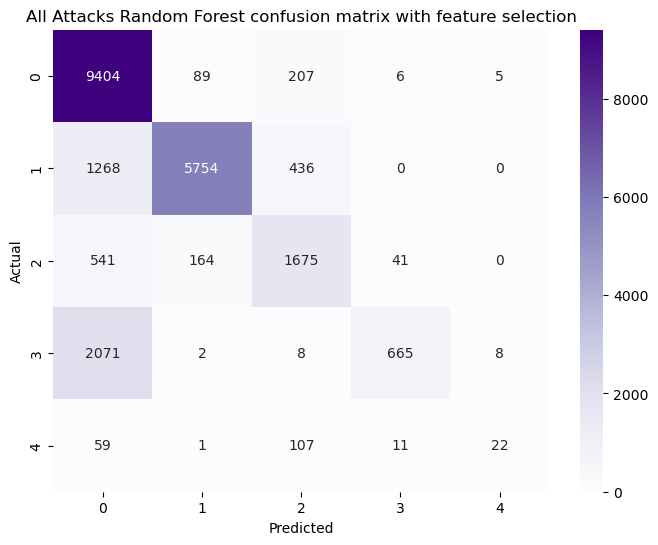

              precision    recall  f1-score   support

           0       0.70      0.97      0.82      9711
           1       0.96      0.77      0.85      7458
           2       0.69      0.69      0.69      2421
           3       0.92      0.24      0.38      2754
           4       0.63      0.11      0.19       200

    accuracy                           0.78     22544
   macro avg       0.78      0.56      0.59     22544
weighted avg       0.81      0.78      0.76     22544



In [88]:
Y_All_Pred = gb_clf_all_features.predict(X_NewAll_test)

cm_all = confusion_matrix(Y_dataset_test_final, Y_All_Pred)
print(cm_all)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Purples', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('All Attacks Random Forest confusion matrix with feature selection')
plt.show()

classification_rep = classification_report(Y_dataset_test_final, Y_All_Pred)
print(classification_rep)

### DoS Evaluation

Confusion Matrix:
[[9625   86]
 [1653 5805]]


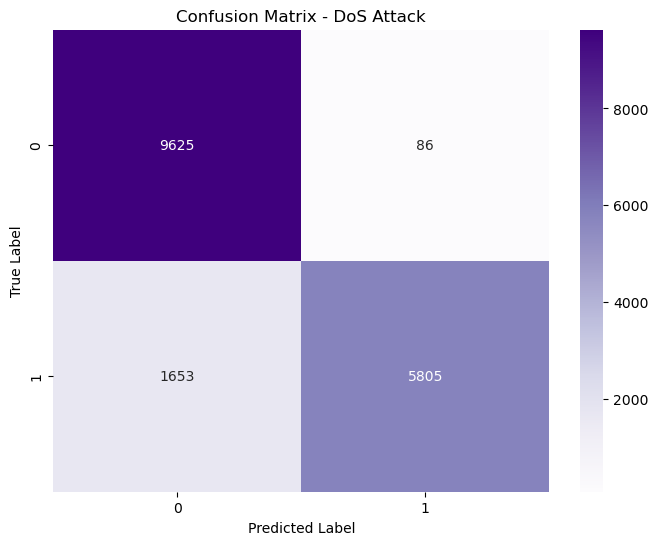

Classification Report for DoS:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      9711
           1       0.99      0.78      0.87      7458

    accuracy                           0.90     17169
   macro avg       0.92      0.88      0.89     17169
weighted avg       0.91      0.90      0.90     17169



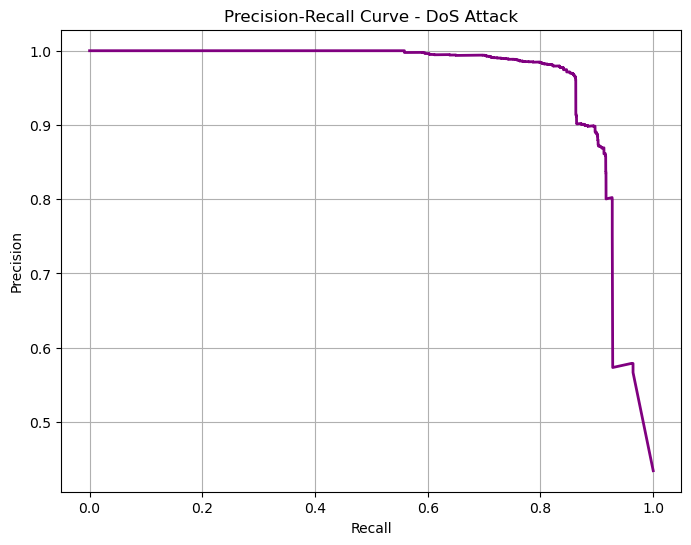

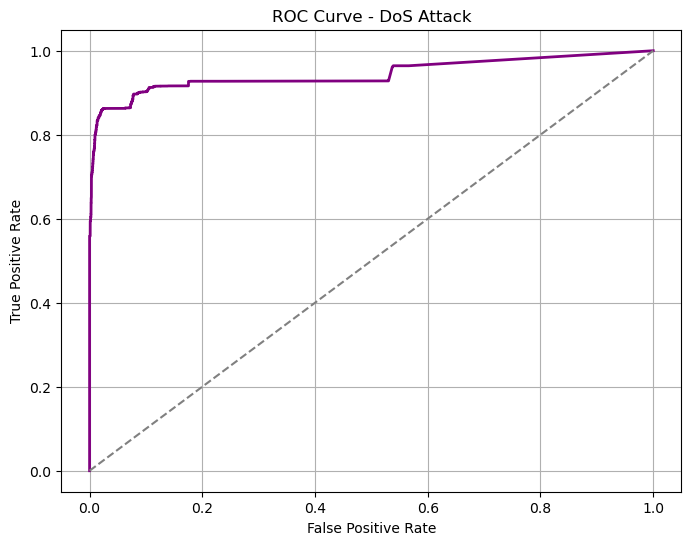

In [89]:
# Predict the labels for the test data using the random tree model
Y_DoS_rfepred = clf_rfeDoS_best.predict(X_DoS_test)

# Create the confusion matrix
cm = confusion_matrix(Y_DoS_test, Y_DoS_rfepred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - DoS Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the Random Forest model
print("Classification Report for DoS:")
print(classification_report(Y_DoS_test, Y_DoS_rfepred))

# Calculate the predicted probabilities for the positive class (DoS attack)
Y_DoS_rfepred_proba = clf_rfeDoS_best.predict_proba(X_DoS_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_DoS_test, Y_DoS_rfepred_proba, pos_label=1)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - DoS Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_DoS_test, Y_DoS_rfepred_proba, pos_label=1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DoS Attack')
plt.grid(True)
plt.show()


### DoS Evaluation with feature selection

Confusion Matrix:
[[9579  132]
 [1942 5516]]


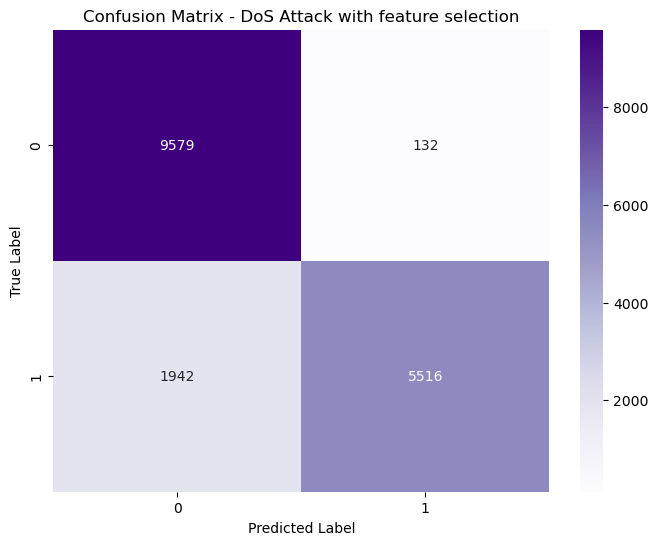

Classification Report for DoS with feature selection:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      9711
           1       0.98      0.74      0.84      7458

    accuracy                           0.88     17169
   macro avg       0.90      0.86      0.87     17169
weighted avg       0.89      0.88      0.88     17169



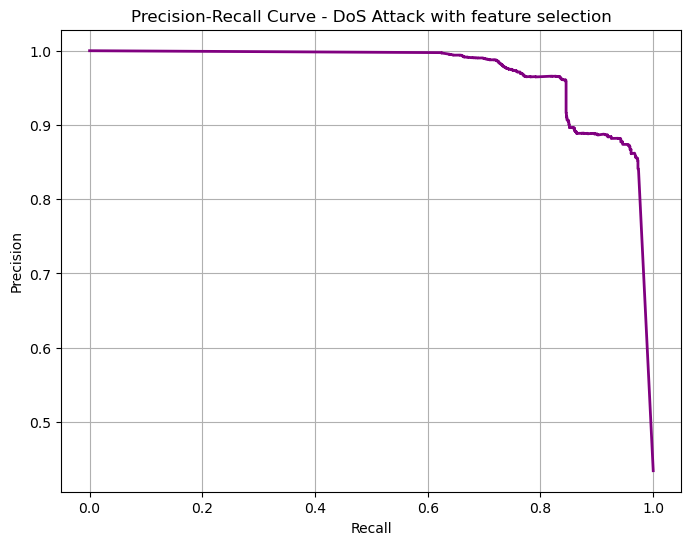

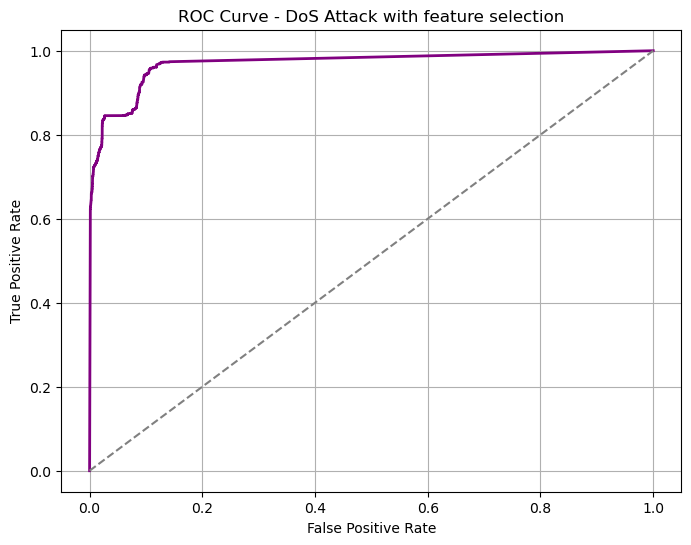

In [90]:
# Predict the labels for the test data using the random tree model
Y_DoS_rfepred_features = clf_rfeDoS_features_best.predict(X_newDoS_test_rfe)

# Create the confusion matrix
cm = confusion_matrix(Y_DoS_test, Y_DoS_rfepred_features)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - DoS Attack with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the Random Forest model
print("Classification Report for DoS with feature selection:")
print(classification_report(Y_DoS_test, Y_DoS_rfepred_features))

# Calculate the predicted probabilities for the positive class (DoS attack)
Y_DoS_rfepred_proba_features = clf_rfeDoS_features_best.predict_proba(X_newDoS_test_rfe)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_DoS_test, Y_DoS_rfepred_proba_features, pos_label=1)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - DoS Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_DoS_test, Y_DoS_rfepred_proba_features, pos_label=1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DoS Attack with feature selection')
plt.grid(True)
plt.show()


### Probe prediction

Confusion Matrix:
[[9505  206]
 [ 976 1445]]


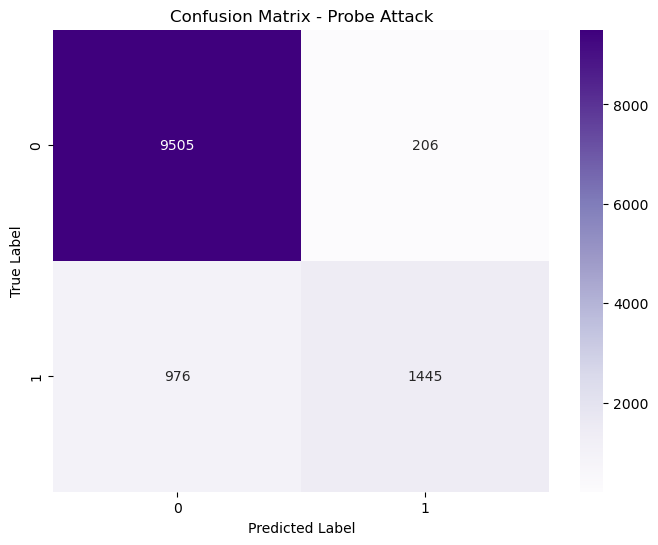

Classification Report for Probe:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9711
           2       0.88      0.60      0.71      2421

    accuracy                           0.90     12132
   macro avg       0.89      0.79      0.83     12132
weighted avg       0.90      0.90      0.90     12132



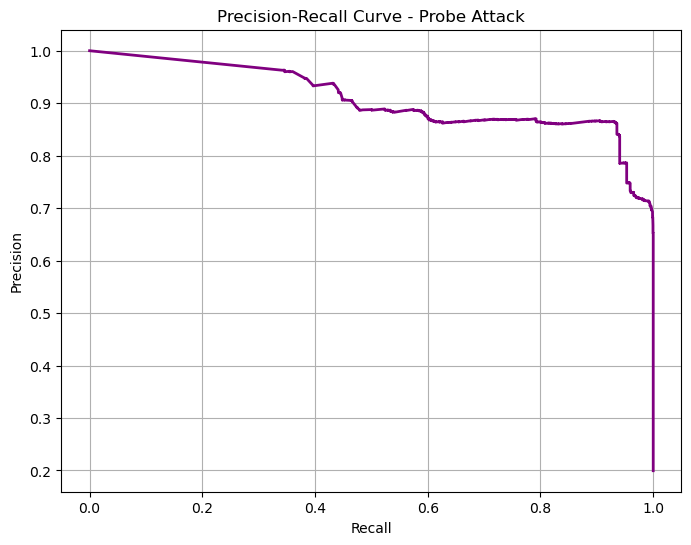

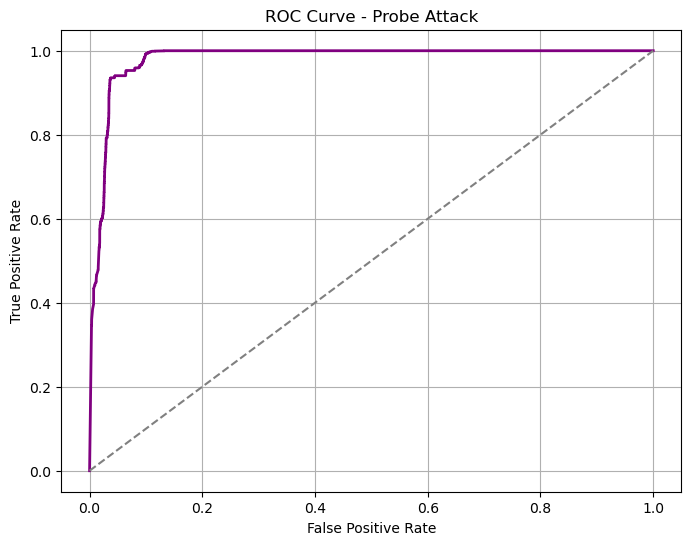

In [91]:
# Predict the labels for the test data
Y_probe_rfepred = clf_rfeProbe_best.predict(X_Probe_test)

# Create the confusion matrix
cm = confusion_matrix(Y_Probe_test, Y_probe_rfepred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - Probe Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the Random Forest model
print("Classification Report for Probe:")
print(classification_report(Y_Probe_test, Y_probe_rfepred))

# Calculate the predicted probabilities for the positive class (Probe attack)
Y_probe_rfepred_proba = clf_rfeProbe_best.predict_proba(X_Probe_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_Probe_test, Y_probe_rfepred_proba, pos_label=2)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Probe Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_Probe_test, Y_probe_rfepred_proba, pos_label=2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Probe Attack')
plt.grid(True)
plt.show()


### Probe prediction with feature selection

Confusion Matrix:
[[9482  229]
 [1015 1406]]


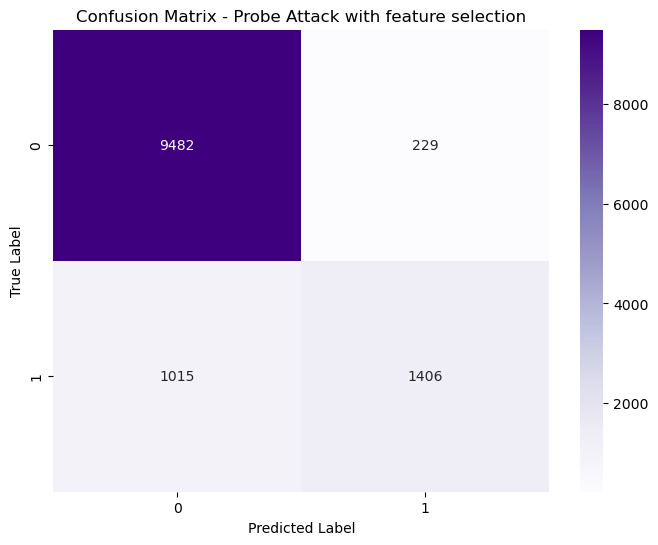

Classification Report for Probe with feature selection:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      9711
           2       0.86      0.58      0.69      2421

    accuracy                           0.90     12132
   macro avg       0.88      0.78      0.82     12132
weighted avg       0.89      0.90      0.89     12132



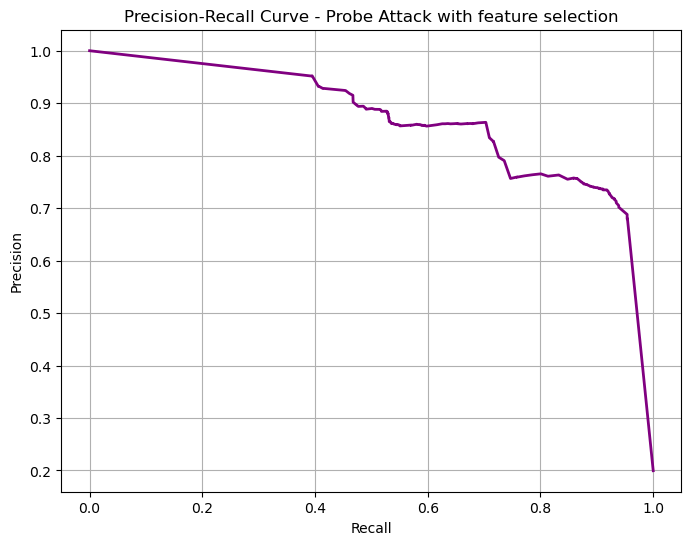

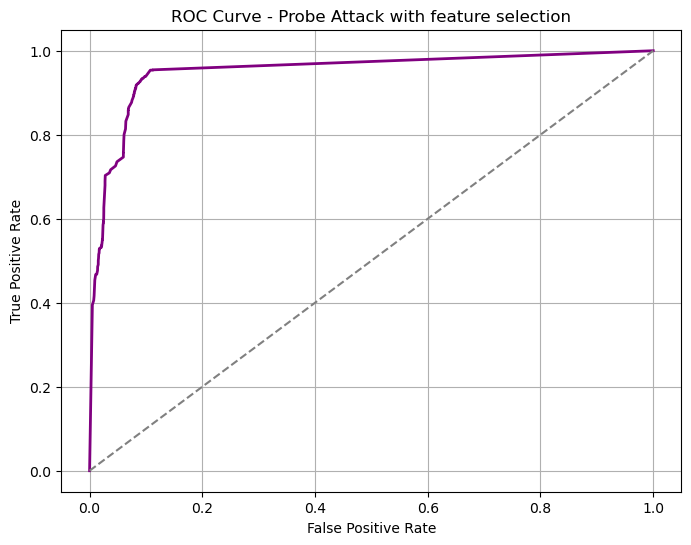

In [92]:
# Predict the labels for the test data using the random tree model
Y_Probe_rfepred_features = clf_rfeProbe_features_best.predict(X_newProbe_test_rfe)

# Create the confusion matrix
cm = confusion_matrix(Y_Probe_test, Y_Probe_rfepred_features)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - Probe Attack with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the Random Forest model
print("Classification Report for Probe with feature selection:")
print(classification_report(Y_Probe_test, Y_Probe_rfepred_features))

# Calculate the predicted probabilities for the positive class (Probe attack)
Y_Probe_rfepred_proba_features = clf_rfeProbe_features_best.predict_proba(X_newProbe_test_rfe)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_Probe_test, Y_Probe_rfepred_proba_features, pos_label=2)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Probe Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_Probe_test, Y_Probe_rfepred_proba_features, pos_label=2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Probe Attack with feature selection')
plt.grid(True)
plt.show()

### R2L prediction

Confusion Matrix:
[[9708    3]
 [2420  334]]


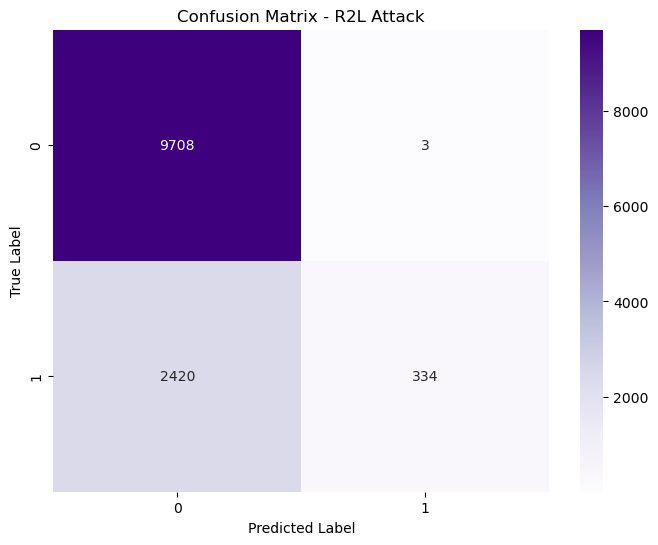

Classification Report for R2L:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      9711
           3       0.99      0.12      0.22      2754

    accuracy                           0.81     12465
   macro avg       0.90      0.56      0.55     12465
weighted avg       0.84      0.81      0.74     12465



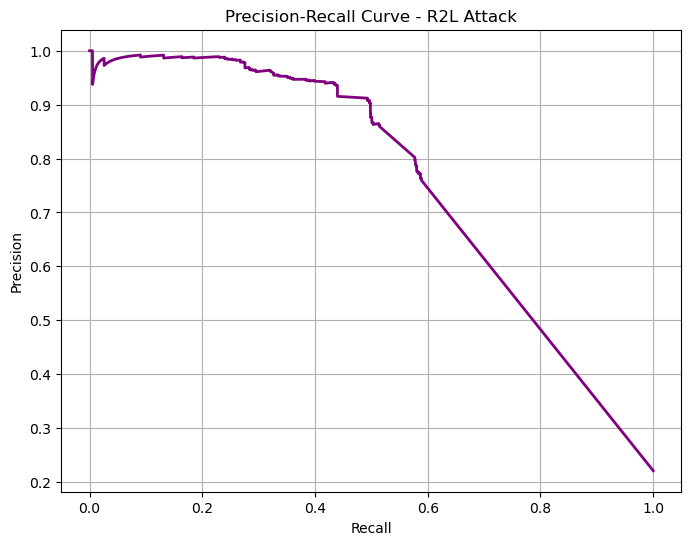

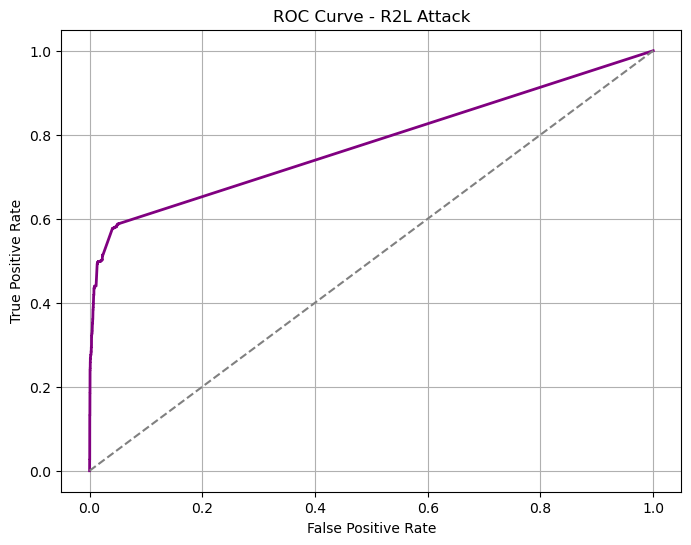

In [93]:
# Predict the labels for the test data
Y_R2L_rfepred = clf_rfeR2L_best.predict(X_R2L_test)

# Create the confusion matrix
cm = confusion_matrix(Y_R2L_test, Y_R2L_rfepred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - R2L Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the Random Forest model
print("Classification Report for R2L:")
print(classification_report(Y_R2L_test, Y_R2L_rfepred))

# Calculate the predicted probabilities for the positive class (R2L attack)
Y_R2L_rfepred_proba = clf_rfeR2L_best.predict_proba(X_R2L_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_R2L_test, Y_R2L_rfepred_proba, pos_label=3)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - R2L Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_R2L_test, Y_R2L_rfepred_proba, pos_label=3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - R2L Attack')
plt.grid(True)
plt.show()


### R2L prediction with feature selection

Confusion Matrix:
[[9709    2]
 [2065  689]]


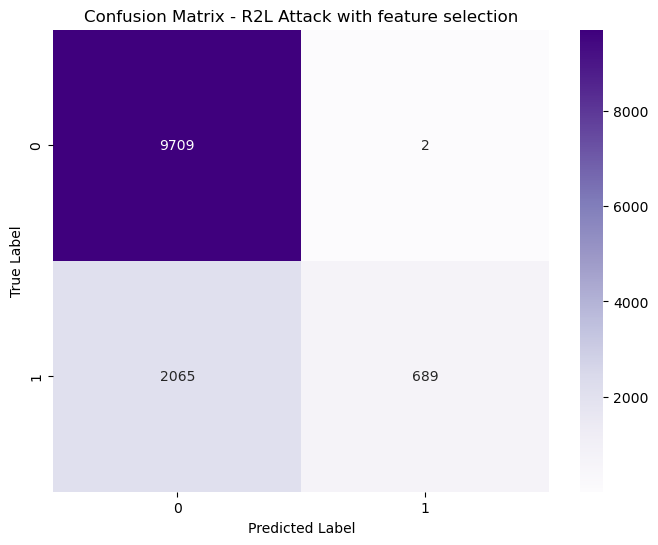

Classification Report for R2L with feature selection:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      9711
           3       1.00      0.25      0.40      2754

    accuracy                           0.83     12465
   macro avg       0.91      0.62      0.65     12465
weighted avg       0.86      0.83      0.79     12465



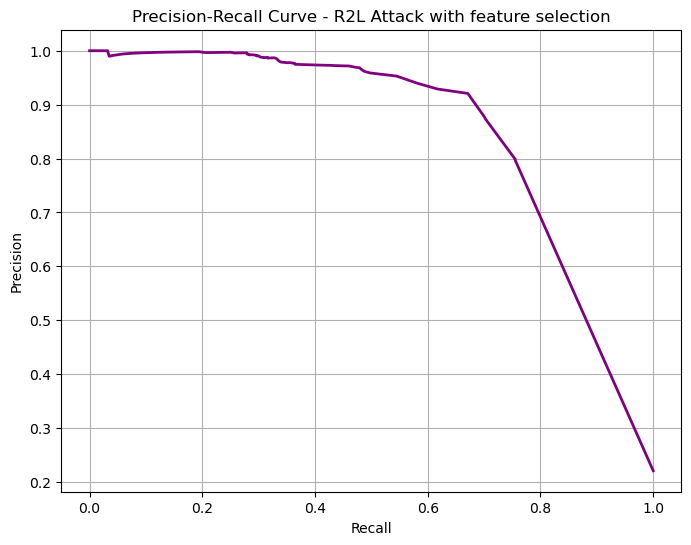

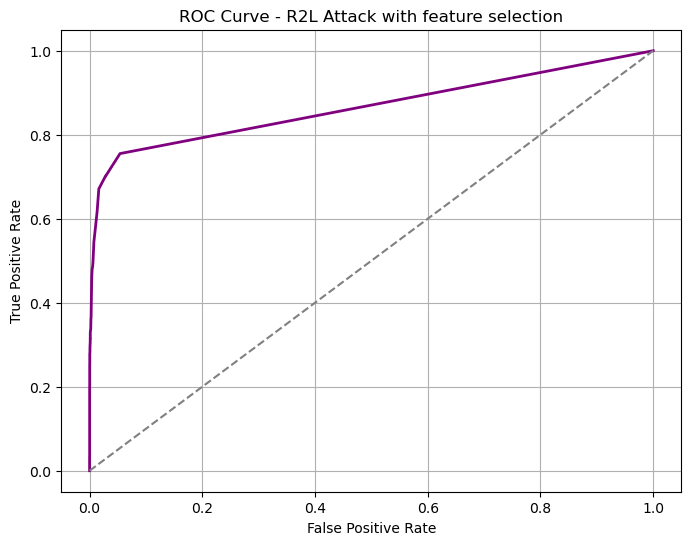

In [94]:
# Predict the labels for the test data using the random tree model
Y_R2L_rfepred_features = clf_rfeR2L_features_best.predict(X_newR2L_test_rfe)

# Create the confusion matrix
cm = confusion_matrix(Y_R2L_test, Y_R2L_rfepred_features)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - R2L Attack with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the Random Forest model
print("Classification Report for R2L with feature selection:")
print(classification_report(Y_R2L_test, Y_R2L_rfepred_features))

# Calculate the predicted probabilities for the positive class (R2L attack)
Y_R2L_rfepred_proba_features = clf_rfeR2L_features_best.predict_proba(X_newR2L_test_rfe)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_R2L_test, Y_R2L_rfepred_proba_features, pos_label=3)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - R2L Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_R2L_test, Y_R2L_rfepred_proba_features, pos_label=3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - R2L Attack with feature selection')
plt.grid(True)
plt.show()


### U2R prediction

Confusion Matrix:
[[9709    2]
 [ 192    8]]


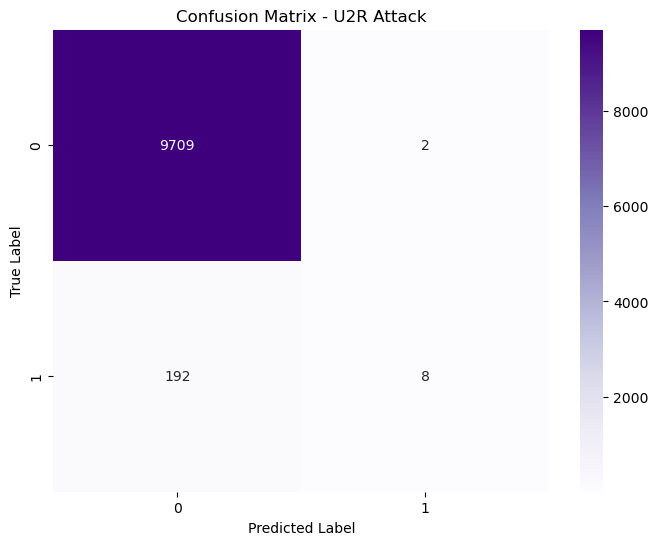

Classification Report for U2R:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9711
           4       0.80      0.04      0.08       200

    accuracy                           0.98      9911
   macro avg       0.89      0.52      0.53      9911
weighted avg       0.98      0.98      0.97      9911



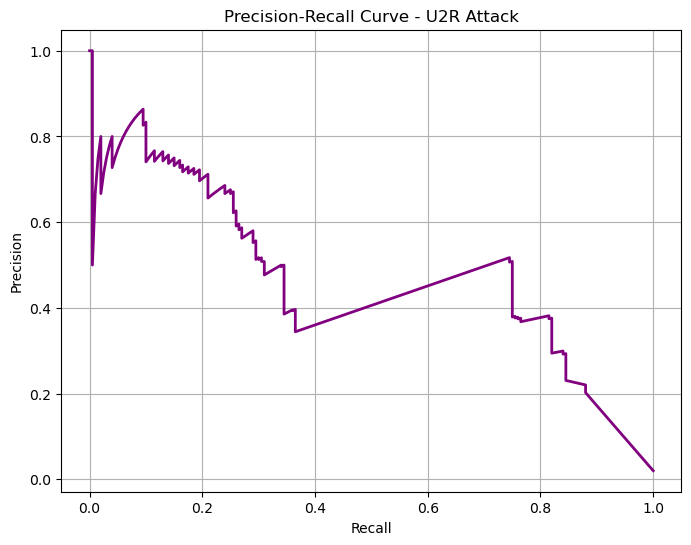

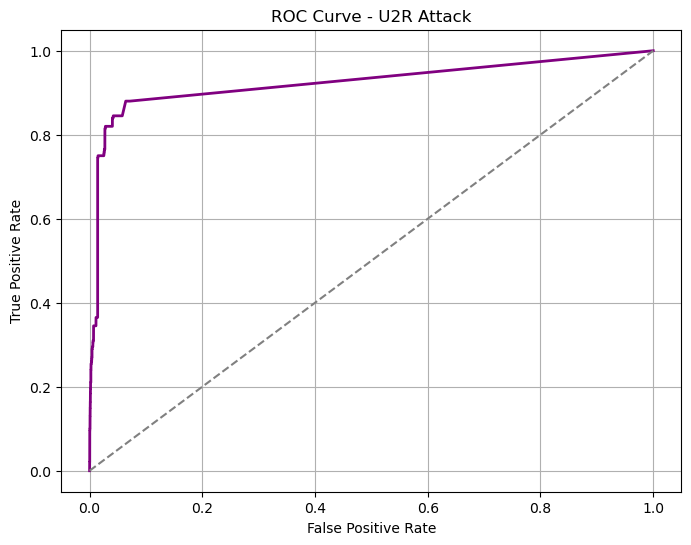

In [95]:
# Predict the labels for the test data
Y_U2R_rfepred = clf_rfeU2R_best.predict(X_U2R_test)

# Create the confusion matrix
cm = confusion_matrix(Y_U2R_test, Y_U2R_rfepred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - U2R Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the Random Forest model
print("Classification Report for U2R:")
print(classification_report(Y_U2R_test, Y_U2R_rfepred))

# Calculate the predicted probabilities for the positive class (U2R attack)
Y_U2R_rfepred_proba = clf_rfeU2R_best.predict_proba(X_U2R_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_U2R_test, Y_U2R_rfepred_proba, pos_label=4)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - U2R Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_U2R_test, Y_U2R_rfepred_proba, pos_label=4)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - U2R Attack')
plt.grid(True)
plt.show()


### U2R prediction with feature selection

Confusion Matrix:
[[9711    0]
 [ 194    6]]


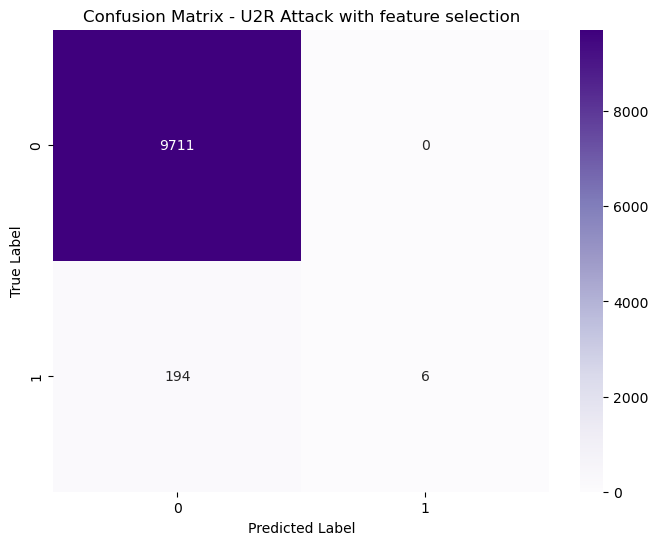

Classification Report for U2R with feature selection:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9711
           4       1.00      0.03      0.06       200

    accuracy                           0.98      9911
   macro avg       0.99      0.52      0.52      9911
weighted avg       0.98      0.98      0.97      9911



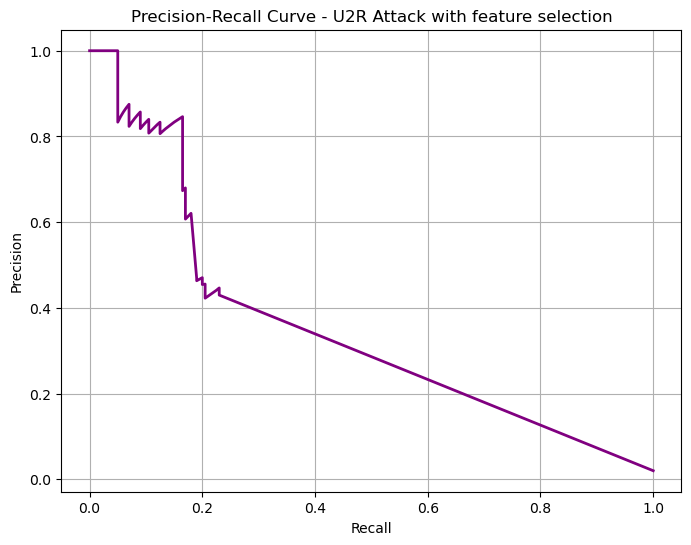

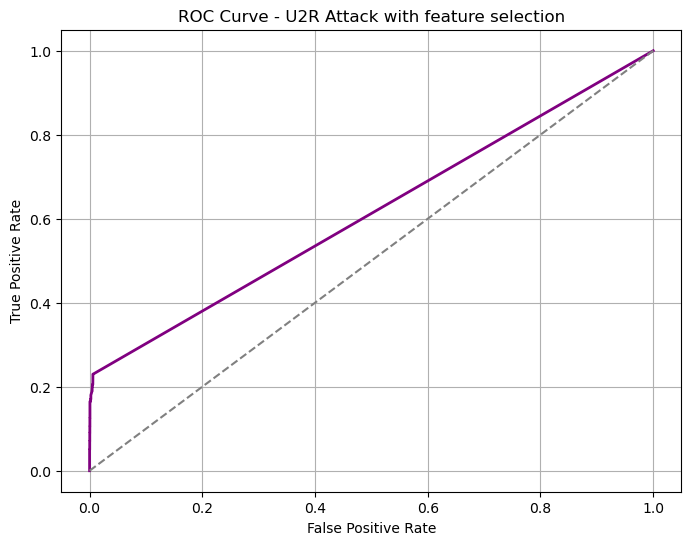

In [96]:
# Predict the labels for the test data using the random tree model
Y_U2R_rfepred_features = clf_rfeU2R_features_best.predict(X_newU2R_test_rfe)

# Create the confusion matrix
cm = confusion_matrix(Y_U2R_test, Y_U2R_rfepred_features)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - U2R Attack with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the Random Forest model
print("Classification Report for U2R with feature selection:")
print(classification_report(Y_U2R_test, Y_U2R_rfepred_features))

# Calculate the predicted probabilities for the positive class (U2R attack)
Y_U2R_rfepred_proba_features = clf_rfeU2R_features_best.predict_proba(X_newU2R_test_rfe)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_U2R_test, Y_U2R_rfepred_proba_features, pos_label=4)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - U2R Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_U2R_test, Y_U2R_rfepred_proba_features, pos_label=4)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - U2R Attack with feature selection')
plt.grid(True)
plt.show()


### Random forest evaluation summary

#### All Data:
Similar pattern with good performance on class 0 and 1, but poor on class 3 and 4. Class 3 has especially low recall, indicating the model is missing many actual cases.
The macro avg is significantly lower than weighted avg, indicating imbalance in model performance across different classes.

#### All Data with Feature Selection:
Feature selection improved precision and recall for class 2 but didn't significantly improve class 3 and 4.
The overall accuracy increased slightly, but the macro avg is still lower due to poor performance on minority classes.

# KNN_Code

In [197]:
# Time Taken: 31 mins
# Create KNN classifiers for each attack type
clf_knn_DoS = KNeighborsClassifier()
clf_knn_DoS_features = KNeighborsClassifier()
clf_knn_Probe = KNeighborsClassifier()
clf_knn_Probe_features = KNeighborsClassifier()
clf_knn_R2L = KNeighborsClassifier()
clf_knn_R2L_features = KNeighborsClassifier()
clf_knn_U2R = KNeighborsClassifier()
clf_knn_U2R_features = KNeighborsClassifier()
clf_knn_All = KNeighborsClassifier()
clf_knn_All_features = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'leaf_size': [30],
    'algorithm': ['auto'],
    'metric': ['minkowski']
}

# Fit the classifiers on the training data
clf_knn_DoS.fit(X_DoS, Y_DoS)
clf_knn_DoS_features.fit(X_newDoS, Y_DoS)
clf_knn_Probe.fit(X_Probe, Y_Probe)
clf_knn_Probe_features.fit(X_newProbe, Y_Probe)
clf_knn_R2L.fit(X_R2L, Y_R2L)
clf_knn_R2L_features.fit(X_newR2L, Y_R2L)
clf_knn_U2R.fit(X_U2R, Y_U2R)
clf_knn_U2R_features.fit(X_newU2R, Y_U2R)
clf_knn_All.fit(X_dataset_train_final, Y_dataset_train_final)
clf_knn_All_features.fit(X_NewAll, Y_dataset_train_final)

# Create StratifiedKFold instance for cross-validation
stratified_k_fold = StratifiedKFold(n_splits=5)

# Perform grid search cross-validation to find the best value of K for each classifier
grid_search_DoS = GridSearchCV(clf_knn_DoS, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_DoS_features = GridSearchCV(clf_knn_DoS_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_Probe = GridSearchCV(clf_knn_Probe, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_Probe_features = GridSearchCV(clf_knn_Probe_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_R2L = GridSearchCV(clf_knn_R2L, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_R2L_features = GridSearchCV(clf_knn_R2L_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_U2R = GridSearchCV(clf_knn_U2R, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_U2R_features = GridSearchCV(clf_knn_U2R_features, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_all = GridSearchCV(clf_knn_All, param_grid, cv=stratified_k_fold, n_jobs=-1)
grid_search_all_features = GridSearchCV(clf_knn_All_features, param_grid, cv=stratified_k_fold, n_jobs=-1)

# Fit the grid search on the training data
grid_search_DoS.fit(X_DoS, Y_DoS)
grid_search_DoS_features.fit(X_newDoS, Y_DoS)
grid_search_Probe.fit(X_Probe, Y_Probe)
grid_search_Probe_features.fit(X_newProbe, Y_Probe)
grid_search_R2L.fit(X_R2L, Y_R2L)
grid_search_R2L_features.fit(X_newR2L, Y_R2L)
grid_search_U2R.fit(X_U2R, Y_U2R)
grid_search_U2R_features.fit(X_newU2R, Y_U2R)
grid_search_all.fit(X_dataset_train_final, Y_dataset_train_final)
grid_search_all_features.fit(X_NewAll, Y_dataset_train_final)

# Get the best value of K for each classifier
best_K_DoS = grid_search_DoS.best_params_['n_neighbors']
best_K_DoS_features = grid_search_DoS_features.best_params_['n_neighbors']
best_K_Probe = grid_search_Probe.best_params_['n_neighbors']
best_K_Probe_features = grid_search_Probe_features.best_params_['n_neighbors']
best_K_R2L = grid_search_R2L.best_params_['n_neighbors']
best_K_R2L_features = grid_search_R2L_features.best_params_['n_neighbors']
best_K_U2R = grid_search_U2R.best_params_['n_neighbors']
best_K_U2R_features = grid_search_U2R_features.best_params_['n_neighbors']
best_K_All = grid_search_all.best_params_['n_neighbors']
best_K_All_features = grid_search_all_features.best_params_['n_neighbors']

# Print the best parameters
print("Best parameters for DoS classifier:", grid_search_DoS.best_params_)
print("Best parameters for DoS classifier with features:", grid_search_DoS_features.best_params_)
print("Best parameters for Probe classifier:", grid_search_Probe.best_params_)
print("Best parameters for Probe classifier with features:", grid_search_Probe_features.best_params_)
print("Best parameters for R2L classifier:", grid_search_R2L.best_params_)
print("Best parameters for R2L classifier with features:", grid_search_R2L_features.best_params_)
print("Best parameters for U2R classifier:", grid_search_U2R.best_params_)
print("Best parameters for U2R classifier with features:", grid_search_U2R_features.best_params_)
print("Best parameters for all classifier:", grid_search_all.best_params_)
print("Best parameters for all classifier with features:", grid_search_all_features.best_params_)

# Create new KNN classifiers with the best value of K
clf_knn_DoS = KNeighborsClassifier(n_neighbors=best_K_DoS)
clf_knn_DoS_features = KNeighborsClassifier(n_neighbors=best_K_DoS_features)
clf_knn_Probe = KNeighborsClassifier(n_neighbors=best_K_Probe)
clf_knn_Probe_features = KNeighborsClassifier(n_neighbors=best_K_Probe_features)
clf_knn_R2L = KNeighborsClassifier(n_neighbors=best_K_R2L)
clf_knn_R2L_features = KNeighborsClassifier(n_neighbors=best_K_R2L_features)
clf_knn_U2R = KNeighborsClassifier(n_neighbors=best_K_U2R)
clf_knn_U2R_features = KNeighborsClassifier(n_neighbors=best_K_U2R_features)
clf_knn_All = KNeighborsClassifier(n_neighbors=best_K_All)
clf_knn_All_features = KNeighborsClassifier(n_neighbors=best_K_All_features)

# Fit the new classifiers on the training data
clf_knn_DoS.fit(X_DoS, Y_DoS)
clf_knn_DoS_features.fit(X_newDoS, Y_DoS)
clf_knn_Probe.fit(X_Probe, Y_Probe)
clf_knn_Probe_features.fit(X_newProbe, Y_Probe)
clf_knn_R2L.fit(X_R2L, Y_R2L)
clf_knn_R2L_features.fit(X_newR2L, Y_R2L)
clf_knn_U2R.fit(X_U2R, Y_U2R)
clf_knn_U2R_features.fit(X_newU2R, Y_U2R)
clf_knn_All.fit(X_dataset_train_final, Y_dataset_train_final)
clf_knn_All_features.fit(X_NewAll, Y_dataset_train_final)

Best parameters for DoS classifier: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
Best parameters for DoS classifier with features: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}
Best parameters for Probe classifier: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
Best parameters for Probe classifier with features: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
Best parameters for R2L classifier: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
Best parameters for R2L classifier with features: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
Best parameters for U2R classifier: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 7, 'weig

KNeighborsClassifier(n_neighbors=3)

## KNN_prediction_and_evaluation

### KNN whole dataset prediction and evaluation

[[8961   59  664    6   21]
 [1159 6253   36   10    0]
 [ 305  465 1606   11   34]
 [2186    3    7  192  366]
 [ 136    0   15   11   38]]


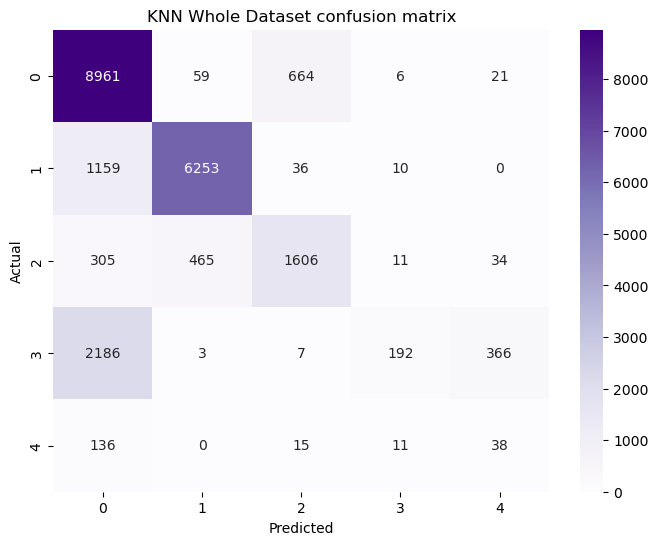

              precision    recall  f1-score   support

           0       0.70      0.92      0.80      9711
           1       0.92      0.84      0.88      7458
           2       0.69      0.66      0.68      2421
           3       0.83      0.07      0.13      2754
           4       0.08      0.19      0.12       200

    accuracy                           0.76     22544
   macro avg       0.65      0.54      0.52     22544
weighted avg       0.78      0.76      0.72     22544



In [198]:
Y_All_Pred = clf_knn_All.predict(X_dataset_test_final)

cm_all = confusion_matrix(Y_dataset_test_final, Y_All_Pred)
print(cm_all)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Purples', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Whole Dataset confusion matrix')
plt.show()

classification_rep = classification_report(Y_dataset_test_final, Y_All_Pred)
print(classification_rep)

### KNN whole dataset with feature selection prediction and evaluation

[[9300   63  326    3   19]
 [1585 5686   64  123    0]
 [ 229  200 1874   96   22]
 [2127    0   13  516   98]
 [  60   64   18   11   47]]


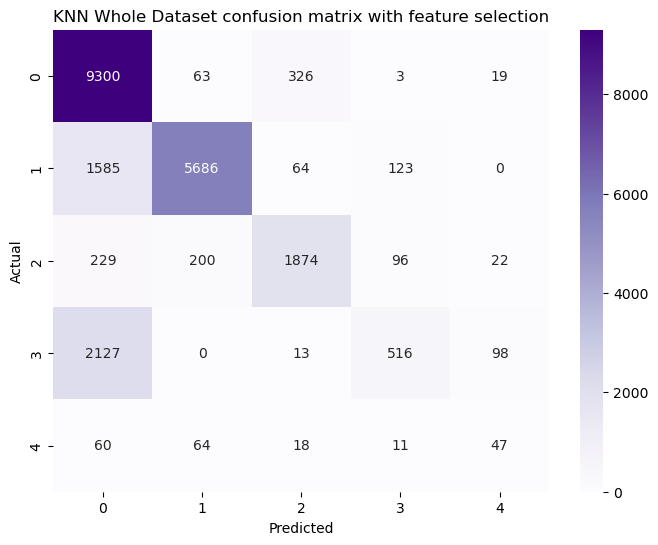

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      9711
           1       0.95      0.76      0.84      7458
           2       0.82      0.77      0.79      2421
           3       0.69      0.19      0.29      2754
           4       0.25      0.23      0.24       200

    accuracy                           0.77     22544
   macro avg       0.68      0.58      0.60     22544
weighted avg       0.79      0.77      0.75     22544



In [199]:
Y_All_Pred = clf_knn_All_features.predict(X_NewAll_test)
cm_all = confusion_matrix(Y_dataset_test_final, Y_All_Pred)
print(cm_all)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Purples', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Whole Dataset confusion matrix with feature selection')
plt.show()

classification_rep = classification_report(Y_dataset_test_final, Y_All_Pred)
print(classification_rep)

### DoS Evaluation

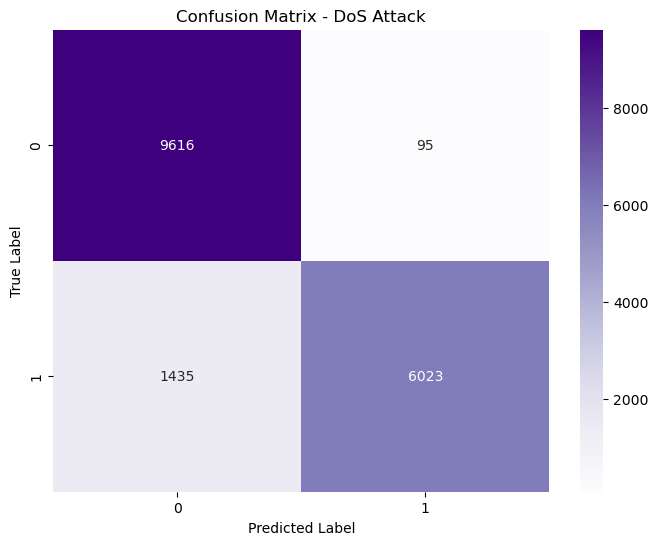

Classification Report for Probe:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      9711
           1       0.98      0.81      0.89      7458

    accuracy                           0.91     17169
   macro avg       0.93      0.90      0.91     17169
weighted avg       0.92      0.91      0.91     17169



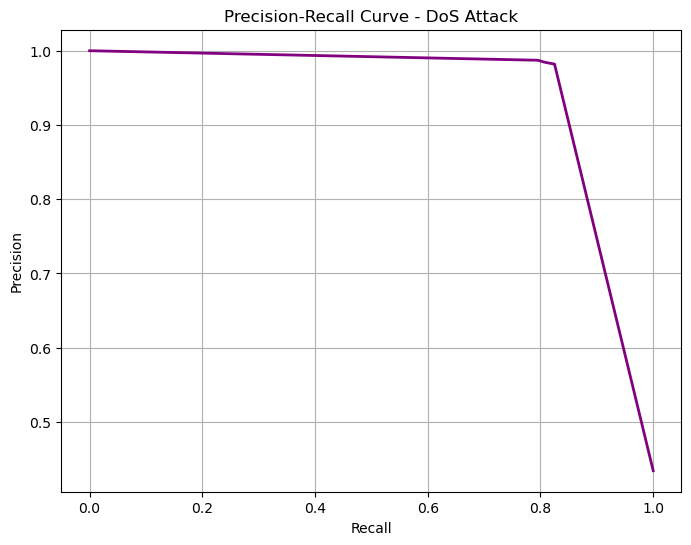

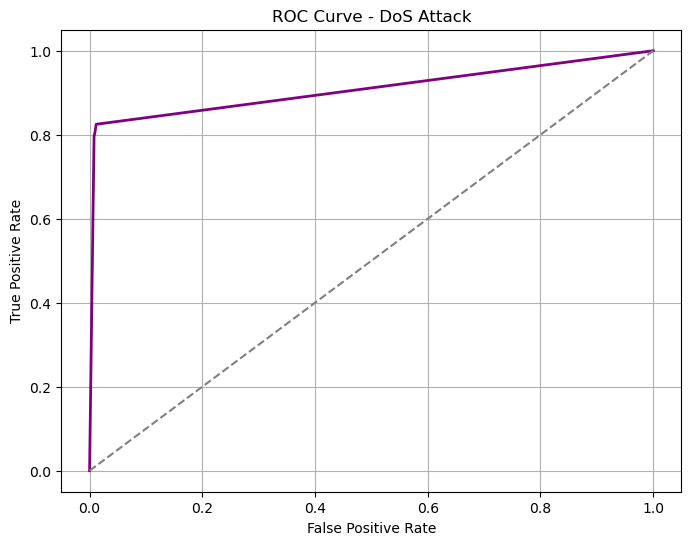

In [200]:
Y_DoS_pred = clf_knn_DoS.predict(X_DoS_test)

# Create confusion matrix
confusion_matrix = pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - DoS Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report for Probe:")
print(classification_report(Y_DoS_test, Y_DoS_pred))

# Calculate the predicted probabilities for the positive class (DoS attack)
Y_DoS_pred_proba = clf_knn_DoS.predict_proba(X_DoS_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_DoS_test, Y_DoS_pred_proba, pos_label=1)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - DoS Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_DoS_test, Y_DoS_pred_proba, pos_label=1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DoS Attack')
plt.grid(True)
plt.show()


### DoS Evaluation with feature selection

Confusion Matrix for DoS with feature selection:
Predicted attacks     0     1
Actual attacks               
0                  9642    69
1                  1254  6204
Accuracy: 0.9229425126681811


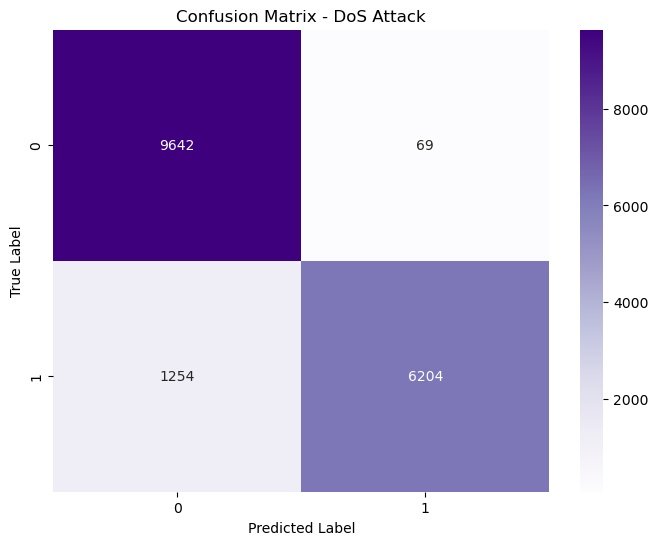

Classification Report for DoS:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94      9711
           1       0.99      0.83      0.90      7458

    accuracy                           0.92     17169
   macro avg       0.94      0.91      0.92     17169
weighted avg       0.93      0.92      0.92     17169



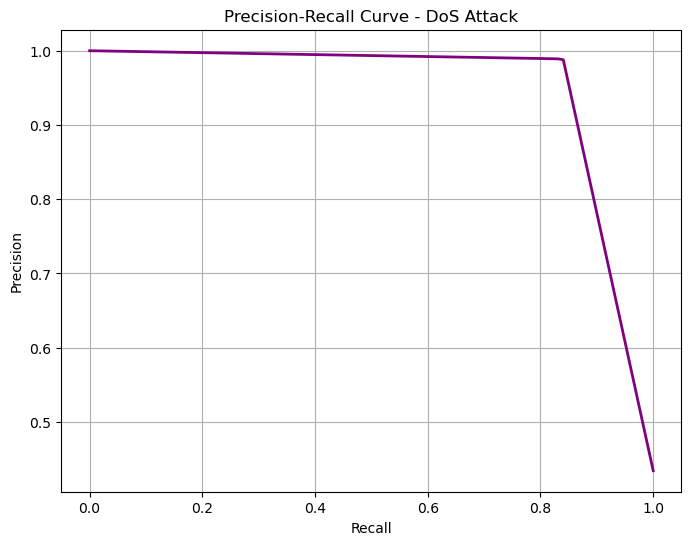

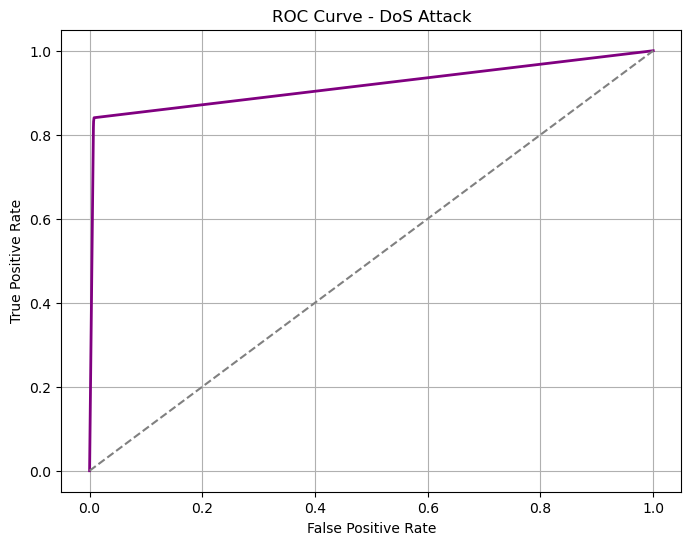

AUC-ROC Score for DoS Prediction: 0.916645002768257


In [201]:
# Make predictions on the test set
Y_DoS_pred_feature = clf_knn_DoS_features.predict(X_newDoS_test)

# Create confusion matrix
cm_DoS = pd.crosstab(Y_DoS_test, Y_DoS_pred_feature, rownames=['Actual attacks'], colnames=['Predicted attacks'])

print("Confusion Matrix for DoS with feature selection:")
print(cm_DoS)

# Calculate accuracy
accuracy_DoS = accuracy_score(Y_DoS_test, Y_DoS_pred_feature)
print("Accuracy:", accuracy_DoS)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_DoS, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - DoS Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for DoS:")
print(classification_report(Y_DoS_test, Y_DoS_pred_feature))

# Calculate the predicted probabilities for the positive class (DoS attack)
# Ensure to use the transformed test set
Y_DoS_pred_proba = clf_knn_DoS_features.predict_proba(X_newDoS_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_DoS_test, Y_DoS_pred_proba, pos_label=1)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - DoS Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_DoS_test, Y_DoS_pred_proba, pos_label=1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DoS Attack')
plt.grid(True)
plt.show()

# Calculate the AUC-ROC score
auc_roc_score = roc_auc_score(Y_DoS_test, Y_DoS_pred_proba)
print("AUC-ROC Score for DoS Prediction:", auc_roc_score)

### Probe prediction

Confusion Matrix for Probe:
Predicted attacks     0     2
Actual attacks               
0                  9388   323
2                   536  1885
Accuracy: 0.9291955159907682


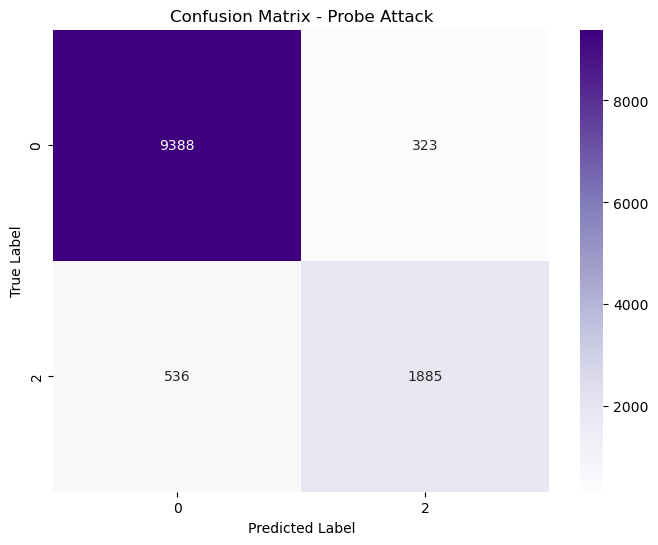

Classification Report for Probe:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      9711
           2       0.85      0.78      0.81      2421

    accuracy                           0.93     12132
   macro avg       0.90      0.87      0.89     12132
weighted avg       0.93      0.93      0.93     12132



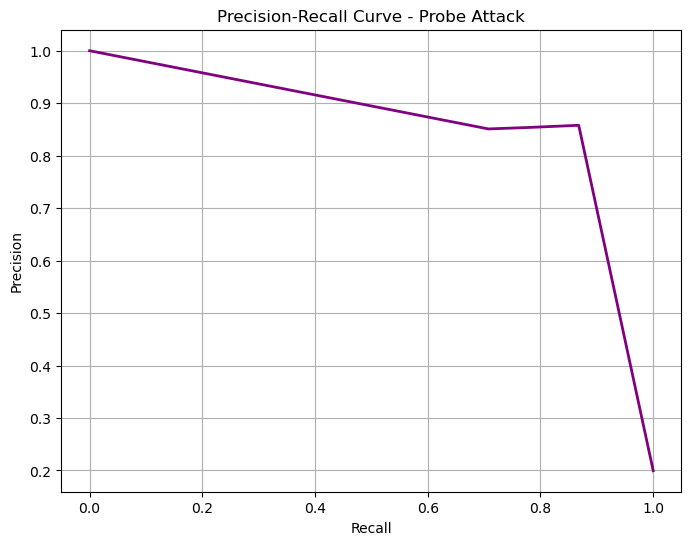

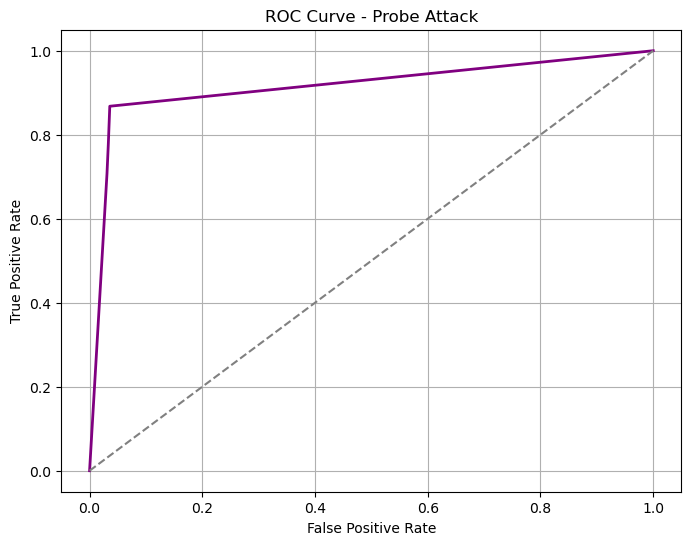

In [202]:
Y_Probe_pred = clf_knn_Probe.predict(X_Probe_test)

# Create confusion matrix
cm = pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

print("Confusion Matrix for Probe:")
print(cm)

# Calculate accuracy
accuracy_Probe = accuracy_score(Y_Probe_test, Y_Probe_pred)
print("Accuracy:", accuracy_Probe)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - Probe Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report for Probe:")
print(classification_report(Y_Probe_test, Y_Probe_pred))

# Calculate the predicted probabilities for the positive class (Probe attack)
Y_Probe_pred_proba = clf_knn_Probe.predict_proba(X_Probe_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_Probe_test, Y_Probe_pred_proba, pos_label=2)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Probe Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_Probe_test, Y_Probe_pred_proba, pos_label=2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Probe Attack')
plt.grid(True)
plt.show()

### Probe prediction with feature selection

Confusion Matrix for Probe with feature selection:
Predicted attacks     0     2
Actual attacks               
0                  9014   697
2                   758  1663
Accuracy: 0.8800692383778437


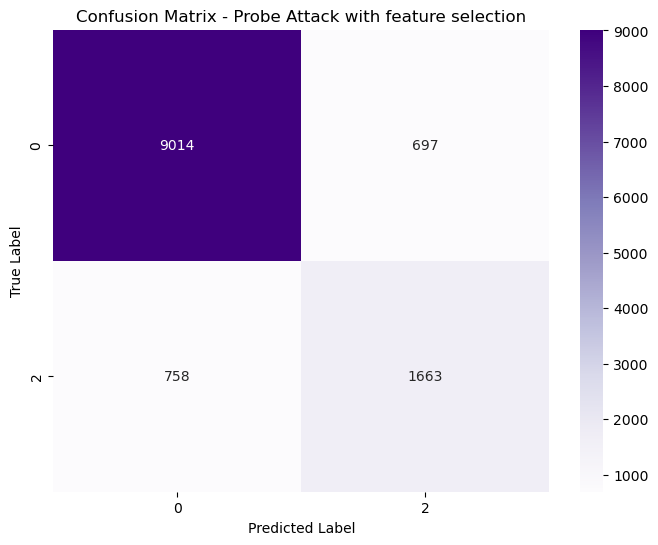

Classification Report for Probe with feature selection:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      9711
           2       0.70      0.69      0.70      2421

    accuracy                           0.88     12132
   macro avg       0.81      0.81      0.81     12132
weighted avg       0.88      0.88      0.88     12132



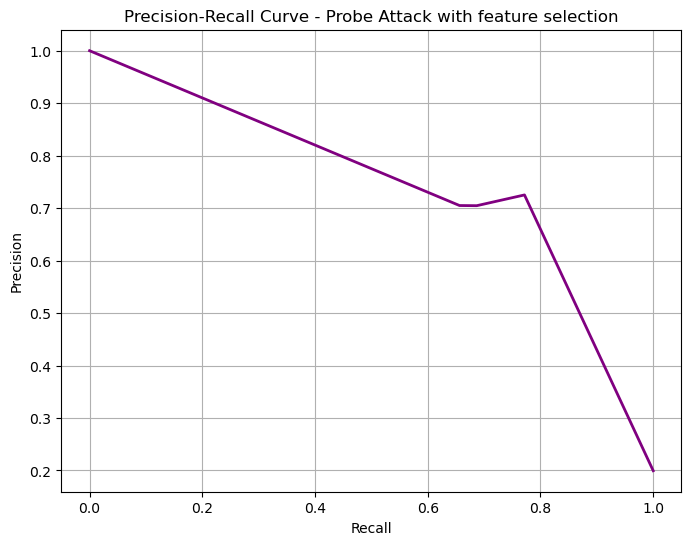

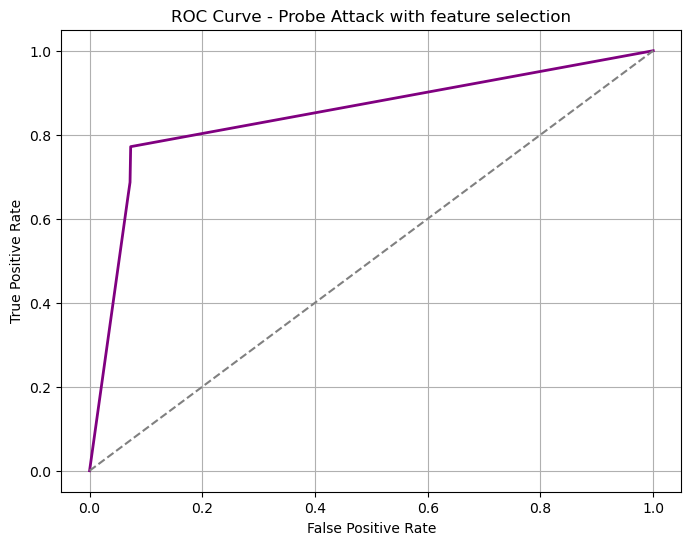

AUC-ROC Score for Probe Prediction: 0.8467225961216793


In [203]:
# Make predictions on the test set
Y_Probe_pred = clf_knn_Probe_features.predict(X_newProbe_test)

# Create confusion matrix
cm_Probe= pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

print("Confusion Matrix for Probe with feature selection:")
print(cm_Probe)

# Calculate accuracy
accuracy_Probe = accuracy_score(Y_Probe_test, Y_Probe_pred)
print("Accuracy:", accuracy_Probe)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_Probe, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - Probe Attack with feature selection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for Probe with feature selection:")
print(classification_report(Y_Probe_test, Y_Probe_pred))

# Calculate the predicted probabilities for the positive class (DoS attack)
# Ensure to use the transformed test set
Y_Probe_pred_proba = clf_knn_Probe_features.predict_proba(X_newProbe_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_Probe_test, Y_Probe_pred_proba, pos_label=2)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Probe Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_Probe_test, Y_Probe_pred_proba, pos_label=2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Probe Attack with feature selection')
plt.grid(True)
plt.show()

# Calculate the AUC-ROC score
auc_roc_score = roc_auc_score(Y_Probe_test, Y_Probe_pred_proba)
print("AUC-ROC Score for Probe Prediction:", auc_roc_score)

### R2L prediction


Confusion Matrix for R2L:
Predicted attacks     0    3
Actual attacks              
0                  9701   10
3                  2498  256

Classification Report for R2L:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      9711
           3       0.96      0.09      0.17      2754

    accuracy                           0.80     12465
   macro avg       0.88      0.55      0.53     12465
weighted avg       0.83      0.80      0.73     12465



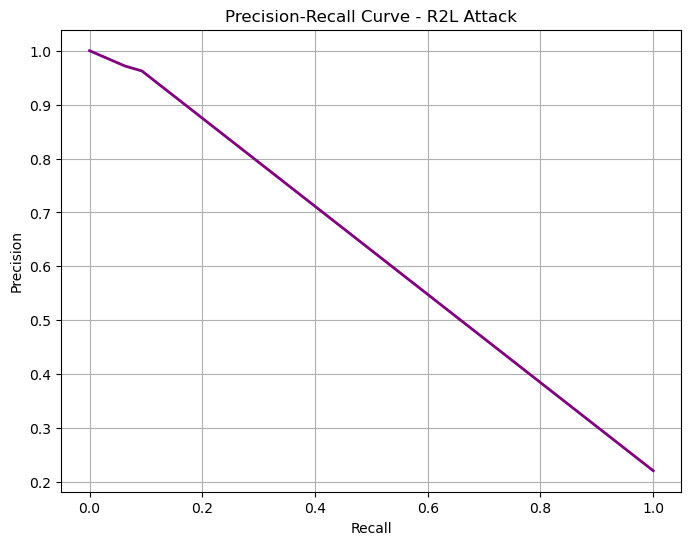

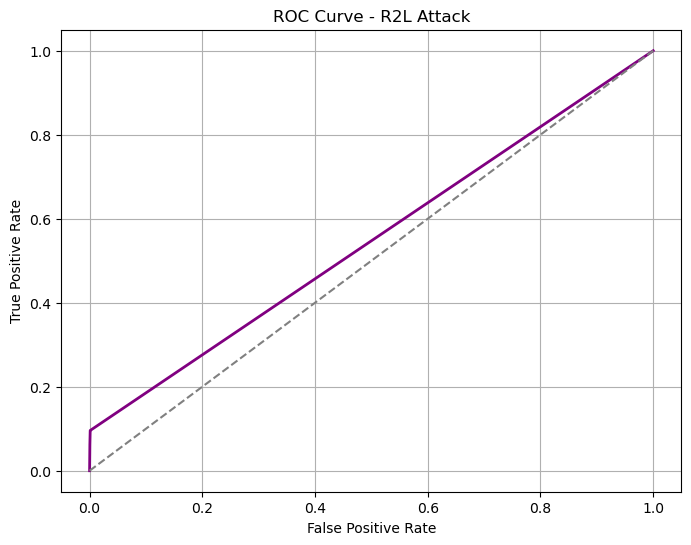

In [204]:
Y_R2L_pred = clf_knn_R2L.predict(X_R2L_test)

# Create confusion matrix
confusion_matrix = pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Display the and confusion matrix
print("\nConfusion Matrix for R2L:")
print(confusion_matrix)
print()

print("Classification Report for R2L:")
print(classification_report(Y_R2L_test, Y_R2L_pred))

# Calculate the predicted probabilities for the positive class (R2L attack)
Y_R2L_pred_proba = clf_knn_R2L.predict_proba(X_R2L_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_R2L_test, Y_R2L_pred_proba, pos_label=3)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - R2L Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_R2L_test, Y_R2L_pred_proba, pos_label=3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - R2L Attack')
plt.grid(True)
plt.show()


### R2L prediction with feature selection

Confusion Matrix for R2L with feature selection:
Predicted attacks     0    3
Actual attacks              
0                  9703    8
3                  2524  230
Accuracy: 0.7968712394705174


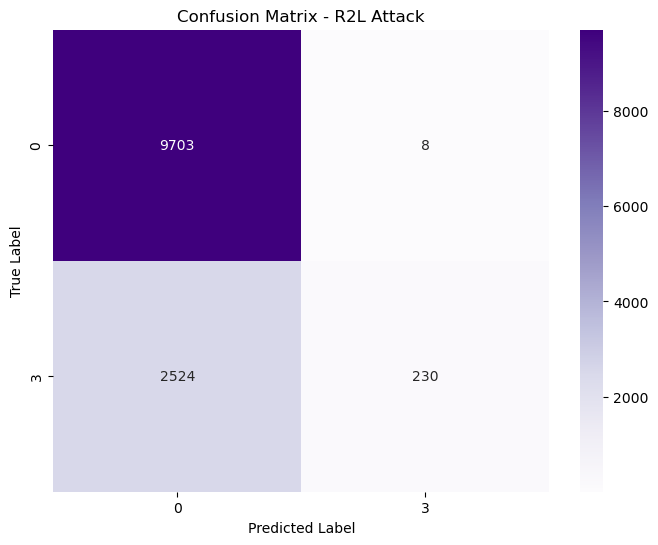

Classification Report for R2L:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      9711
           3       0.97      0.08      0.15      2754

    accuracy                           0.80     12465
   macro avg       0.88      0.54      0.52     12465
weighted avg       0.83      0.80      0.72     12465



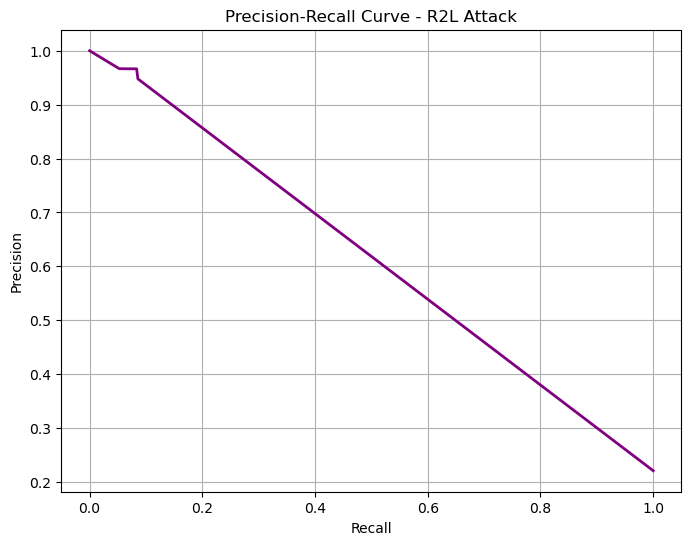

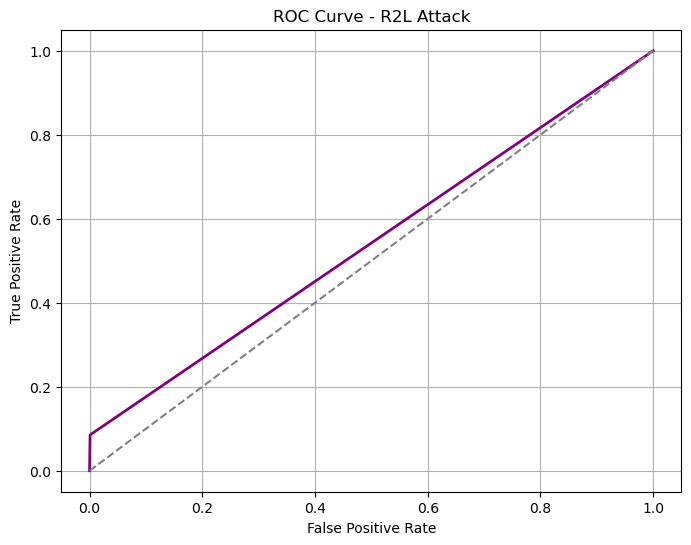

AUC-ROC Score for R2L Prediction: 0.5421982139308964


In [205]:
# Make predictions on the test set
Y_R2L_pred = clf_knn_R2L_features.predict(X_newR2L_test)

# Create confusion matrix
cm_R2L = pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

print("Confusion Matrix for R2L with feature selection:")
print(cm_R2L)

# Calculate accuracy
accuracy_R2L = accuracy_score(Y_R2L_test, Y_R2L_pred)
print("Accuracy:", accuracy_R2L)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_R2L, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - R2L Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for R2L:")
print(classification_report(Y_R2L_test, Y_R2L_pred))

# Calculate the predicted probabilities for the positive class (DoS attack)
# Ensure to use the transformed test set
Y_R2L_pred_proba = clf_knn_R2L_features.predict_proba(X_newR2L_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_R2L_test, Y_R2L_pred_proba, pos_label=3)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - R2L Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_R2L_test, Y_R2L_pred_proba, pos_label=3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - R2L Attack')
plt.grid(True)
plt.show()

# Calculate the AUC-ROC score
auc_roc_score = roc_auc_score(Y_R2L_test, Y_R2L_pred_proba)
print("AUC-ROC Score for R2L Prediction:", auc_roc_score)


### U2R prediction

Evaluation Metrics for U2R:
Accuracy: 0.9811320754716981

Confusion Matrix for U2R:
Predicted attacks     0   4
Actual attacks             
0                  9705   6
4                   181  19



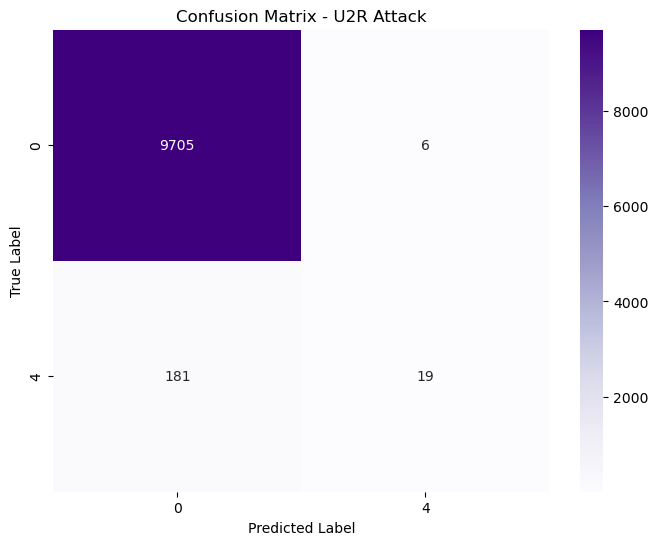

Classification Report for Probe:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9711
           4       0.76      0.10      0.17       200

    accuracy                           0.98      9911
   macro avg       0.87      0.55      0.58      9911
weighted avg       0.98      0.98      0.97      9911



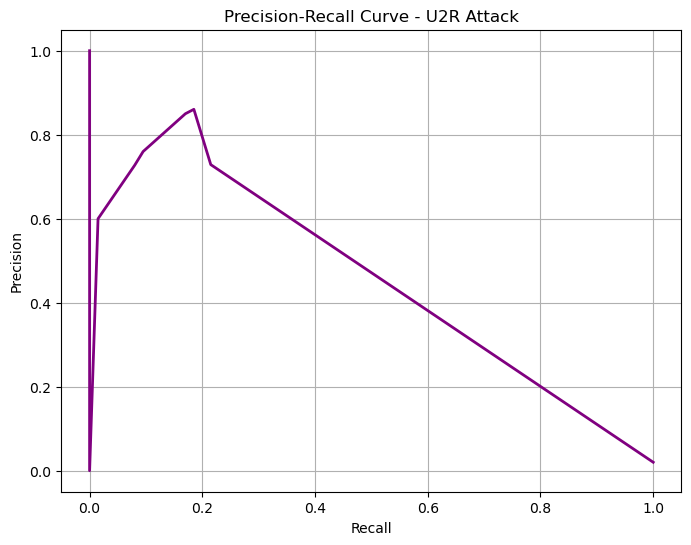

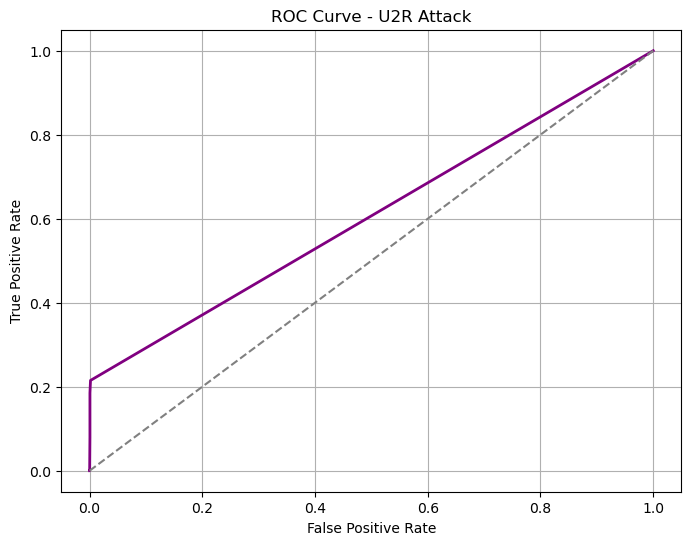

In [206]:
import seaborn as sns
Y_U2R_pred=clf_knn_U2R.predict(X_U2R_test)

# Create confusion matrix
confusion_matrix = pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Calculate evaluation metrics
accuracy = accuracy_score(Y_U2R_test, Y_U2R_pred)

# Display the evaluation metrics and confusion matrix
print("Evaluation Metrics for U2R:")
print("Accuracy:", accuracy)
print("\nConfusion Matrix for U2R:")
print(confusion_matrix)
print()

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - U2R Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report for Probe:")
print(classification_report(Y_U2R_test, Y_U2R_pred))

# Calculate the predicted probabilities for the positive class (U2R attack)
Y_U2R_pred_proba = clf_knn_U2R.predict_proba(X_U2R_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_U2R_test, Y_U2R_pred_proba, pos_label=4)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - U2R Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_U2R_test, Y_U2R_pred_proba, pos_label=4)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - U2R Attack')
plt.grid(True)
plt.show()


### U2R prediction with feature selection

Confusion Matrix for U2R with feature selection:
Predicted attacks     0   4
Actual attacks             
0                  9710   1
4                   189  11
Accuracy: 0.9808293814953083


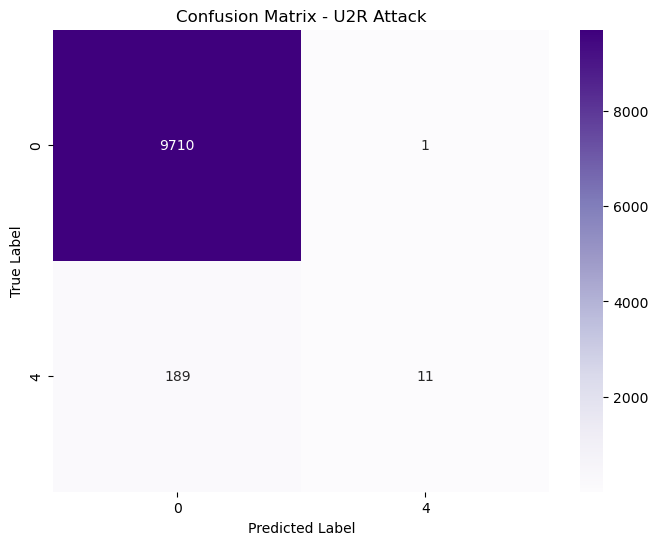

Classification Report for U2R:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9711
           4       0.92      0.06      0.10       200

    accuracy                           0.98      9911
   macro avg       0.95      0.53      0.55      9911
weighted avg       0.98      0.98      0.97      9911



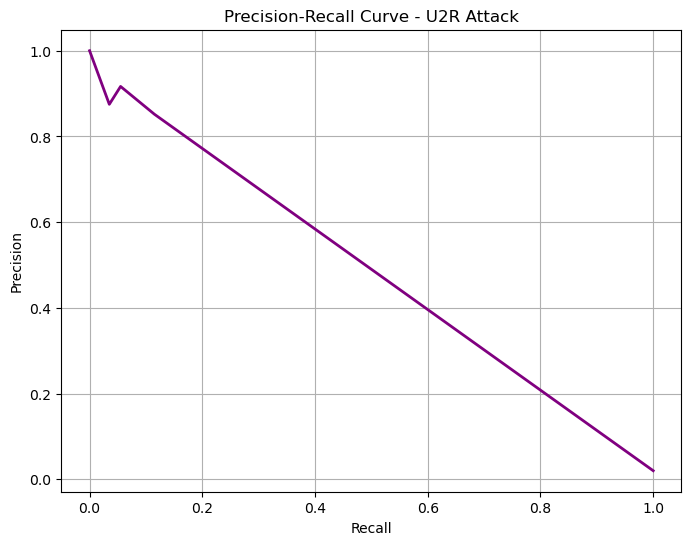

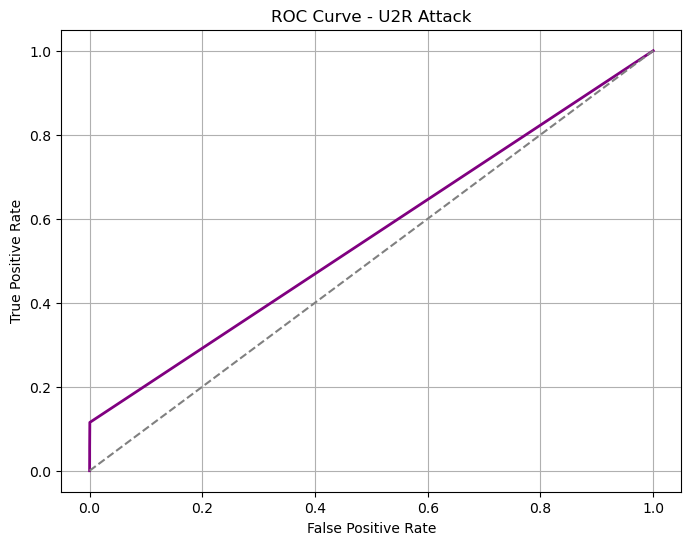

In [207]:
# Make predictions on the test set
Y_U2R_pred = clf_knn_U2R_features.predict(X_newU2R_test)

# Create confusion matrix
cm_U2R = pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

print("Confusion Matrix for U2R with feature selection:")
print(cm_U2R)

# Calculate accuracy
accuracy_U2R = accuracy_score(Y_U2R_test, Y_U2R_pred)
print("Accuracy:", accuracy_U2R)

# Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_U2R, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - U2R Attack")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate the performance of the model
print("Classification Report for U2R:")
print(classification_report(Y_U2R_test, Y_U2R_pred))

# Calculate the predicted probabilities for the positive class (U2R attack)
# Ensure to use the transformed test set
Y_U2R_pred_proba = clf_knn_U2R_features.predict_proba(X_newU2R_test)[:, 1]

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_U2R_test, Y_U2R_pred_proba, pos_label=4)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - U2R Attack')
plt.grid(True)
plt.show()

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_U2R_test, Y_U2R_pred_proba, pos_label=4)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - U2R Attack')
plt.grid(True)
plt.show()

### KNN evaluation summary

#### All Data:
Decent performance on class 0 and 1, but very poor on class 3 and especially class 4. Class 4 has a very high recall but very low precision, indicating a lot of false positives.
Macro avg is the lowest among all models indicating poor performance distribution across classes.

#### All Data with Feature Selection:
Feature selection improved performance across most classes except class 3. Significant improvement in class 4 but still relatively low performance.
Slight increase in overall accuracy and macro avg, indicating feature selection helped in better identifying minority classes.

## Overall_Evaluation

### General Observations:

#### Class Imbalance: 
All models show good performance on classes 0 and 1 but struggle with classes 3 and 4, which could be due to class imbalance. Class 4, being a minority, has the most inconsistent performance across all models.

#### Feature Selection: 
Feature selection generally improved performance on minority classes but did not significantly improve overall accuracy. It's worth noting the changes in precision and recall for different classes, indicating shifts in the model's ability to identify and classify different classes.

#### Evaluation Metrics: 
The discrepancy between macro avg and weighted avg across all models indicates class imbalance. While weighted avg is influenced by the majority classes (0 and 1), macro avg equally considers all classes, showing weaknesses in classes 3 and 4.

### Overall Model Performance:

#### Consistency Across Models:
The accuracy for U2R attacks is uniformly high (98%) across all models, both with and without feature selection. Similarly, R2L attacks have consistent but not as high accuracy across models. This might indicate that the models are all picking up on specific characteristics of these attack types well.
For other attack types (Dos, Probe, and All attacks), there's more variability in model performance, suggesting different strengths and weaknesses of each model in handling these categories.

#### Impact of Feature Selection:
Feature selection does not consistently improve model performance. In some cases, it slightly improves accuracy (e.g., R2L attacks with Decision Trees), while in others, it slightly reduces it (e.g., All attacks with KNN). This indicates that the importance of feature selection is highly dependent on the specific model and attack type.

### Abnormal High Accuracy in R2L/U2R Attacks:


#### Imbalanced Classes:
The confusion matrixes indicates a highly imbalanced dataset, with a vast majority of the instances being negative (non-attacks) and a very small number being positive (actual attacks). This can lead to models that are overly biased towards predicting the majority class, resulting in high accuracy but poor ability to detect actual attacks (low true positive rate).

#### Precision-Recall Trade-off:
It's important to look at the other metrics like precision, recall, and the F1 score to get a better understanding of model performance, especially in the context of anomaly detection where false negatives (missing an attack) can be much more costly than false positives.

#### Overfitting to Majority Class:
The models might be overfitting to the majority class, essentially learning to always predict 'no attack'. This would make them perform poorly on the minority class (actual attacks), which is supported by the confusion matrixes.

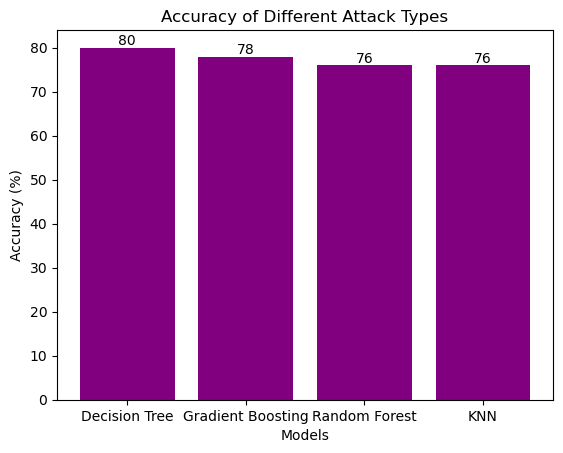

In [208]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [80, 78, 76, 76]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Attack Types')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

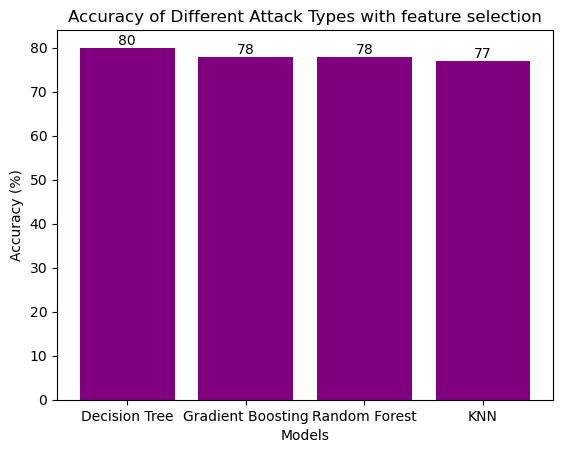

In [218]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [80, 78, 78, 77]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Attack Types with feature selection')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

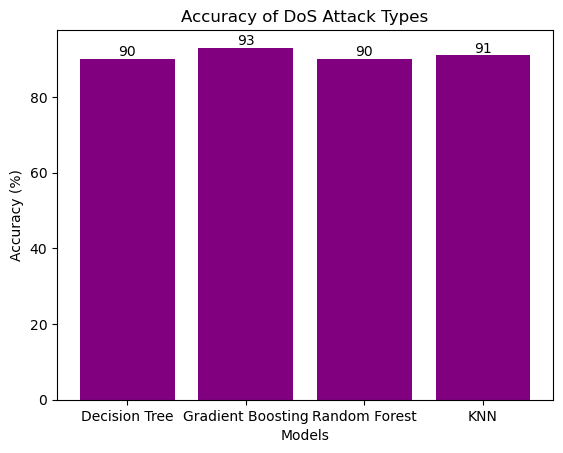

In [210]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [90, 93, 90, 91]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of DoS Attack Types')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

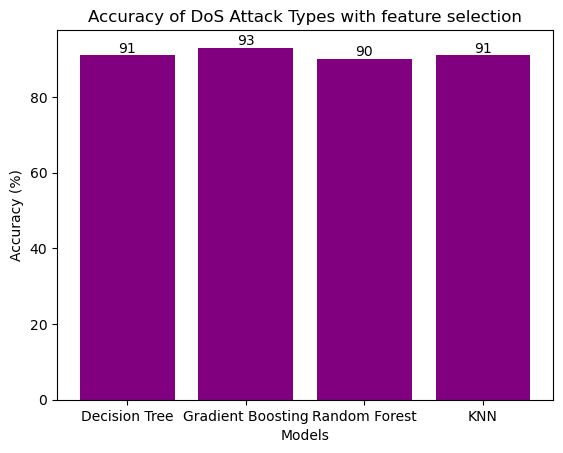

In [211]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [91, 93, 90, 91]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of DoS Attack Types with feature selection')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

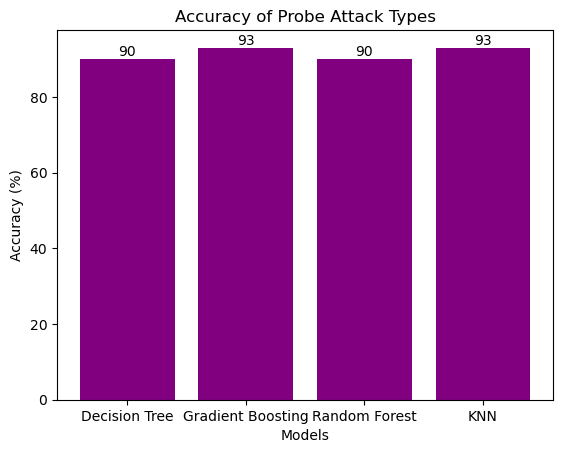

In [212]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [90, 93, 90, 93]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Probe Attack Types')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

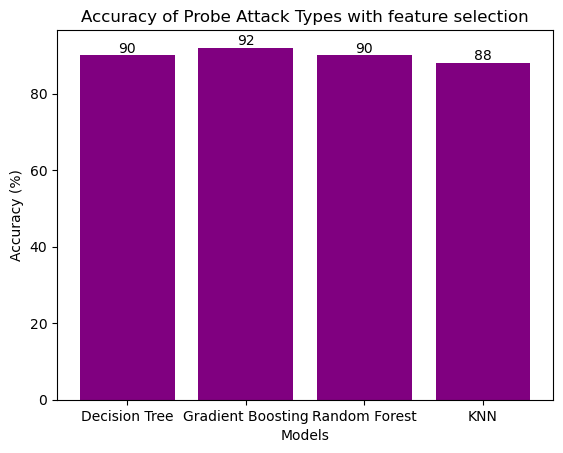

In [213]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [90, 92, 90, 88]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Probe Attack Types with feature selection')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

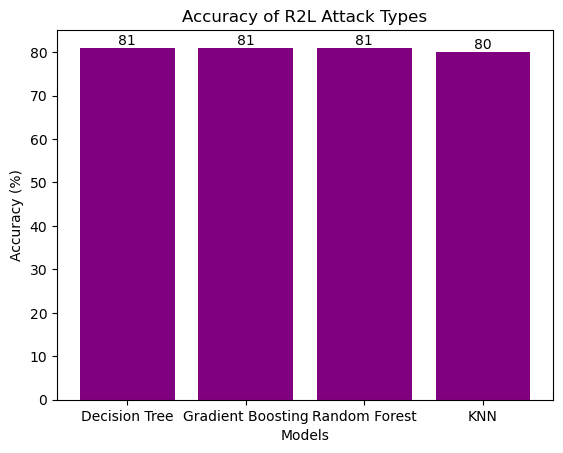

In [214]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [81, 81, 81, 80]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of R2L Attack Types')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

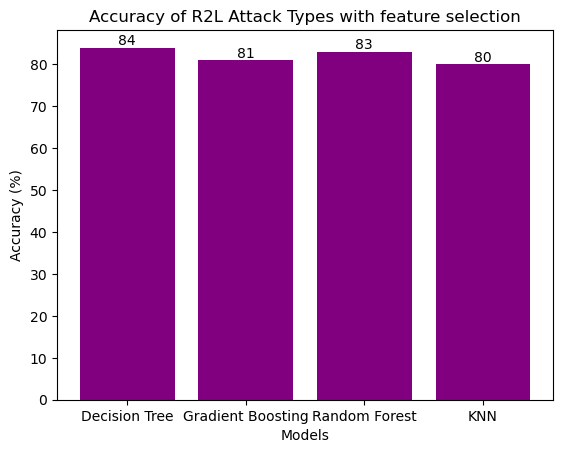

In [215]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [84, 81, 83, 80]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of R2L Attack Types with feature selection')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

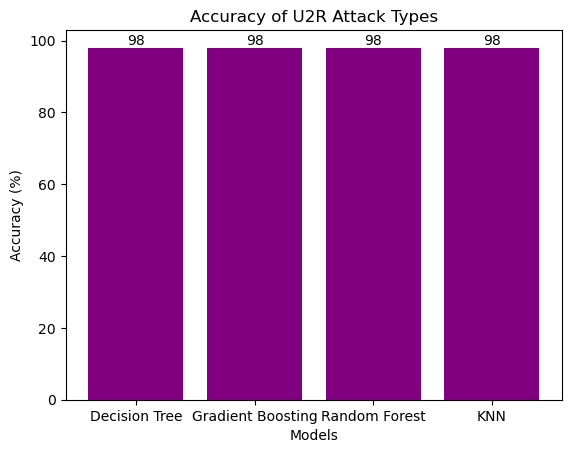

In [216]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [98, 98, 98, 98]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of U2R Attack Types')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

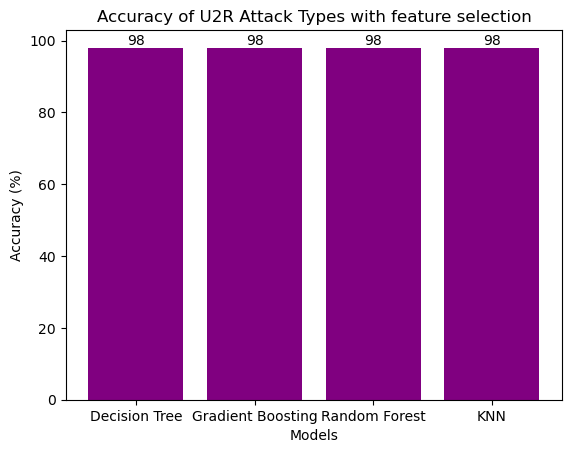

In [217]:
# Data
attacks = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'KNN']
accuracy = [98, 98, 98, 98]

# Create bar graph
plt.bar(attacks, accuracy, color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of U2R Attack Types with feature selection')

# Add accuracy numbers to the top of the bars
for i in range(len(attacks)):
    plt.text(i, accuracy[i], str(accuracy[i]), ha='center', va='bottom')

# Display the bar graph
plt.show()

## Future_Work

| Area                | Description                                                                                                                                                                                                                      |
|---------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Addressing Class Imbalance** | Employ strategies such as resampling methods or modification of class weights to enhance the model's accuracy, particularly in predicting underrepresented classes.                                                              |
| **Model Tuning**                | Investigate further optimisation of the model parameters, emphasising augmenting the recall metric for class 3 and the precision metric for class 4, to achieve superior overall performance.                                       |
| **Feature Engineering**         | Explore the integration of more sophisticated feature engineering techniques or the incorporation of domain-specific features to potentially boost the model's efficacy, especially in the context of the minority classes.         |


## Conclusion
Even with the imbalanced dataset, the models were able to achieve high accuracy, precision, recall, and f1-score for the majority classes (0 and 1). However, the models struggled with the minority classes (3 and 4), especially class 4, which had the lowest performance across all models. This indicates that the models are not able to identify and classify these classes well, which could be due to the class imbalance in the dataset. The models might be overfitting to the majority class, essentially learning to always predict 'no attack'. This would make them perform poorly on the minority class (actual attacks), which is supported by the confusion matrixes. Even with feature selection and data balancing, the models were not able to significantly improve performance on the minority classes, indicating that the importance of feature selection and data balancing is highly dependent on the specific model and attack type.

## References
Tavallaee, Mahbod, et al. “A Detailed Analysis of the KDD CUP 99 Data Set.” 2009 IEEE Symposium on Computational Intelligence for Security and Defense Applications, July 2009, https://ieeexplore.ieee.org/document/5356528/, https://doi.org/10.1109/cisda.2009.5356528.

Nkiama, Herve, et al. “A Subset Feature Elimination Mechanism for Intrusion Detection System.” International Journal of Advanced Computer Science and Applications (IJACSA), vol. 7, no. 4, 1 May 2016, https://thesai.org/Publications/ViewPaper?Volume=7&Issue=4&Code=IJACSA&SerialNo=19, https://doi.org/10.14569/IJACSA.2016.070419.

Hong, Rui-Fong, et al. “Machine Learning in Cyber Security Analytics Using NSL-KDD Dataset | IEEE Conference Publication | IEEE Xplore.” Ieeexplore.ieee.org, 18 Nov. 2021, https://ieeexplore.ieee.org/document/9778058.
